In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x = np.hstack((t, hh, bb, total_coords))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - airfoil coordinates:  (80000, 100)
Dimension - coord with flaps:  (80000, 10)
Dimension - total coordinates:  (80000, 110)
Dimension - x:  (80000, 113)
Dimension - y:  (80000, 1)


In [19]:
x[:5000, :].shape

(5000, 113)

In [20]:
def dataset_split(x, y, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate),  random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test = dataset_split(x[5000:10000,:], y[5000:10000,:], test_rate, val_rate=val_rate, validation=True, random_state=26)

In [22]:
x_train.shape

(3499, 113)

In [23]:
x_train[0,:]

array([ 1.21110000e+01,  3.33333333e-01,  3.33333333e-01,  4.27163750e-03,
        8.42233786e-03,  1.24698102e-02,  1.64215642e-02,  2.02769784e-02,
        2.40405173e-02,  2.77159894e-02,  3.13048084e-02,  3.48028987e-02,
        3.82178940e-02,  4.15541698e-02,  4.48033660e-02,  4.79746630e-02,
        5.10596164e-02,  5.40608993e-02,  5.69839150e-02,  5.98111069e-02,
        6.25547652e-02,  6.52095713e-02,  6.77573919e-02,  7.02132162e-02,
        7.25691930e-02,  7.48052747e-02,  7.69256294e-02,  7.89274580e-02,
        8.08033541e-02,  8.25249766e-02,  8.41042116e-02,  8.55329314e-02,
        8.67823675e-02,  8.78450936e-02,  8.87219878e-02,  8.93836883e-02,
        8.98055634e-02,  8.99969955e-02,  8.99055367e-02,  8.95254756e-02,
        8.88320811e-02,  8.77731379e-02,  8.63376094e-02,  8.44669978e-02,
        8.20983040e-02,  7.91920393e-02,  7.56532077e-02,  7.13421891e-02,
        6.61051824e-02,  5.97000072e-02,  5.17594768e-02,  4.14328713e-02,
        2.68996353e-02, -

In [24]:
def make_mlp_model(num_layer:int = 5): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=(x_train.shape[1]))

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 256)               29184     
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221219_noflap"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221219unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=1e-06,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 1.5900 - rmse: 1.2609
Epoch 1: val_loss improved from inf to 0.30401, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 1s 196ms/step - loss: 0.6283 - rmse: 0.7925 - val_loss: 0.3040 - val_rmse: 0.5511 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.3121 - rmse: 0.5584
Epoch 2: val_loss improved from 0.30401 to 0.26984, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.4666 - rmse: 0.6829 - val_loss: 0.2698 - val_rmse: 0.5192 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.2714 - rmse: 0.5207
Epoch 3: val_loss improved from 0.26984 to 0.03402, saving model to D:\TrainedModels\20221219_noflap

3/3 [==============================] - 0s 17ms/step - loss: 9.4183e-04 - rmse: 0.0262 - val_loss: 8.4169e-04 - val_rmse: 0.0242 - lr: 1.0000e-04
Epoch 27/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2665e-04 - rmse: 0.0239
Epoch 27: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 17ms/step - loss: 8.9406e-04 - rmse: 0.0253 - val_loss: 9.8302e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 28/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5218e-04 - rmse: 0.0264
Epoch 28: val_loss improved from 0.00083 to 0.00080, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 8.9197e-04 - rmse: 0.0252 - val_loss: 8.0100e-04 - val_rmse: 0.0234 - lr: 1.0000e-04
Epoch 29/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1280e-04 - rmse: 0.0236
Epoch 29: val_loss did not improve from 0.00080
3/

Epoch 49/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0787e-04 - rmse: 0.0213
Epoch 49: val_loss improved from 0.00071 to 0.00071, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 7.0130e-04 - rmse: 0.0212 - val_loss: 7.0682e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 50/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1020e-04 - rmse: 0.0214
Epoch 50: val_loss improved from 0.00071 to 0.00070, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 7.0219e-04 - rmse: 0.0212 - val_loss: 7.0023e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 51/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9937e-04 - rmse: 0.0211
Epoch 51: val_loss improved from 0.00070 to 0.00069, saving mode

3/3 [==============================] - 0s 50ms/step - loss: 6.0882e-04 - rmse: 0.0189 - val_loss: 6.1589e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 69/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0326e-04 - rmse: 0.0187
Epoch 69: val_loss improved from 0.00062 to 0.00061, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 6.0768e-04 - rmse: 0.0189 - val_loss: 6.1107e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 70/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1003e-04 - rmse: 0.0189
Epoch 70: val_loss improved from 0.00061 to 0.00060, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 6.0450e-04 - rmse: 0.0188 - val_loss: 6.0364e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 71/10000


3/3 [==============================] - 0s 50ms/step - loss: 5.2967e-04 - rmse: 0.0167 - val_loss: 5.3115e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 89/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3716e-04 - rmse: 0.0169
Epoch 89: val_loss improved from 0.00053 to 0.00053, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 5.2378e-04 - rmse: 0.0165 - val_loss: 5.2553e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 90/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3044e-04 - rmse: 0.0167
Epoch 90: val_loss improved from 0.00053 to 0.00052, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 5.2264e-04 - rmse: 0.0165 - val_loss: 5.2019e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 91/10000


Epoch 110/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5713e-04 - rmse: 0.0144
Epoch 110: val_loss improved from 0.00045 to 0.00045, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 4.5232e-04 - rmse: 0.0143 - val_loss: 4.5033e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 111/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4777e-04 - rmse: 0.0141
Epoch 111: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.4761e-04 - rmse: 0.0141 - val_loss: 4.5093e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 112/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4812e-04 - rmse: 0.0141
Epoch 112: val_loss improved from 0.00045 to 0.00045, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [=====

1/3 [=========>....................] - ETA: 0s - loss: 3.9432e-04 - rmse: 0.0121
Epoch 130: val_loss improved from 0.00040 to 0.00039, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 3.9411e-04 - rmse: 0.0121 - val_loss: 3.9422e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 131/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9131e-04 - rmse: 0.0120
Epoch 131: val_loss improved from 0.00039 to 0.00039, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 3.9238e-04 - rmse: 0.0121 - val_loss: 3.9151e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 132/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9031e-04 - rmse: 0.0120
Epoch 132: val_loss improved from 0.00039 to 0.00039, saving model to D:\Tr

1/3 [=========>....................] - ETA: 0s - loss: 3.4675e-04 - rmse: 0.0101
Epoch 150: val_loss improved from 0.00035 to 0.00035, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 3.4877e-04 - rmse: 0.0102 - val_loss: 3.4884e-04 - val_rmse: 0.0102 - lr: 1.0000e-04
Epoch 151/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4739e-04 - rmse: 0.0101
Epoch 151: val_loss improved from 0.00035 to 0.00035, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 3.4730e-04 - rmse: 0.0101 - val_loss: 3.4610e-04 - val_rmse: 0.0101 - lr: 1.0000e-04
Epoch 152/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4376e-04 - rmse: 0.0100
Epoch 152: val_loss improved from 0.00035 to 0.00034, saving model to D:\Tr

Epoch 170/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0898e-04 - rmse: 0.0081
Epoch 170: val_loss improved from 0.00032 to 0.00031, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 3.1435e-04 - rmse: 0.0085 - val_loss: 3.1259e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 171/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1337e-04 - rmse: 0.0084
Epoch 171: val_loss improved from 0.00031 to 0.00031, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 3.1236e-04 - rmse: 0.0084 - val_loss: 3.1187e-04 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 172/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1042e-04 - rmse: 0.0082
Epoch 172: val_loss improved from 0.00031 to 0.00031, savin

3/3 [==============================] - 0s 46ms/step - loss: 2.8803e-04 - rmse: 0.0069 - val_loss: 2.8774e-04 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 191/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8666e-04 - rmse: 0.0068
Epoch 191: val_loss improved from 0.00029 to 0.00029, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 2.8668e-04 - rmse: 0.0068 - val_loss: 2.8635e-04 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 192/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8552e-04 - rmse: 0.0067
Epoch 192: val_loss improved from 0.00029 to 0.00029, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 2.8613e-04 - rmse: 0.0068 - val_loss: 2.8597e-04 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 193/1

Epoch 211/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7078e-04 - rmse: 0.0057
Epoch 211: val_loss improved from 0.00027 to 0.00027, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 2.6933e-04 - rmse: 0.0056 - val_loss: 2.6768e-04 - val_rmse: 0.0054 - lr: 1.0000e-04
Epoch 212/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6794e-04 - rmse: 0.0055
Epoch 212: val_loss improved from 0.00027 to 0.00027, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 2.6768e-04 - rmse: 0.0054 - val_loss: 2.6699e-04 - val_rmse: 0.0054 - lr: 1.0000e-04
Epoch 213/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6740e-04 - rmse: 0.0054
Epoch 213: val_loss improved from 0.00027 to 0.00027, savin

1/3 [=========>....................] - ETA: 0s - loss: 2.5597e-04 - rmse: 0.0045
Epoch 231: val_loss improved from 0.00026 to 0.00025, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 2.5496e-04 - rmse: 0.0043 - val_loss: 2.5462e-04 - val_rmse: 0.0043 - lr: 1.0000e-04
Epoch 232/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5413e-04 - rmse: 0.0043
Epoch 232: val_loss improved from 0.00025 to 0.00025, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 2.5463e-04 - rmse: 0.0043 - val_loss: 2.5407e-04 - val_rmse: 0.0043 - lr: 1.0000e-04
Epoch 233/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5500e-04 - rmse: 0.0044
Epoch 233: val_loss improved from 0.00025 to 0.00025, saving model to D:\Tr

1/3 [=========>....................] - ETA: 0s - loss: 2.4633e-04 - rmse: 0.0035
Epoch 251: val_loss improved from 0.00025 to 0.00025, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 2.4572e-04 - rmse: 0.0034 - val_loss: 2.4549e-04 - val_rmse: 0.0034 - lr: 1.0000e-04
Epoch 252/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4543e-04 - rmse: 0.0034
Epoch 252: val_loss improved from 0.00025 to 0.00024, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 2.4516e-04 - rmse: 0.0034 - val_loss: 2.4492e-04 - val_rmse: 0.0034 - lr: 1.0000e-04
Epoch 253/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4497e-04 - rmse: 0.0034
Epoch 253: val_loss improved from 0.00024 to 0.00024, saving model to D:\Tr

1/3 [=========>....................] - ETA: 0s - loss: 2.3898e-04 - rmse: 0.0027
Epoch 271: val_loss improved from 0.00024 to 0.00024, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 2.3902e-04 - rmse: 0.0027 - val_loss: 2.3881e-04 - val_rmse: 0.0027 - lr: 1.0000e-04
Epoch 272/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3862e-04 - rmse: 0.0027
Epoch 272: val_loss improved from 0.00024 to 0.00024, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 2.3885e-04 - rmse: 0.0027 - val_loss: 2.3879e-04 - val_rmse: 0.0027 - lr: 1.0000e-04
Epoch 273/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3845e-04 - rmse: 0.0026
Epoch 273: val_loss improved from 0.00024 to 0.00024, saving model to D:\Tr

3/3 [==============================] - 0s 52ms/step - loss: 2.3404e-04 - rmse: 0.0021 - val_loss: 2.3413e-04 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 291/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3407e-04 - rmse: 0.0022
Epoch 291: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 2.3405e-04 - rmse: 0.0022 - val_loss: 2.3388e-04 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 292/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3375e-04 - rmse: 0.0021
Epoch 292: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 2.3374e-04 - rmse: 0.0021 - val_loss: 2.3367e-04 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 293/1

1/3 [=========>....................] - ETA: 0s - loss: 2.3093e-04 - rmse: 0.0019
Epoch 310: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 2.3045e-04 - rmse: 0.0018 - val_loss: 2.3020e-04 - val_rmse: 0.0017 - lr: 1.0000e-04
Epoch 311/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3024e-04 - rmse: 0.0018
Epoch 311: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 2.3016e-04 - rmse: 0.0017 - val_loss: 2.3004e-04 - val_rmse: 0.0017 - lr: 1.0000e-04
Epoch 312/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3015e-04 - rmse: 0.0018
Epoch 312: val_loss improved from 0.00023 to 0.00023, saving model to D:\Tr

3/3 [==============================] - 0s 52ms/step - loss: 2.2731e-04 - rmse: 0.0015 - val_loss: 2.2727e-04 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 330/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2725e-04 - rmse: 0.0015
Epoch 330: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 2.2716e-04 - rmse: 0.0015 - val_loss: 2.2713e-04 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 331/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2718e-04 - rmse: 0.0015
Epoch 331: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 2.2705e-04 - rmse: 0.0015 - val_loss: 2.2702e-04 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 332/1

1/3 [=========>....................] - ETA: 0s - loss: 2.2462e-04 - rmse: 0.0013
Epoch 349: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 2.2458e-04 - rmse: 0.0013 - val_loss: 2.2452e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 350/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2443e-04 - rmse: 0.0013
Epoch 350: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 2.2435e-04 - rmse: 0.0013 - val_loss: 2.2435e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 351/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2426e-04 - rmse: 0.0013
Epoch 351: val_loss improved from 0.00022 to 0.00022, saving model to D:\Tr

3/3 [==============================] - 0s 43ms/step - loss: 2.2215e-04 - rmse: 0.0012 - val_loss: 2.2210e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 369/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2203e-04 - rmse: 0.0012
Epoch 369: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 2.2201e-04 - rmse: 0.0012 - val_loss: 2.2199e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 370/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2193e-04 - rmse: 0.0012
Epoch 370: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 2.2185e-04 - rmse: 0.0012 - val_loss: 2.2185e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 371/1

Epoch 389/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1957e-04 - rmse: 0.0011
Epoch 389: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 2.1965e-04 - rmse: 0.0012 - val_loss: 2.1956e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 390/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1960e-04 - rmse: 0.0012
Epoch 390: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 2.1957e-04 - rmse: 0.0012 - val_loss: 2.1939e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 391/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1939e-04 - rmse: 0.0011
Epoch 391: val_loss improved from 0.00022 to 0.00022, savin

Epoch 409/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1736e-04 - rmse: 0.0011
Epoch 409: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 2.1734e-04 - rmse: 0.0011 - val_loss: 2.1719e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 410/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1748e-04 - rmse: 0.0012
Epoch 410: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.1733e-04 - rmse: 0.0012 - val_loss: 2.1735e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 411/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1741e-04 - rmse: 0.0012
Epoch 411: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [=====

3/3 [==============================] - 1s 262ms/step - loss: 2.1510e-04 - rmse: 0.0011 - val_loss: 2.1497e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 430/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1509e-04 - rmse: 0.0011
Epoch 430: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 2.1505e-04 - rmse: 0.0011 - val_loss: 2.1493e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 431/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1487e-04 - rmse: 0.0011
Epoch 431: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 2.1497e-04 - rmse: 0.0012 - val_loss: 2.1479e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 432/

3/3 [==============================] - 0s 50ms/step - loss: 2.1275e-04 - rmse: 0.0011 - val_loss: 2.1262e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 451/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1264e-04 - rmse: 0.0011
Epoch 451: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 2.1261e-04 - rmse: 0.0011 - val_loss: 2.1254e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 452/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1258e-04 - rmse: 0.0011
Epoch 452: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 2.1250e-04 - rmse: 0.0011 - val_loss: 2.1245e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 453/1

1/3 [=========>....................] - ETA: 0s - loss: 2.1048e-04 - rmse: 0.0011
Epoch 471: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 20ms/step - loss: 2.1052e-04 - rmse: 0.0011 - val_loss: 2.1085e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 472/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1067e-04 - rmse: 0.0012
Epoch 472: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 2.1050e-04 - rmse: 0.0012 - val_loss: 2.1026e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 473/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1033e-04 - rmse: 0.0011
Epoch 473: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [=====================

3/3 [==============================] - 0s 51ms/step - loss: 2.0842e-04 - rmse: 0.0013 - val_loss: 2.0829e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 494/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0838e-04 - rmse: 0.0013
Epoch 494: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 2.0824e-04 - rmse: 0.0012 - val_loss: 2.0803e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 495/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0804e-04 - rmse: 0.0012
Epoch 495: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 21ms/step - loss: 2.0812e-04 - rmse: 0.0012 - val_loss: 2.0813e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 496/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0809e-04 - rmse: 0.0012
Epoch 496: val_loss improved from 0.00021 to 

Epoch 516/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0556e-04 - rmse: 0.0011
Epoch 516: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 2.0553e-04 - rmse: 0.0011 - val_loss: 2.0547e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 517/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0552e-04 - rmse: 0.0011
Epoch 517: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 2.0542e-04 - rmse: 0.0011 - val_loss: 2.0536e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 518/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0545e-04 - rmse: 0.0011
Epoch 518: val_loss improved from 0.00021 to 0.00021, savin

3/3 [==============================] - 0s 70ms/step - loss: 2.0351e-04 - rmse: 0.0011 - val_loss: 2.0337e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 537/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0335e-04 - rmse: 0.0011
Epoch 537: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.0336e-04 - rmse: 0.0011 - val_loss: 2.0338e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 538/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0350e-04 - rmse: 0.0012
Epoch 538: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 2.0325e-04 - rmse: 0.0011 - val_loss: 2.0312e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 539/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0309e-04 - rmse: 0.0011
Epoch 539: val_loss did not improve from 0.00

Epoch 558/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0137e-04 - rmse: 0.0012
Epoch 558: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 2.0132e-04 - rmse: 0.0012 - val_loss: 2.0116e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 559/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0112e-04 - rmse: 0.0011
Epoch 559: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.0120e-04 - rmse: 0.0012 - val_loss: 2.0121e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 560/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0114e-04 - rmse: 0.0012
Epoch 560: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [=====

3/3 [==============================] - 0s 44ms/step - loss: 1.9890e-04 - rmse: 0.0011 - val_loss: 1.9888e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 580/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9883e-04 - rmse: 0.0011
Epoch 580: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.9881e-04 - rmse: 0.0011 - val_loss: 1.9884e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 581/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9879e-04 - rmse: 0.0011
Epoch 581: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.9871e-04 - rmse: 0.0011 - val_loss: 1.9872e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 582/1

1/3 [=========>....................] - ETA: 0s - loss: 1.9699e-04 - rmse: 0.0011
Epoch 599: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.9691e-04 - rmse: 0.0011 - val_loss: 1.9697e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 600/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9698e-04 - rmse: 0.0012
Epoch 600: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.9692e-04 - rmse: 0.0012 - val_loss: 1.9689e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 601/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9678e-04 - rmse: 0.0011
Epoch 601: val_loss improved from 0.00020 to 0.00020, saving model to D:\Tr

1/3 [=========>....................] - ETA: 0s - loss: 1.9478e-04 - rmse: 0.0011
Epoch 620: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 20ms/step - loss: 1.9483e-04 - rmse: 0.0011 - val_loss: 1.9505e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 621/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9491e-04 - rmse: 0.0012
Epoch 621: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 1.9478e-04 - rmse: 0.0012 - val_loss: 1.9456e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 622/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9443e-04 - rmse: 0.0010
Epoch 622: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 20ms/step - loss: 1.9453e-04 - rmse: 0.0011 - val_loss: 1.9461e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 623/10

Epoch 642/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9273e-04 - rmse: 0.0012
Epoch 642: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 1.9284e-04 - rmse: 0.0012 - val_loss: 1.9268e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 643/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9256e-04 - rmse: 0.0011
Epoch 643: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 20ms/step - loss: 1.9284e-04 - rmse: 0.0013 - val_loss: 1.9271e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 644/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9284e-04 - rmse: 0.0013
Epoch 644: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [=====

Epoch 665/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9029e-04 - rmse: 0.0011
Epoch 665: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 1.9028e-04 - rmse: 0.0011 - val_loss: 1.9027e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 666/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9028e-04 - rmse: 0.0011
Epoch 666: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 1.9020e-04 - rmse: 0.0011 - val_loss: 1.9019e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 667/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9034e-04 - rmse: 0.0012
Epoch 667: val_loss improved from 0.00019 to 0.00019, savin

3/3 [==============================] - 0s 47ms/step - loss: 1.8820e-04 - rmse: 0.0011 - val_loss: 1.8824e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 687/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8815e-04 - rmse: 0.0011
Epoch 687: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 1.8813e-04 - rmse: 0.0011 - val_loss: 1.8804e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 688/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8798e-04 - rmse: 0.0011
Epoch 688: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 1.8797e-04 - rmse: 0.0011 - val_loss: 1.8812e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 689/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8805e-04 - rmse: 0.0011
Epoch 689: val_loss did not improve from 0.00

3/3 [==============================] - 0s 59ms/step - loss: 1.8627e-04 - rmse: 0.0011 - val_loss: 1.8631e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 708/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8626e-04 - rmse: 0.0011
Epoch 708: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.8617e-04 - rmse: 0.0011 - val_loss: 1.8613e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 709/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8602e-04 - rmse: 0.0011
Epoch 709: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 1.8606e-04 - rmse: 0.0011 - val_loss: 1.8615e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 710/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8608e-04 - rmse: 0.0012
Epoch 710: val_loss improved from 0.00019 to 

1/3 [=========>....................] - ETA: 0s - loss: 1.8442e-04 - rmse: 0.0012
Epoch 728: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 1.8430e-04 - rmse: 0.0011 - val_loss: 1.8419e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 729/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8415e-04 - rmse: 0.0011
Epoch 729: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.8421e-04 - rmse: 0.0011 - val_loss: 1.8415e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 730/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8400e-04 - rmse: 0.0011
Epoch 730: val_loss improved from 0.00018 to 0.00018, saving model to D:\Tr

3/3 [==============================] - 0s 46ms/step - loss: 1.8242e-04 - rmse: 0.0011 - val_loss: 1.8236e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 749/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8243e-04 - rmse: 0.0011
Epoch 749: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 68ms/step - loss: 1.8229e-04 - rmse: 0.0011 - val_loss: 1.8227e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 750/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8217e-04 - rmse: 0.0011
Epoch 750: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.8214e-04 - rmse: 0.0011 - val_loss: 1.8217e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 751/1

Epoch 769/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8048e-04 - rmse: 0.0011
Epoch 769: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.8041e-04 - rmse: 0.0011 - val_loss: 1.8042e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 770/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8040e-04 - rmse: 0.0011
Epoch 770: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 1.8042e-04 - rmse: 0.0011 - val_loss: 1.8033e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 771/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8025e-04 - rmse: 0.0011
Epoch 771: val_loss improved from 0.00018 to 0.00018, savin

3/3 [==============================] - 0s 49ms/step - loss: 1.7874e-04 - rmse: 0.0011 - val_loss: 1.7859e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 790/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7871e-04 - rmse: 0.0012
Epoch 790: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 21ms/step - loss: 1.7860e-04 - rmse: 0.0011 - val_loss: 1.7861e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 791/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7858e-04 - rmse: 0.0011
Epoch 791: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 20ms/step - loss: 1.7862e-04 - rmse: 0.0012 - val_loss: 1.7859e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 792/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7874e-04 - rmse: 0.0012
Epoch 792: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint

3/3 [==============================] - 0s 53ms/step - loss: 1.7685e-04 - rmse: 0.0011 - val_loss: 1.7684e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 811/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7675e-04 - rmse: 0.0011
Epoch 811: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 71ms/step - loss: 1.7669e-04 - rmse: 0.0011 - val_loss: 1.7666e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 812/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7666e-04 - rmse: 0.0011
Epoch 812: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 22ms/step - loss: 1.7663e-04 - rmse: 0.0011 - val_loss: 1.7679e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 813/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7669e-04 - rmse: 0.0012
Epoch 813: val_loss did not improve from 0.00

3/3 [==============================] - 0s 45ms/step - loss: 1.7496e-04 - rmse: 0.0011 - val_loss: 1.7492e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 832/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7489e-04 - rmse: 0.0011
Epoch 832: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 21ms/step - loss: 1.7483e-04 - rmse: 0.0011 - val_loss: 1.7502e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 833/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7493e-04 - rmse: 0.0012
Epoch 833: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 1.7484e-04 - rmse: 0.0011 - val_loss: 1.7483e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 834/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7468e-04 - rmse: 0.0011
Epoch 834: val_loss improved from 0.00017 to 

3/3 [==============================] - 0s 57ms/step - loss: 1.7322e-04 - rmse: 0.0011 - val_loss: 1.7317e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 853/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7318e-04 - rmse: 0.0011
Epoch 853: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 1.7303e-04 - rmse: 0.0011 - val_loss: 1.7302e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 854/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7304e-04 - rmse: 0.0011
Epoch 854: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 1.7294e-04 - rmse: 0.0011 - val_loss: 1.7292e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 855/1

3/3 [==============================] - 0s 21ms/step - loss: 1.7137e-04 - rmse: 0.0011 - val_loss: 1.7156e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 874/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7173e-04 - rmse: 0.0013
Epoch 874: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 1.7205e-04 - rmse: 0.0014 - val_loss: 1.7122e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 875/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7114e-04 - rmse: 0.0011
Epoch 875: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.7135e-04 - rmse: 0.0012 - val_loss: 1.7119e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 876/1

1/3 [=========>....................] - ETA: 0s - loss: 1.6966e-04 - rmse: 0.0011
Epoch 893: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.6968e-04 - rmse: 0.0011 - val_loss: 1.6969e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 894/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6963e-04 - rmse: 0.0011
Epoch 894: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 21ms/step - loss: 1.6977e-04 - rmse: 0.0012 - val_loss: 1.6995e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 895/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6993e-04 - rmse: 0.0012
Epoch 895: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 20ms/step - loss: 1.6997e-04 - rmse: 0.0013 - val_loss: 1.7000e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 896/10

Epoch 915/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6786e-04 - rmse: 0.0011
Epoch 915: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 21ms/step - loss: 1.6787e-04 - rmse: 0.0011 - val_loss: 1.6837e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 916/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6848e-04 - rmse: 0.0013
Epoch 916: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 20ms/step - loss: 1.6862e-04 - rmse: 0.0014 - val_loss: 1.6882e-04 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 917/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6873e-04 - rmse: 0.0015
Epoch 917: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 21ms/step - loss: 1.6824e-04 - rmse: 0.0013 - val_loss: 1.6800e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 918/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6785e-04 - rmse: 0.0012
Epoch 918: val_loss did not im

Epoch 941/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6706e-04 - rmse: 0.0016
Epoch 941: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 21ms/step - loss: 1.6916e-04 - rmse: 0.0021 - val_loss: 1.6889e-04 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 942/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6952e-04 - rmse: 0.0022
Epoch 942: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.6725e-04 - rmse: 0.0016 - val_loss: 1.6569e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 943/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6572e-04 - rmse: 0.0011
Epoch 943: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 20ms/step - loss: 1.6631e-04 - rmse: 0.0014 - val_loss: 1.6663e-04 - val_rmse: 0.0015 - lr: 1.0000e

Epoch 966/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6483e-04 - rmse: 0.0015
Epoch 966: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.6445e-04 - rmse: 0.0013 - val_loss: 1.6453e-04 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 967/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6461e-04 - rmse: 0.0014
Epoch 967: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.6531e-04 - rmse: 0.0016 - val_loss: 1.6625e-04 - val_rmse: 0.0019 - lr: 1.0000e-04
Epoch 968/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6614e-04 - rmse: 0.0019
Epoch 968: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.6592e-04 - rmse: 0.0018 - val_loss: 1.6449e-04 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 969/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6454e-04 - rmse: 0.0014
Epoch 969: val_loss did not im

Epoch 993/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6892e-04 - rmse: 0.0029
Epoch 993: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.6948e-04 - rmse: 0.0030 - val_loss: 1.7252e-04 - val_rmse: 0.0035 - lr: 1.0000e-04
Epoch 994/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7207e-04 - rmse: 0.0034
Epoch 994: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.7559e-04 - rmse: 0.0039 - val_loss: 1.8301e-04 - val_rmse: 0.0047 - lr: 1.0000e-04
Epoch 995/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8421e-04 - rmse: 0.0049
Epoch 995: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.9119e-04 - rmse: 0.0055 - val_loss: 2.0780e-04 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 996/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0760e-04 - rmse: 0.0069
Epoch 996: val_loss did not im

Epoch 1021/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5174e-04 - rmse: 0.0139
Epoch 1021: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 3.2399e-04 - rmse: 0.0129 - val_loss: 2.5033e-04 - val_rmse: 0.0096 - lr: 1.0000e-04
Epoch 1022/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5919e-04 - rmse: 0.0100
Epoch 1022: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 2.4180e-04 - rmse: 0.0091 - val_loss: 2.1646e-04 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 1023/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1745e-04 - rmse: 0.0077
Epoch 1023: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 2.2042e-04 - rmse: 0.0079 - val_loss: 2.4478e-04 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 1024/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4498e-04 - rmse: 0.0093
Epoch 1024: val_loss di

Epoch 1049/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8318e-04 - rmse: 0.0207
Epoch 1049: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 6.9898e-04 - rmse: 0.0233 - val_loss: 8.5394e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 1050/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7907e-04 - rmse: 0.0269
Epoch 1050: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 8.7433e-04 - rmse: 0.0268 - val_loss: 7.5749e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 1051/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6727e-04 - rmse: 0.0247
Epoch 1051: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 6.8713e-04 - rmse: 0.0230 - val_loss: 5.5476e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 1052/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6204e-04 - rmse: 0.0201
Epoch 1052: val_loss di

Epoch 1077/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9156e-04 - rmse: 0.0184
Epoch 1077: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 5.4646e-04 - rmse: 0.0198 - val_loss: 6.1090e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 1078/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2685e-04 - rmse: 0.0217
Epoch 1078: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 6.8844e-04 - rmse: 0.0231 - val_loss: 7.4887e-04 - val_rmse: 0.0244 - lr: 1.0000e-04
Epoch 1079/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5305e-04 - rmse: 0.0245
Epoch 1079: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 6.9547e-04 - rmse: 0.0233 - val_loss: 5.9017e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 1080/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9397e-04 - rmse: 0.0210
Epoch 1080: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.5451e-04 - rmse: 0.0014
Epoch 1104: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.5420e-04 - rmse: 0.0013 - val_loss: 1.5423e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 1105/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5418e-04 - rmse: 0.0013
Epoch 1105: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.5528e-04 - rmse: 0.0017 - val_loss: 1.5689e-04 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1106/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5661e-04 - rmse: 0.0020
Epoch 1106: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 1.5484e-04 - rmse: 0.0015 - val_loss: 1.5396e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 1

1/3 [=========>....................] - ETA: 0s - loss: 1.9385e-04 - rmse: 0.0066
Epoch 1131: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.7132e-04 - rmse: 0.0045 - val_loss: 1.7974e-04 - val_rmse: 0.0054 - lr: 1.0000e-04
Epoch 1132/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8001e-04 - rmse: 0.0054
Epoch 1132: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.9553e-04 - rmse: 0.0067 - val_loss: 1.9240e-04 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 1133/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9280e-04 - rmse: 0.0065
Epoch 1133: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.7010e-04 - rmse: 0.0044 - val_loss: 1.6248e-04 - val_rmse: 0.0035 - lr: 1.0000e-04
Epoch 1134/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6173e-04 - rmse: 0.0033
Epoch 1134: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 1.5246e-04 - rmse: 0.0018 - val_loss: 1.5398e-04 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 1157/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5414e-04 - rmse: 0.0023
Epoch 1157: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.5421e-04 - rmse: 0.0023 - val_loss: 1.5127e-04 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 1158/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5221e-04 - rmse: 0.0018
Epoch 1158: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.5127e-04 - rmse: 0.0015 - val_loss: 1.5015e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 1159/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5012e-04 - rmse: 0.0011
Epoch 1159: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0982
Epoch 1182: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 0.0074 - rmse: 0.0849 - val_loss: 0.0010 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 1183/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0295
Epoch 1183: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 0.0015 - rmse: 0.0362 - val_loss: 0.0042 - val_rmse: 0.0639 - lr: 1.0000e-04
Epoch 1184/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0644
Epoch 1184: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0562 - val_loss: 1.7177e-04 - val_rmse: 0.0050 - lr: 1.0000e-04
Epoch 1185/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7240e-04 - rmse: 0.0050
Epoch 1185: val_loss did not improve from 0.00015
3/3 [=================

Epoch 1209/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4753e-04 - rmse: 0.0014
Epoch 1209: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.4800e-04 - rmse: 0.0015 - val_loss: 1.4923e-04 - val_rmse: 0.0019 - lr: 1.0000e-04
Epoch 1210/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5120e-04 - rmse: 0.0024
Epoch 1210: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.6028e-04 - rmse: 0.0038 - val_loss: 1.6015e-04 - val_rmse: 0.0038 - lr: 1.0000e-04
Epoch 1211/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6001e-04 - rmse: 0.0038
Epoch 1211: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.5475e-04 - rmse: 0.0030 - val_loss: 1.5023e-04 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 1212/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5021e-04 - rmse: 0.0022
Epoch 1212: val_loss di

Epoch 1237/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6077e-04 - rmse: 0.0041
Epoch 1237: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 1.5604e-04 - rmse: 0.0035 - val_loss: 1.4556e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 1238/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4655e-04 - rmse: 0.0016
Epoch 1238: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.4655e-04 - rmse: 0.0016 - val_loss: 1.4849e-04 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 1239/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4820e-04 - rmse: 0.0021
Epoch 1239: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.5546e-04 - rmse: 0.0034 - val_loss: 1.7794e-04 - val_rmse: 0.0058 - lr: 1

Epoch 1265/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7072e-04 - rmse: 0.0053
Epoch 1265: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.7092e-04 - rmse: 0.0054 - val_loss: 1.6092e-04 - val_rmse: 0.0043 - lr: 1.0000e-04
Epoch 1266/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6628e-04 - rmse: 0.0049
Epoch 1266: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.7260e-04 - rmse: 0.0055 - val_loss: 1.7773e-04 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 1267/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7802e-04 - rmse: 0.0060
Epoch 1267: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.8495e-04 - rmse: 0.0065 - val_loss: 2.0038e-04 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 1268/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0129e-04 - rmse: 0.0077
Epoch 1268: val_loss di

Epoch 1293/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5666e-04 - rmse: 0.0204
Epoch 1293: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 4.7917e-04 - rmse: 0.0184 - val_loss: 3.0378e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 1294/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1273e-04 - rmse: 0.0131
Epoch 1294: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 2.5278e-04 - rmse: 0.0106 - val_loss: 1.9760e-04 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 1295/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9758e-04 - rmse: 0.0076
Epoch 1295: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 2.0579e-04 - rmse: 0.0081 - val_loss: 2.5499e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 1296/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5777e-04 - rmse: 0.0108
Epoch 1296: val_loss di

Epoch 1321/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5933e-04 - rmse: 0.0045
Epoch 1321: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.5964e-04 - rmse: 0.0045 - val_loss: 1.6477e-04 - val_rmse: 0.0051 - lr: 1.0000e-04
Epoch 1322/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6420e-04 - rmse: 0.0050
Epoch 1322: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.6746e-04 - rmse: 0.0053 - val_loss: 1.7036e-04 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 1323/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7076e-04 - rmse: 0.0056
Epoch 1323: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 21ms/step - loss: 1.6896e-04 - rmse: 0.0055 - val_loss: 1.6399e-04 - val_rmse: 0.0050 - lr: 1.0000e-04
Epoch 1324/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6395e-04 - rmse: 0.0050
Epoch 1324: val_loss di

3/3 [==============================] - 0s 51ms/step - loss: 1.4292e-04 - rmse: 0.0023 - val_loss: 1.3914e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1348/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3914e-04 - rmse: 0.0012
Epoch 1348: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.4090e-04 - rmse: 0.0018 - val_loss: 1.4331e-04 - val_rmse: 0.0024 - lr: 5.0000e-05
Epoch 1349/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4358e-04 - rmse: 0.0024
Epoch 1349: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.4198e-04 - rmse: 0.0021 - val_loss: 1.3922e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1350/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3917e-04 - rmse: 0.0012
Epoch 1350: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.4050e-04 - rmse: 0.0017 - val_loss: 1.4267e-04 - val_rmse: 

Epoch 1373/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4265e-04 - rmse: 0.0024
Epoch 1373: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.4172e-04 - rmse: 0.0022 - val_loss: 1.3914e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 1374/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3907e-04 - rmse: 0.0014
Epoch 1374: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.4068e-04 - rmse: 0.0019 - val_loss: 1.4217e-04 - val_rmse: 0.0023 - lr: 5.0000e-05
Epoch 1375/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4227e-04 - rmse: 0.0023
Epoch 1375: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 21ms/step - loss: 1.4147e-04 - rmse: 0.0021 - val_loss: 1.3981e-04 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 1376/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3981e-04 - rmse: 0.0017
Epoch 1376: val_loss di

Epoch 1398/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3809e-04 - rmse: 0.0013
Epoch 1398: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 1.3774e-04 - rmse: 0.0011 - val_loss: 1.3757e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1399/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3760e-04 - rmse: 0.0011
Epoch 1399: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.3762e-04 - rmse: 0.0011 - val_loss: 1.3773e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1400/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3770e-04 - rmse: 0.0012
Epoch 1400: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.3764e-04 - rmse: 0.0011 - val_loss: 1.3763e-04 - val_rmse: 0.0011 - lr: 5

3/3 [==============================] - 0s 21ms/step - loss: 1.3722e-04 - rmse: 0.0012 - val_loss: 1.3725e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1422/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3705e-04 - rmse: 0.0011
Epoch 1422: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 62ms/step - loss: 1.3732e-04 - rmse: 0.0012 - val_loss: 1.3689e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1423/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3688e-04 - rmse: 0.0011
Epoch 1423: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.3703e-04 - rmse: 0.0011 - val_loss: 1.3805e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 1424/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3804e-04 - rmse: 0.0015
Epoch 1424: val_loss did not improve fro

3/3 [==============================] - 0s 55ms/step - loss: 1.3640e-04 - rmse: 0.0011 - val_loss: 1.3633e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1446/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3616e-04 - rmse: 0.0010
Epoch 1446: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.3640e-04 - rmse: 0.0011 - val_loss: 1.3650e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1447/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3652e-04 - rmse: 0.0012
Epoch 1447: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.3648e-04 - rmse: 0.0012 - val_loss: 1.3651e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1448/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3658e-04 - rmse: 0.0012
Epoch 1448: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 22ms/step - loss: 1.3642e-04 - rmse: 0.0012 - val_loss: 1.3644e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 1.3606e-04 - rmse: 0.0012 - val_loss: 1.3584e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1470/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3561e-04 - rmse: 0.0011
Epoch 1470: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 1.3571e-04 - rmse: 0.0011 - val_loss: 1.3559e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1471/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3560e-04 - rmse: 0.0011
Epoch 1471: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.3564e-04 - rmse: 0.0011 - val_loss: 1.3590e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1472/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3591e-04 - rmse: 0.0012
Epoch 1472: val_loss improved from 0.000

Epoch 1493/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3517e-04 - rmse: 0.0011
Epoch 1493: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.3521e-04 - rmse: 0.0011 - val_loss: 1.3539e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1494/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3512e-04 - rmse: 0.0011
Epoch 1494: val_loss improved from 0.00014 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 1.3523e-04 - rmse: 0.0012 - val_loss: 1.3495e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 1495/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3498e-04 - rmse: 0.0011
Epoch 1495: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.3501e-04 - rmse: 0.0011 - val_loss: 1.3549e-04 - val_rmse: 0.0013 - lr: 5

3/3 [==============================] - 0s 20ms/step - loss: 1.3474e-04 - rmse: 0.0012 - val_loss: 1.3466e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1517/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3471e-04 - rmse: 0.0012
Epoch 1517: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 1.3453e-04 - rmse: 0.0011 - val_loss: 1.3444e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1518/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3459e-04 - rmse: 0.0012
Epoch 1518: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.3445e-04 - rmse: 0.0011 - val_loss: 1.3455e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1519/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3452e-04 - rmse: 0.0011
Epoch 1519: val_loss did not improve fro

Epoch 1540/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3431e-04 - rmse: 0.0013
Epoch 1540: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 1.3409e-04 - rmse: 0.0012 - val_loss: 1.3384e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1541/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3386e-04 - rmse: 0.0011
Epoch 1541: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.3404e-04 - rmse: 0.0012 - val_loss: 1.3408e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1542/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3392e-04 - rmse: 0.0011
Epoch 1542: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3390e-04 - rmse: 0.0011 - val_loss: 1.3403e-04 - val_rmse: 0.0012 - lr: 5

1/3 [=========>....................] - ETA: 0s - loss: 1.3318e-04 - rmse: 0.0010
Epoch 1563: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 1.3329e-04 - rmse: 0.0011 - val_loss: 1.3325e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1564/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3324e-04 - rmse: 0.0011
Epoch 1564: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3327e-04 - rmse: 0.0011 - val_loss: 1.3346e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1565/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3354e-04 - rmse: 0.0012
Epoch 1565: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3331e-04 - rmse: 0.0011 - val_loss: 1.3337e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1

Epoch 1585/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3270e-04 - rmse: 0.0011
Epoch 1585: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 1.3267e-04 - rmse: 0.0011 - val_loss: 1.3265e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1586/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3278e-04 - rmse: 0.0011
Epoch 1586: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.3293e-04 - rmse: 0.0012 - val_loss: 1.3265e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1587/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3268e-04 - rmse: 0.0011
Epoch 1587: val_loss did not improve from 0.00013
3/3 

Epoch 1609/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3237e-04 - rmse: 0.0012
Epoch 1609: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3222e-04 - rmse: 0.0011 - val_loss: 1.3234e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1610/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3238e-04 - rmse: 0.0012
Epoch 1610: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 1.3217e-04 - rmse: 0.0011 - val_loss: 1.3204e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1611/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3204e-04 - rmse: 0.0011
Epoch 1611: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3203e-04 - rmse: 0.0011 - val_loss: 1.3218e-04 - val_rmse: 0.0011 - lr: 5

3/3 [==============================] - 0s 50ms/step - loss: 1.3173e-04 - rmse: 0.0012 - val_loss: 1.3146e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 1633/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3147e-04 - rmse: 0.0010
Epoch 1633: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 1.3153e-04 - rmse: 0.0011 - val_loss: 1.3144e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 1634/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3152e-04 - rmse: 0.0011
Epoch 1634: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 1.3159e-04 - rmse: 0.0011 - val_loss: 1.3141e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 1

Epoch 1656/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3091e-04 - rmse: 0.0011
Epoch 1656: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.3097e-04 - rmse: 0.0011 - val_loss: 1.3116e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1657/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3108e-04 - rmse: 0.0011
Epoch 1657: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 1.3124e-04 - rmse: 0.0012 - val_loss: 1.3094e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1658/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3090e-04 - rmse: 0.0011
Epoch 1658: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 

3/3 [==============================] - 0s 48ms/step - loss: 1.3047e-04 - rmse: 0.0011 - val_loss: 1.3033e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1681/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3038e-04 - rmse: 0.0011
Epoch 1681: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3036e-04 - rmse: 0.0011 - val_loss: 1.3065e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1682/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3074e-04 - rmse: 0.0012
Epoch 1682: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.3152e-04 - rmse: 0.0015 - val_loss: 1.3085e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 1683/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3105e-04 - rmse: 0.0014
Epoch 1683: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3060e-04 - rmse: 0.0012 - val_loss: 1.3037e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 1.3040e-04 - rmse: 0.0013 - val_loss: 1.2987e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1706/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2987e-04 - rmse: 0.0011
Epoch 1706: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.2975e-04 - rmse: 0.0011 - val_loss: 1.2975e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1707/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2972e-04 - rmse: 0.0011
Epoch 1707: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3000e-04 - rmse: 0.0012 - val_loss: 1.3021e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 1708/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3030e-04 - rmse: 0.0013
Epoch 1708: val_loss improved from 0.000

3/3 [==============================] - 0s 53ms/step - loss: 1.2935e-04 - rmse: 0.0011 - val_loss: 1.2918e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1730/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2917e-04 - rmse: 0.0011
Epoch 1730: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 1.2917e-04 - rmse: 0.0011 - val_loss: 1.2916e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1731/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2916e-04 - rmse: 0.0011
Epoch 1731: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2914e-04 - rmse: 0.0011 - val_loss: 1.2919e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1732/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2919e-04 - rmse: 0.0011
Epoch 1732: val_loss did not improve fro

3/3 [==============================] - 0s 20ms/step - loss: 1.2919e-04 - rmse: 0.0013 - val_loss: 1.2959e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 1755/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2961e-04 - rmse: 0.0015
Epoch 1755: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.2976e-04 - rmse: 0.0015 - val_loss: 1.3063e-04 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 1756/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3078e-04 - rmse: 0.0018
Epoch 1756: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3076e-04 - rmse: 0.0018 - val_loss: 1.2908e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 1757/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2910e-04 - rmse: 0.0013
Epoch 1757: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.2903e-04 - rmse: 0.0013 - val_loss: 1.3090e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.3376e-04 - rmse: 0.0026
Epoch 1780: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3266e-04 - rmse: 0.0024 - val_loss: 1.2875e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 1781/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2869e-04 - rmse: 0.0014
Epoch 1781: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2840e-04 - rmse: 0.0012 - val_loss: 1.3011e-04 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 1782/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2978e-04 - rmse: 0.0017
Epoch 1782: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3050e-04 - rmse: 0.0019 - val_loss: 1.3030e-04 - val_rmse: 0.0019 - lr: 5.0000e-05
Epoch 1783/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3024e-04 - rmse: 0.0019
Epoch 1783: val_loss improved from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 1.2980e-04 - rmse: 0.0019
Epoch 1806: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2936e-04 - rmse: 0.0018 - val_loss: 1.2821e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 1807/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2833e-04 - rmse: 0.0014
Epoch 1807: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2810e-04 - rmse: 0.0014 - val_loss: 1.2812e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 1808/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2805e-04 - rmse: 0.0013
Epoch 1808: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2832e-04 - rmse: 0.0014 - val_loss: 1.3074e-04 - val_rmse: 0.0021 - lr: 5.0000e-05
Epoch 1809/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3066e-04 - rmse: 0.0021
Epoch 1809: val_loss did not improve fro

Epoch 1834/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5764e-04 - rmse: 0.0271
Epoch 1834: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 5.6942e-04 - rmse: 0.0211 - val_loss: 2.1716e-04 - val_rmse: 0.0096 - lr: 5.0000e-05
Epoch 1835/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1996e-04 - rmse: 0.0097
Epoch 1835: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 4.4349e-04 - rmse: 0.0178 - val_loss: 1.9612e-04 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 1836/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9661e-04 - rmse: 0.0084
Epoch 1836: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 2.4980e-04 - rmse: 0.0111 - val_loss: 4.3427e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 1837/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4013e-04 - rmse: 0.0177
Epoch 1837: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.2679e-04 - rmse: 0.0013
Epoch 1861: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2777e-04 - rmse: 0.0016 - val_loss: 1.2959e-04 - val_rmse: 0.0021 - lr: 5.0000e-05
Epoch 1862/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2945e-04 - rmse: 0.0021
Epoch 1862: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2871e-04 - rmse: 0.0019 - val_loss: 1.2723e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 1863/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2712e-04 - rmse: 0.0014
Epoch 1863: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 1.2659e-04 - rmse: 0.0013 - val_loss: 1.2618e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1

Epoch 1886/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2610e-04 - rmse: 0.0013
Epoch 1886: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2577e-04 - rmse: 0.0011 - val_loss: 1.2602e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1887/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2597e-04 - rmse: 0.0012
Epoch 1887: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2705e-04 - rmse: 0.0016 - val_loss: 1.2860e-04 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 1888/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2869e-04 - rmse: 0.0021
Epoch 1888: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2738e-04 - rmse: 0.0017 - val_loss: 1.2586e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 1889/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2588e-04 - rmse: 0.0012
Epoch 1889: val_loss di

Epoch 1912/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2637e-04 - rmse: 0.0016
Epoch 1912: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 40ms/step - loss: 1.2660e-04 - rmse: 0.0016 - val_loss: 1.2516e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 1913/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2511e-04 - rmse: 0.0011
Epoch 1913: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2561e-04 - rmse: 0.0013 - val_loss: 1.2655e-04 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 1914/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2705e-04 - rmse: 0.0018
Epoch 1914: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2797e-04 - rmse: 0.0020 - val_loss: 1.2757e-04 - val_rmse: 0.0019 - lr: 5

Epoch 1938/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2658e-04 - rmse: 0.0018
Epoch 1938: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2708e-04 - rmse: 0.0019 - val_loss: 1.2784e-04 - val_rmse: 0.0021 - lr: 5.0000e-05
Epoch 1939/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2778e-04 - rmse: 0.0021
Epoch 1939: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 19ms/step - loss: 1.2762e-04 - rmse: 0.0021 - val_loss: 1.2736e-04 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 1940/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2723e-04 - rmse: 0.0020
Epoch 1940: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2715e-04 - rmse: 0.0020 - val_loss: 1.3000e-04 - val_rmse: 0.0026 - lr: 5.0000e-05
Epoch 1941/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2993e-04 - rmse: 0.0026
Epoch 1941: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.2956e-04 - rmse: 0.0026
Epoch 1965: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2923e-04 - rmse: 0.0025 - val_loss: 1.2884e-04 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 1966/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2937e-04 - rmse: 0.0026
Epoch 1966: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2993e-04 - rmse: 0.0027 - val_loss: 1.2987e-04 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 1967/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2970e-04 - rmse: 0.0026
Epoch 1967: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2899e-04 - rmse: 0.0025 - val_loss: 1.2810e-04 - val_rmse: 0.0023 - lr: 5.0000e-05
Epoch 1968/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2835e-04 - rmse: 0.0024
Epoch 1968: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.3429e-04 - rmse: 0.0035
Epoch 1993: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 1.3185e-04 - rmse: 0.0031 - val_loss: 1.2424e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 1994/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2367e-04 - rmse: 0.0012
Epoch 1994: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.3240e-04 - rmse: 0.0032 - val_loss: 1.5372e-04 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 1995/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5455e-04 - rmse: 0.0057
Epoch 1995: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.5878e-04 - rmse: 0.0060 - val_loss: 1.4750e-04 - val_rmse: 0.0050 - lr: 5.0000e-05
Epoch 1

Epoch 2020/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3649e-04 - rmse: 0.0038
Epoch 2020: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 1.3120e-04 - rmse: 0.0031 - val_loss: 1.2283e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2021/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2288e-04 - rmse: 0.0011
Epoch 2021: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2308e-04 - rmse: 0.0012 - val_loss: 1.2413e-04 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 2022/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2334e-04 - rmse: 0.0013
Epoch 2022: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2448e-04 - rmse: 0.0017 - val_loss: 1.3145e-04 - val_rmse: 0.0031 - lr: 5

Epoch 2048/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7322e-04 - rmse: 0.0072
Epoch 2048: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.6996e-04 - rmse: 0.0070 - val_loss: 1.6212e-04 - val_rmse: 0.0064 - lr: 5.0000e-05
Epoch 2049/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6275e-04 - rmse: 0.0065
Epoch 2049: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.5917e-04 - rmse: 0.0062 - val_loss: 1.4147e-04 - val_rmse: 0.0045 - lr: 5.0000e-05
Epoch 2050/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4763e-04 - rmse: 0.0052
Epoch 2050: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.4832e-04 - rmse: 0.0052 - val_loss: 1.4180e-04 - val_rmse: 0.0046 - lr: 5.0000e-05
Epoch 2051/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4220e-04 - rmse: 0.0046
Epoch 2051: val_loss di

Epoch 2076/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3929e-04 - rmse: 0.0043
Epoch 2076: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.3637e-04 - rmse: 0.0040 - val_loss: 1.2974e-04 - val_rmse: 0.0030 - lr: 5.0000e-05
Epoch 2077/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2977e-04 - rmse: 0.0030
Epoch 2077: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2752e-04 - rmse: 0.0026 - val_loss: 1.2212e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 2078/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2303e-04 - rmse: 0.0016
Epoch 2078: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2450e-04 - rmse: 0.0020 - val_loss: 1.2793e-04 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 2079/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2806e-04 - rmse: 0.0028
Epoch 2079: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 2.2758e-04 - rmse: 0.0104
Epoch 2103: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.6908e-04 - rmse: 0.0070 - val_loss: 1.3375e-04 - val_rmse: 0.0037 - lr: 5.0000e-05
Epoch 2104/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3342e-04 - rmse: 0.0037
Epoch 2104: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.6406e-04 - rmse: 0.0066 - val_loss: 2.0892e-04 - val_rmse: 0.0094 - lr: 5.0000e-05
Epoch 2105/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1152e-04 - rmse: 0.0096
Epoch 2105: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.8589e-04 - rmse: 0.0081 - val_loss: 1.3834e-04 - val_rmse: 0.0043 - lr: 5.0000e-05
Epoch 2106/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3839e-04 - rmse: 0.0043
Epoch 2106: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.5979e-04 - rmse: 0.0063
Epoch 2131: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.5982e-04 - rmse: 0.0064 - val_loss: 1.5912e-04 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 2132/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5959e-04 - rmse: 0.0063
Epoch 2132: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.5757e-04 - rmse: 0.0062 - val_loss: 1.5319e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 2133/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5376e-04 - rmse: 0.0059
Epoch 2133: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.5629e-04 - rmse: 0.0061 - val_loss: 1.5683e-04 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 2134/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6066e-04 - rmse: 0.0064
Epoch 2134: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.4253e-04 - rmse: 0.0049
Epoch 2159: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.4297e-04 - rmse: 0.0049 - val_loss: 1.4881e-04 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 2160/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4998e-04 - rmse: 0.0056
Epoch 2160: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.5466e-04 - rmse: 0.0060 - val_loss: 1.6777e-04 - val_rmse: 0.0070 - lr: 5.0000e-05
Epoch 2161/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6739e-04 - rmse: 0.0070
Epoch 2161: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.5932e-04 - rmse: 0.0064 - val_loss: 1.4141e-04 - val_rmse: 0.0047 - lr: 5.0000e-05
Epoch 2162/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4398e-04 - rmse: 0.0050
Epoch 2162: val_loss did not improve fro

Epoch 2187/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2131e-04 - rmse: 0.0017
Epoch 2187: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2335e-04 - rmse: 0.0022 - val_loss: 1.2567e-04 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 2188/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2581e-04 - rmse: 0.0027
Epoch 2188: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2367e-04 - rmse: 0.0023 - val_loss: 1.2075e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 2189/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2067e-04 - rmse: 0.0015
Epoch 2189: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.2103e-04 - rmse: 0.0016 - val_loss: 1.2167e-04 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 2190/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2248e-04 - rmse: 0.0020
Epoch 2190: val_loss di

Epoch 2215/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2470e-04 - rmse: 0.0026
Epoch 2215: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2354e-04 - rmse: 0.0024 - val_loss: 1.2270e-04 - val_rmse: 0.0022 - lr: 5.0000e-05
Epoch 2216/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2310e-04 - rmse: 0.0023
Epoch 2216: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2327e-04 - rmse: 0.0023 - val_loss: 1.2473e-04 - val_rmse: 0.0026 - lr: 5.0000e-05
Epoch 2217/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2457e-04 - rmse: 0.0026
Epoch 2217: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2419e-04 - rmse: 0.0025 - val_loss: 1.2119e-04 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 2218/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2190e-04 - rmse: 0.0020
Epoch 2218: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 3.3122e-04 - rmse: 0.0146
Epoch 2242: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 7.3379e-04 - val_rmse: 0.0248 - lr: 5.0000e-05
Epoch 2243/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4405e-04 - rmse: 0.0250
Epoch 2243: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 8.6241e-04 - rmse: 0.0273 - val_loss: 0.0016 - val_rmse: 0.0385 - lr: 5.0000e-05
Epoch 2244/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 2244: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 8.9342e-04 - rmse: 0.0279 - val_loss: 9.0626e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 2245/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2067e-04 - rmse: 0.0283
Epoch 2245: val_loss did not improve from 0.00012
3/

3/3 [==============================] - 0s 45ms/step - loss: 1.1798e-04 - rmse: 0.0010 - val_loss: 1.1798e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2269/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1799e-04 - rmse: 0.0011
Epoch 2269: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.1800e-04 - rmse: 0.0011 - val_loss: 1.1814e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2270/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1828e-04 - rmse: 0.0012
Epoch 2270: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.1808e-04 - rmse: 0.0011 - val_loss: 1.1802e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2271/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1814e-04 - rmse: 0.0011
Epoch 2271: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.1831e-04 - rmse: 0.0012 - val_loss: 1.1817e-04 - val_rmse: 

3/3 [==============================] - 0s 45ms/step - loss: 1.1760e-04 - rmse: 0.0011 - val_loss: 1.1754e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 2293/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1753e-04 - rmse: 0.0010
Epoch 2293: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.1758e-04 - rmse: 0.0011 - val_loss: 1.1765e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2294/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1782e-04 - rmse: 0.0012
Epoch 2294: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.1765e-04 - rmse: 0.0011 - val_loss: 1.1746e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 2295/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1749e-04 - rmse: 0.0010
Epoch 2295: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.1745e-04 - rmse: 0.0012
Epoch 2319: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.1748e-04 - rmse: 0.0012 - val_loss: 1.1781e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 2320/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1782e-04 - rmse: 0.0014
Epoch 2320: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.1816e-04 - rmse: 0.0015 - val_loss: 1.2006e-04 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 2321/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2015e-04 - rmse: 0.0021
Epoch 2321: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.1995e-04 - rmse: 0.0020 - val_loss: 1.1749e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 2322/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1742e-04 - rmse: 0.0012
Epoch 2322: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.1964e-04 - rmse: 0.0020
Epoch 2346: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2122e-04 - rmse: 0.0024 - val_loss: 1.2481e-04 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 2347/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2473e-04 - rmse: 0.0030
Epoch 2347: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2353e-04 - rmse: 0.0028 - val_loss: 1.2043e-04 - val_rmse: 0.0022 - lr: 5.0000e-05
Epoch 2348/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2068e-04 - rmse: 0.0023
Epoch 2348: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2104e-04 - rmse: 0.0024 - val_loss: 1.2379e-04 - val_rmse: 0.0029 - lr: 5.0000e-05
Epoch 2349/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2396e-04 - rmse: 0.0029
Epoch 2349: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.2877e-04 - rmse: 0.0037
Epoch 2374: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2718e-04 - rmse: 0.0035 - val_loss: 1.2432e-04 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 2375/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2449e-04 - rmse: 0.0031
Epoch 2375: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2358e-04 - rmse: 0.0029 - val_loss: 1.2111e-04 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 2376/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2118e-04 - rmse: 0.0025
Epoch 2376: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2102e-04 - rmse: 0.0025 - val_loss: 1.2186e-04 - val_rmse: 0.0026 - lr: 5.0000e-05
Epoch 2377/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2174e-04 - rmse: 0.0026
Epoch 2377: val_loss did not improve fro

3/3 [==============================] - 0s 65ms/step - loss: 1.1626e-04 - rmse: 0.0013 - val_loss: 1.1577e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2401/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1572e-04 - rmse: 0.0011
Epoch 2401: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.1587e-04 - rmse: 0.0011 - val_loss: 1.1786e-04 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 2402/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1760e-04 - rmse: 0.0017
Epoch 2402: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2042e-04 - rmse: 0.0024 - val_loss: 1.2430e-04 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 2403/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2472e-04 - rmse: 0.0032
Epoch 2403: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2646e-04 - rmse: 0.0035 - val_loss: 1.2690e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.9846e-04 - rmse: 0.0092
Epoch 2428: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 1.7658e-04 - rmse: 0.0079 - val_loss: 1.1527e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2429/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1531e-04 - rmse: 0.0011
Epoch 2429: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2946e-04 - rmse: 0.0039 - val_loss: 1.4275e-04 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 2430/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3869e-04 - rmse: 0.0050
Epoch 2430: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2328e-04 - rmse: 0.0030 - val_loss: 1.4037e-04 - val_rmse: 0.0051 - lr: 5.0000e-05
Epoch 2

Epoch 2454/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2507e-04 - rmse: 0.0034
Epoch 2454: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2759e-04 - rmse: 0.0037 - val_loss: 1.2413e-04 - val_rmse: 0.0032 - lr: 5.0000e-05
Epoch 2455/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2354e-04 - rmse: 0.0031
Epoch 2455: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 1.1939e-04 - rmse: 0.0024 - val_loss: 1.1486e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2456/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1477e-04 - rmse: 0.0011
Epoch 2456: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1652e-04 - rmse: 0.0017 - val_loss: 1.2207e-04 - val_rmse: 0.0029 - lr: 5

Epoch 2481/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3491e-04 - rmse: 0.0047
Epoch 2481: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.3696e-04 - rmse: 0.0049 - val_loss: 1.4053e-04 - val_rmse: 0.0052 - lr: 5.0000e-05
Epoch 2482/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4266e-04 - rmse: 0.0054
Epoch 2482: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.6172e-04 - rmse: 0.0070 - val_loss: 2.0270e-04 - val_rmse: 0.0095 - lr: 5.0000e-05
Epoch 2483/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0391e-04 - rmse: 0.0095
Epoch 2483: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 2.1551e-04 - rmse: 0.0101 - val_loss: 2.1127e-04 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 2484/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1241e-04 - rmse: 0.0100
Epoch 2484: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.1758e-04 - rmse: 0.0022
Epoch 2508: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1591e-04 - rmse: 0.0018 - val_loss: 1.1502e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 2509/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1501e-04 - rmse: 0.0015
Epoch 2509: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1836e-04 - rmse: 0.0024 - val_loss: 1.1867e-04 - val_rmse: 0.0024 - lr: 5.0000e-05
Epoch 2510/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1883e-04 - rmse: 0.0025
Epoch 2510: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1544e-04 - rmse: 0.0016 - val_loss: 1.1766e-04 - val_rmse: 0.0022 - lr: 5.0000e-05
Epoch 2511/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1770e-04 - rmse: 0.0022
Epoch 2511: val_loss did not improve fro

Epoch 2535/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1432e-04 - rmse: 0.0014
Epoch 2535: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1427e-04 - rmse: 0.0014 - val_loss: 1.1551e-04 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 2536/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1544e-04 - rmse: 0.0018
Epoch 2536: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1564e-04 - rmse: 0.0018 - val_loss: 1.1460e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 2537/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1444e-04 - rmse: 0.0015
Epoch 2537: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1408e-04 - rmse: 0.0013 - val_loss: 1.1420e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 2538/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1423e-04 - rmse: 0.0014
Epoch 2538: val_loss di

Epoch 2563/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5247e-04 - rmse: 0.0064
Epoch 2563: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 3.1153e-04 - rmse: 0.0141 - val_loss: 3.8964e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 2564/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9383e-04 - rmse: 0.0168
Epoch 2564: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 2.6988e-04 - rmse: 0.0126 - val_loss: 1.5065e-04 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 2565/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5151e-04 - rmse: 0.0063
Epoch 2565: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 2.3388e-04 - rmse: 0.0110 - val_loss: 2.2471e-04 - val_rmse: 0.0106 - lr: 5.0000e-05
Epoch 2566/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1866e-04 - rmse: 0.0103
Epoch 2566: val_loss di

Epoch 2590/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1262e-04 - rmse: 0.0011
Epoch 2590: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1295e-04 - rmse: 0.0012 - val_loss: 1.1311e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 2591/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1310e-04 - rmse: 0.0013
Epoch 2591: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1307e-04 - rmse: 0.0013 - val_loss: 1.1461e-04 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 2592/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1464e-04 - rmse: 0.0018
Epoch 2592: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 40ms/step - loss: 1.1409e-04 - rmse: 0.0016 - val_loss: 1.1256e-04 - val_rmse: 0.0011 - lr: 5

1/3 [=========>....................] - ETA: 0s - loss: 1.1280e-04 - rmse: 0.0013
Epoch 2615: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1252e-04 - rmse: 0.0012 - val_loss: 1.1237e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2616/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1232e-04 - rmse: 0.0011
Epoch 2616: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1225e-04 - rmse: 0.0011 - val_loss: 1.1240e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 2617/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1234e-04 - rmse: 0.0011
Epoch 2617: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 1.1229e-04 - rmse: 0.0011 - val_loss: 1.1226e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2

1/3 [=========>....................] - ETA: 0s - loss: 2.1813e-04 - rmse: 0.0104
Epoch 2641: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.8150e-04 - rmse: 0.0084 - val_loss: 1.2681e-04 - val_rmse: 0.0040 - lr: 5.0000e-05
Epoch 2642/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2835e-04 - rmse: 0.0042
Epoch 2642: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1950e-04 - rmse: 0.0030 - val_loss: 1.1249e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 2643/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1252e-04 - rmse: 0.0014
Epoch 2643: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 1.1212e-04 - rmse: 0.0012 - val_loss: 1.1189e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2

Epoch 2669/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5426e-04 - rmse: 0.0066
Epoch 2669: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.5620e-04 - rmse: 0.0068 - val_loss: 1.5491e-04 - val_rmse: 0.0067 - lr: 5.0000e-05
Epoch 2670/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5929e-04 - rmse: 0.0070
Epoch 2670: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.6860e-04 - rmse: 0.0076 - val_loss: 1.8463e-04 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 2671/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8444e-04 - rmse: 0.0086
Epoch 2671: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.8826e-04 - rmse: 0.0088 - val_loss: 1.9629e-04 - val_rmse: 0.0093 - lr: 5.0000e-05
Epoch 2672/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9740e-04 - rmse: 0.0093
Epoch 2672: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0397
Epoch 2697: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 1.1871e-04 - val_rmse: 0.0030 - lr: 5.0000e-05
Epoch 2698/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2074e-04 - rmse: 0.0033
Epoch 2698: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 7.1277e-04 - rmse: 0.0246 - val_loss: 6.6302e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 2699/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7069e-04 - rmse: 0.0237
Epoch 2699: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 3.9540e-04 - rmse: 0.0169 - val_loss: 5.4536e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 2700/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5322e-04 - rmse: 0.0211
Epoch 2700: val_loss did not improve from 0.0001

Epoch 2723/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1058e-04 - rmse: 0.0010
Epoch 2723: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1055e-04 - rmse: 0.0010 - val_loss: 1.1077e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2724/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1080e-04 - rmse: 0.0012
Epoch 2724: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1079e-04 - rmse: 0.0012 - val_loss: 1.1078e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 2725/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1073e-04 - rmse: 0.0011
Epoch 2725: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1065e-04 - rmse: 0.0011 - val_loss: 1.1070e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2726/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1055e-04 - rmse: 0.0011
Epoch 2726: val_loss di

Epoch 2749/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1023e-04 - rmse: 0.0011
Epoch 2749: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1034e-04 - rmse: 0.0011 - val_loss: 1.1054e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 2750/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1096e-04 - rmse: 0.0014
Epoch 2750: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1312e-04 - rmse: 0.0020 - val_loss: 1.1602e-04 - val_rmse: 0.0026 - lr: 5.0000e-05
Epoch 2751/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1612e-04 - rmse: 0.0027
Epoch 2751: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1857e-04 - rmse: 0.0031 - val_loss: 1.2179e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 2752/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2214e-04 - rmse: 0.0036
Epoch 2752: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.1713e-04 - rmse: 0.0029
Epoch 2776: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1794e-04 - rmse: 0.0030 - val_loss: 1.2137e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 2777/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2182e-04 - rmse: 0.0036
Epoch 2777: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2262e-04 - rmse: 0.0037 - val_loss: 1.1673e-04 - val_rmse: 0.0028 - lr: 5.0000e-05
Epoch 2778/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1877e-04 - rmse: 0.0032
Epoch 2778: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1991e-04 - rmse: 0.0033 - val_loss: 1.2047e-04 - val_rmse: 0.0034 - lr: 5.0000e-05
Epoch 2779/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2063e-04 - rmse: 0.0035
Epoch 2779: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.6551e-04 - rmse: 0.0076
Epoch 2804: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.5707e-04 - rmse: 0.0070 - val_loss: 1.5702e-04 - val_rmse: 0.0070 - lr: 5.0000e-05
Epoch 2805/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5739e-04 - rmse: 0.0070
Epoch 2805: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.6736e-04 - rmse: 0.0077 - val_loss: 1.6868e-04 - val_rmse: 0.0078 - lr: 5.0000e-05
Epoch 2806/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7707e-04 - rmse: 0.0083
Epoch 2806: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.9965e-04 - rmse: 0.0096 - val_loss: 2.1038e-04 - val_rmse: 0.0101 - lr: 5.0000e-05
Epoch 2807/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1398e-04 - rmse: 0.0103
Epoch 2807: val_loss did not improve fro

Epoch 2832/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4140e-04 - rmse: 0.0058
Epoch 2832: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.3629e-04 - rmse: 0.0053 - val_loss: 1.1993e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 2833/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2048e-04 - rmse: 0.0035
Epoch 2833: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1808e-04 - rmse: 0.0032 - val_loss: 1.1626e-04 - val_rmse: 0.0029 - lr: 5.0000e-05
Epoch 2834/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1777e-04 - rmse: 0.0031
Epoch 2834: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.2397e-04 - rmse: 0.0040 - val_loss: 1.2756e-04 - val_rmse: 0.0044 - lr: 5.0000e-05
Epoch 2835/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2767e-04 - rmse: 0.0044
Epoch 2835: val_loss di

Epoch 2860/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1360e-04 - rmse: 0.0025
Epoch 2860: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1485e-04 - rmse: 0.0027 - val_loss: 1.2111e-04 - val_rmse: 0.0037 - lr: 5.0000e-05
Epoch 2861/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2147e-04 - rmse: 0.0037
Epoch 2861: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2294e-04 - rmse: 0.0039 - val_loss: 1.1950e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 2862/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2120e-04 - rmse: 0.0037
Epoch 2862: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1890e-04 - rmse: 0.0034 - val_loss: 1.1359e-04 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 2863/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1388e-04 - rmse: 0.0025
Epoch 2863: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.0869e-04 - rmse: 0.0012
Epoch 2886: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 1.0845e-04 - rmse: 0.0011 - val_loss: 1.0827e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 2887/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0823e-04 - rmse: 0.0010
Epoch 2887: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.0838e-04 - rmse: 0.0011 - val_loss: 1.0886e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 2888/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0885e-04 - rmse: 0.0013
Epoch 2888: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.0877e-04 - rmse: 0.0013 - val_loss: 1.0842e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 2

1/3 [=========>....................] - ETA: 0s - loss: 1.1212e-04 - rmse: 0.0023
Epoch 2912: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1129e-04 - rmse: 0.0021 - val_loss: 1.0931e-04 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 2913/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0945e-04 - rmse: 0.0016
Epoch 2913: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.0908e-04 - rmse: 0.0015 - val_loss: 1.0867e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 2914/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0915e-04 - rmse: 0.0015
Epoch 2914: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1053e-04 - rmse: 0.0019 - val_loss: 1.1312e-04 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 2915/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1311e-04 - rmse: 0.0025
Epoch 2915: val_loss did not improve fro

Epoch 2940/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2490e-04 - rmse: 0.0043
Epoch 2940: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1612e-04 - rmse: 0.0031 - val_loss: 1.3231e-04 - val_rmse: 0.0051 - lr: 5.0000e-05
Epoch 2941/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3189e-04 - rmse: 0.0050
Epoch 2941: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.2964e-04 - rmse: 0.0048 - val_loss: 1.0871e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 2942/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0856e-04 - rmse: 0.0014
Epoch 2942: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1742e-04 - rmse: 0.0033 - val_loss: 1.3798e-04 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 2943/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3762e-04 - rmse: 0.0056
Epoch 2943: val_loss di

Epoch 2968/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2078e-04 - rmse: 0.0038
Epoch 2968: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.1987e-04 - rmse: 0.0037 - val_loss: 1.1584e-04 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 2969/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1581e-04 - rmse: 0.0031
Epoch 2969: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1234e-04 - rmse: 0.0025 - val_loss: 1.0780e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 2970/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0818e-04 - rmse: 0.0014
Epoch 2970: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0838e-04 - rmse: 0.0015 - val_loss: 1.0996e-04 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 2971/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1016e-04 - rmse: 0.0020
Epoch 2971: val_loss di

Epoch 2996/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8953e-04 - rmse: 0.0092
Epoch 2996: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.8365e-04 - rmse: 0.0088 - val_loss: 1.5766e-04 - val_rmse: 0.0072 - lr: 5.0000e-05
Epoch 2997/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5874e-04 - rmse: 0.0073
Epoch 2997: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.4698e-04 - rmse: 0.0064 - val_loss: 1.2977e-04 - val_rmse: 0.0049 - lr: 5.0000e-05
Epoch 2998/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3079e-04 - rmse: 0.0050
Epoch 2998: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.2972e-04 - rmse: 0.0049 - val_loss: 1.3412e-04 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 2999/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3417e-04 - rmse: 0.0053
Epoch 2999: val_loss di

Epoch 3024/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2948e-04 - rmse: 0.0111
Epoch 3024: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 2.4273e-04 - rmse: 0.0117 - val_loss: 2.8107e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 3025/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8412e-04 - rmse: 0.0134
Epoch 3025: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 3.0355e-04 - rmse: 0.0141 - val_loss: 3.2927e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 3026/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2770e-04 - rmse: 0.0149
Epoch 3026: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 2.9471e-04 - rmse: 0.0138 - val_loss: 2.3166e-04 - val_rmse: 0.0112 - lr: 5.0000e-05
Epoch 3027/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3446e-04 - rmse: 0.0114
Epoch 3027: val_loss di

Epoch 3052/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6625e-04 - rmse: 0.0078
Epoch 3052: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.5448e-04 - rmse: 0.0070 - val_loss: 1.3915e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 3053/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3990e-04 - rmse: 0.0059
Epoch 3053: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.5040e-04 - rmse: 0.0067 - val_loss: 1.8593e-04 - val_rmse: 0.0090 - lr: 5.0000e-05
Epoch 3054/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8654e-04 - rmse: 0.0090
Epoch 3054: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.8610e-04 - rmse: 0.0090 - val_loss: 1.6058e-04 - val_rmse: 0.0075 - lr: 5.0000e-05
Epoch 3055/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6130e-04 - rmse: 0.0075
Epoch 3055: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.1111e-04 - rmse: 0.0025
Epoch 3078: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1419e-04 - rmse: 0.0031 - val_loss: 1.1750e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 3079/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1780e-04 - rmse: 0.0036
Epoch 3079: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2029e-04 - rmse: 0.0039 - val_loss: 1.2667e-04 - val_rmse: 0.0047 - lr: 5.0000e-05
Epoch 3080/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2678e-04 - rmse: 0.0047
Epoch 3080: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.2981e-04 - rmse: 0.0050 - val_loss: 1.3993e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 3081/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4041e-04 - rmse: 0.0060
Epoch 3081: val_loss did not improve fro

Epoch 3105/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1340e-04 - rmse: 0.0030
Epoch 3105: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1066e-04 - rmse: 0.0025 - val_loss: 1.0675e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 3106/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0700e-04 - rmse: 0.0016
Epoch 3106: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0648e-04 - rmse: 0.0014 - val_loss: 1.0614e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 3107/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0611e-04 - rmse: 0.0013
Epoch 3107: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0617e-04 - rmse: 0.0013 - val_loss: 1.0676e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 3108/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0675e-04 - rmse: 0.0015
Epoch 3108: val_loss di

Epoch 3133/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0695e-04 - rmse: 0.0017
Epoch 3133: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.0748e-04 - rmse: 0.0018 - val_loss: 1.0514e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3134/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0527e-04 - rmse: 0.0011
Epoch 3134: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.0724e-04 - rmse: 0.0018 - val_loss: 1.0583e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 3135/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0585e-04 - rmse: 0.0013
Epoch 3135: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.0591e-04 - rmse: 0.0014 - val_loss: 1.0559e-04 - val_rmse: 0.0012 - lr: 5

Epoch 3159/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0492e-04 - rmse: 0.0011
Epoch 3159: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0487e-04 - rmse: 0.0011 - val_loss: 1.0498e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3160/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0499e-04 - rmse: 0.0011
Epoch 3160: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 1.0492e-04 - rmse: 0.0011 - val_loss: 1.0479e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3161/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0480e-04 - rmse: 0.0010
Epoch 3161: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 

3/3 [==============================] - 0s 45ms/step - loss: 1.0597e-04 - rmse: 0.0016 - val_loss: 1.0452e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3184/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0454e-04 - rmse: 0.0010
Epoch 3184: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0458e-04 - rmse: 0.0011 - val_loss: 1.0479e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3185/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0485e-04 - rmse: 0.0012
Epoch 3185: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0544e-04 - rmse: 0.0014 - val_loss: 1.0485e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3186/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0492e-04 - rmse: 0.0012
Epoch 3186: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0474e-04 - rmse: 0.0011 - val_loss: 1.0564e-04 - val_rmse: 

Epoch 3210/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0664e-04 - rmse: 0.0019
Epoch 3210: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0613e-04 - rmse: 0.0017 - val_loss: 1.0480e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 3211/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0477e-04 - rmse: 0.0013
Epoch 3211: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0452e-04 - rmse: 0.0012 - val_loss: 1.0430e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3212/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0423e-04 - rmse: 0.0010
Epoch 3212: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0428e-04 - rmse: 0.0011 - val_loss: 1.0440e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3213/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0452e-04 - rmse: 0.0012
Epoch 3213: val_loss di

Epoch 3238/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0311
Epoch 3238: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 1.3099e-04 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3239/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3154e-04 - rmse: 0.0054
Epoch 3239: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 5.4331e-04 - rmse: 0.0210 - val_loss: 5.3339e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 3240/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3972e-04 - rmse: 0.0209
Epoch 3240: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 6.4774e-04 - rmse: 0.0233 - val_loss: 8.5811e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 3241/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7068e-04 - rmse: 0.0277
Epoch 3241: val_loss did not im

Epoch 3265/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0367e-04 - rmse: 0.0011
Epoch 3265: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0365e-04 - rmse: 0.0011 - val_loss: 1.0379e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3266/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0386e-04 - rmse: 0.0012
Epoch 3266: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0369e-04 - rmse: 0.0011 - val_loss: 1.0377e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3267/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0380e-04 - rmse: 0.0011
Epoch 3267: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 1.0373e-04 - rmse: 0.0011 - val_loss: 1.0357e-04 - val_rmse: 0.0010 - lr: 5

3/3 [==============================] - 0s 21ms/step - loss: 1.0336e-04 - rmse: 0.0010 - val_loss: 1.0346e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3290/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0335e-04 - rmse: 0.0010
Epoch 3290: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.0338e-04 - rmse: 0.0011 - val_loss: 1.0340e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3291/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0330e-04 - rmse: 0.0010
Epoch 3291: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 1.0332e-04 - rmse: 0.0010 - val_loss: 1.0338e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3

Epoch 3312/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0319e-04 - rmse: 0.0011
Epoch 3312: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.0311e-04 - rmse: 0.0010 - val_loss: 1.0312e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3313/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0298e-04 - rmse: 9.7849e-04
Epoch 3313: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0306e-04 - rmse: 0.0010 - val_loss: 1.0314e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3314/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0315e-04 - rmse: 0.0011
Epoch 3314: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0311e-04 - rmse: 0.0010 - val_loss: 1.0313e-04 - val_rmse: 0.0011 - l

Epoch 3336/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0289e-04 - rmse: 0.0011
Epoch 3336: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.0293e-04 - rmse: 0.0011 - val_loss: 1.0286e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3337/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0283e-04 - rmse: 0.0010
Epoch 3337: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 1.0281e-04 - rmse: 0.0010 - val_loss: 1.0284e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3338/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0284e-04 - rmse: 0.0010
Epoch 3338: val_loss did not improve from 0.00010
3/3 

1/3 [=========>....................] - ETA: 0s - loss: 1.0271e-04 - rmse: 0.0011
Epoch 3358: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0264e-04 - rmse: 0.0010 - val_loss: 1.0273e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3359/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0270e-04 - rmse: 0.0011
Epoch 3359: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 1.0264e-04 - rmse: 0.0011 - val_loss: 1.0260e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3360/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0257e-04 - rmse: 0.0010
Epoch 3360: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [================

3/3 [==============================] - 0s 20ms/step - loss: 1.0252e-04 - rmse: 0.0011 - val_loss: 1.0252e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3383/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0248e-04 - rmse: 0.0011
Epoch 3383: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0243e-04 - rmse: 0.0011 - val_loss: 1.0274e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3384/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0278e-04 - rmse: 0.0012
Epoch 3384: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0256e-04 - rmse: 0.0011 - val_loss: 1.0275e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3385/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0272e-04 - rmse: 0.0012
Epoch 3385: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0250e-04 - rmse: 0.0011 - val_loss: 1.0268e-04 - val_rmse: 

3/3 [==============================] - 0s 51ms/step - loss: 1.0215e-04 - rmse: 0.0010 - val_loss: 1.0211e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3407/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0206e-04 - rmse: 0.0010
Epoch 3407: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 83ms/step - loss: 1.0208e-04 - rmse: 0.0010 - val_loss: 1.0204e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3408/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0210e-04 - rmse: 0.0010
Epoch 3408: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0212e-04 - rmse: 0.0010 - val_loss: 1.0226e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3409/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0216e-04 - rmse: 0.0011
Epoch 3409: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0192e-04 - rmse: 0.0011
Epoch 3432: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0199e-04 - rmse: 0.0011 - val_loss: 1.0234e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 3433/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0237e-04 - rmse: 0.0013
Epoch 3433: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0231e-04 - rmse: 0.0012 - val_loss: 1.0232e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3434/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0228e-04 - rmse: 0.0012
Epoch 3434: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0251e-04 - rmse: 0.0013 - val_loss: 1.0210e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3435/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0216e-04 - rmse: 0.0012
Epoch 3435: val_loss improved from 0.000

3/3 [==============================] - 0s 48ms/step - loss: 1.0173e-04 - rmse: 0.0011 - val_loss: 1.0161e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3457/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0157e-04 - rmse: 0.0010
Epoch 3457: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.0156e-04 - rmse: 0.0010 - val_loss: 1.0159e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3458/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0156e-04 - rmse: 0.0010
Epoch 3458: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0158e-04 - rmse: 0.0010 - val_loss: 1.0160e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3459/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0156e-04 - rmse: 0.0010
Epoch 3459: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0137e-04 - rmse: 0.0010
Epoch 3481: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 1.0141e-04 - rmse: 0.0011 - val_loss: 1.0138e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3482/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0134e-04 - rmse: 0.0010
Epoch 3482: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0132e-04 - rmse: 0.0010 - val_loss: 1.0138e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3483/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0133e-04 - rmse: 0.0010
Epoch 3483: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [================

3/3 [==============================] - 0s 44ms/step - loss: 1.0114e-04 - rmse: 0.0010 - val_loss: 1.0116e-04 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3504/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0119e-04 - rmse: 0.0011
Epoch 3504: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0139e-04 - rmse: 0.0012 - val_loss: 1.0212e-04 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 3505/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0207e-04 - rmse: 0.0014
Epoch 3505: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0159e-04 - rmse: 0.0012 - val_loss: 1.0146e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3506/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0144e-04 - rmse: 0.0012
Epoch 3506: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0241e-04 - rmse: 0.0015 - val_loss: 1.0229e-04 - val_rmse: 

Epoch 3529/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0092e-04 - rmse: 0.0011
Epoch 3529: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0094e-04 - rmse: 0.0011 - val_loss: 1.0099e-04 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3530/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0092e-04 - rmse: 0.0011
Epoch 3530: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0105e-04 - rmse: 0.0011 - val_loss: 1.0114e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3531/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0104e-04 - rmse: 0.0011
Epoch 3531: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0092e-04 - rmse: 0.0011 - val_loss: 1.0117e-04 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 3532/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0121e-04 - rmse: 0.0012
Epoch 3532: val_loss di

Epoch 3556/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0250e-04 - rmse: 0.0017
Epoch 3556: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0154e-04 - rmse: 0.0014 - val_loss: 1.0219e-04 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 3557/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0217e-04 - rmse: 0.0016
Epoch 3557: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0511e-04 - rmse: 0.0024 - val_loss: 1.0836e-04 - val_rmse: 0.0030 - lr: 5.0000e-05
Epoch 3558/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0823e-04 - rmse: 0.0029
Epoch 3558: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0615e-04 - rmse: 0.0026 - val_loss: 1.0262e-04 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 3559/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0263e-04 - rmse: 0.0018
Epoch 3559: val_loss di

Epoch 3584/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5863e-04 - rmse: 0.0161
Epoch 3584: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 3.4767e-04 - rmse: 0.0158 - val_loss: 1.3978e-04 - val_rmse: 0.0064 - lr: 5.0000e-05
Epoch 3585/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3944e-04 - rmse: 0.0063
Epoch 3585: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2856e-04 - rmse: 0.0054 - val_loss: 2.1260e-04 - val_rmse: 0.0106 - lr: 5.0000e-05
Epoch 3586/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1619e-04 - rmse: 0.0108
Epoch 3586: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 2.3117e-04 - rmse: 0.0115 - val_loss: 1.5973e-04 - val_rmse: 0.0078 - lr: 5.0000e-05
Epoch 3587/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6069e-04 - rmse: 0.0078
Epoch 3587: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.0264e-04 - rmse: 0.0019
Epoch 3611: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0124e-04 - rmse: 0.0015 - val_loss: 1.0070e-04 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 3612/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0067e-04 - rmse: 0.0013
Epoch 3612: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0069e-04 - rmse: 0.0013 - val_loss: 1.0545e-04 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 3613/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0530e-04 - rmse: 0.0025
Epoch 3613: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.1141e-04 - rmse: 0.0035 - val_loss: 1.1460e-04 - val_rmse: 0.0039 - lr: 5.0000e-05
Epoch 3614/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1802e-04 - rmse: 0.0044
Epoch 3614: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.3028e-04 - rmse: 0.0056
Epoch 3639: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.3108e-04 - rmse: 0.0057 - val_loss: 1.2873e-04 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 3640/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2860e-04 - rmse: 0.0055
Epoch 3640: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2262e-04 - rmse: 0.0049 - val_loss: 1.2007e-04 - val_rmse: 0.0046 - lr: 5.0000e-05
Epoch 3641/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1987e-04 - rmse: 0.0046
Epoch 3641: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.2130e-04 - rmse: 0.0047 - val_loss: 1.1394e-04 - val_rmse: 0.0039 - lr: 5.0000e-05
Epoch 3642/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1866e-04 - rmse: 0.0045
Epoch 3642: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.3542e-04 - rmse: 0.0061
Epoch 3667: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.2668e-04 - rmse: 0.0053 - val_loss: 1.1537e-04 - val_rmse: 0.0041 - lr: 5.0000e-05
Epoch 3668/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1517e-04 - rmse: 0.0041
Epoch 3668: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0924e-04 - rmse: 0.0033 - val_loss: 1.0087e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 3669/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0087e-04 - rmse: 0.0015
Epoch 3669: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 1.0047e-04 - rmse: 0.0014 - val_loss: 9.9544e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3

Epoch 3695/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1637e-04 - rmse: 0.0043
Epoch 3695: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.2067e-04 - rmse: 0.0047 - val_loss: 1.3953e-04 - val_rmse: 0.0064 - lr: 5.0000e-05
Epoch 3696/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4059e-04 - rmse: 0.0065
Epoch 3696: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.4177e-04 - rmse: 0.0066 - val_loss: 1.3216e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 3697/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3229e-04 - rmse: 0.0058
Epoch 3697: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2068e-04 - rmse: 0.0047 - val_loss: 1.0062e-04 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 3698/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0240e-04 - rmse: 0.0020
Epoch 3698: val_loss di

Epoch 3723/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9891e-05 - rmse: 0.0014
Epoch 3723: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0192e-04 - rmse: 0.0020 - val_loss: 1.1556e-04 - val_rmse: 0.0042 - lr: 5.0000e-05
Epoch 3724/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1605e-04 - rmse: 0.0042
Epoch 3724: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2843e-04 - rmse: 0.0055 - val_loss: 1.8478e-04 - val_rmse: 0.0093 - lr: 5.0000e-05
Epoch 3725/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8583e-04 - rmse: 0.0094
Epoch 3725: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 2.1267e-04 - rmse: 0.0107 - val_loss: 2.4063e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 3726/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5602e-04 - rmse: 0.0126
Epoch 3726: val_loss di

Epoch 3751/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3754e-04 - rmse: 0.0063
Epoch 3751: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.3708e-04 - rmse: 0.0063 - val_loss: 1.4057e-04 - val_rmse: 0.0065 - lr: 5.0000e-05
Epoch 3752/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4123e-04 - rmse: 0.0066
Epoch 3752: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.3903e-04 - rmse: 0.0064 - val_loss: 1.3721e-04 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 3753/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3772e-04 - rmse: 0.0063
Epoch 3753: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.3605e-04 - rmse: 0.0062 - val_loss: 1.2279e-04 - val_rmse: 0.0050 - lr: 5.0000e-05
Epoch 3754/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2803e-04 - rmse: 0.0055
Epoch 3754: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.4635e-04 - rmse: 0.0070
Epoch 3778: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.5758e-04 - rmse: 0.0077 - val_loss: 1.4949e-04 - val_rmse: 0.0072 - lr: 5.0000e-05
Epoch 3779/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5043e-04 - rmse: 0.0073
Epoch 3779: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.3898e-04 - rmse: 0.0064 - val_loss: 1.1647e-04 - val_rmse: 0.0044 - lr: 5.0000e-05
Epoch 3780/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1681e-04 - rmse: 0.0044
Epoch 3780: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 1.0814e-04 - rmse: 0.0033 - val_loss: 9.8663e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3

Epoch 3806/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4096e-04 - rmse: 0.0066
Epoch 3806: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.3296e-04 - rmse: 0.0060 - val_loss: 1.1712e-04 - val_rmse: 0.0045 - lr: 5.0000e-05
Epoch 3807/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1740e-04 - rmse: 0.0045
Epoch 3807: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1664e-04 - rmse: 0.0044 - val_loss: 1.2633e-04 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3808/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2702e-04 - rmse: 0.0055
Epoch 3808: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2950e-04 - rmse: 0.0057 - val_loss: 1.4342e-04 - val_rmse: 0.0068 - lr: 5.0000e-05
Epoch 3809/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4351e-04 - rmse: 0.0068
Epoch 3809: val_loss di

Epoch 3834/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3692e-04 - rmse: 0.0063
Epoch 3834: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.5217e-04 - rmse: 0.0074 - val_loss: 1.5540e-04 - val_rmse: 0.0076 - lr: 5.0000e-05
Epoch 3835/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5624e-04 - rmse: 0.0077
Epoch 3835: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.5368e-04 - rmse: 0.0075 - val_loss: 1.5041e-04 - val_rmse: 0.0073 - lr: 5.0000e-05
Epoch 3836/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5173e-04 - rmse: 0.0074
Epoch 3836: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.4433e-04 - rmse: 0.0069 - val_loss: 1.2898e-04 - val_rmse: 0.0057 - lr: 5.0000e-05
Epoch 3837/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2911e-04 - rmse: 0.0057
Epoch 3837: val_loss di

3/3 [==============================] - 0s 44ms/step - loss: 1.1006e-04 - rmse: 0.0036 - val_loss: 9.7892e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 3862/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8707e-05 - rmse: 0.0014
Epoch 3862: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0343e-04 - rmse: 0.0026 - val_loss: 1.1536e-04 - val_rmse: 0.0043 - lr: 5.0000e-05
Epoch 3863/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1506e-04 - rmse: 0.0043
Epoch 3863: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.2406e-04 - rmse: 0.0052 - val_loss: 1.4130e-04 - val_rmse: 0.0067 - lr: 5.0000e-05
Epoch 3864/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4274e-04 - rmse: 0.0068
Epoch 3864: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.3937e-04 - rmse: 0.0065 - val_loss: 1.3281e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 9.9699e-05 - rmse: 0.0018
Epoch 3889: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 9.9671e-05 - rmse: 0.0018 - val_loss: 9.7704e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 3890/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8663e-05 - rmse: 0.0014
Epoch 3890: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0278e-04 - rmse: 0.0025 - val_loss: 1.0624e-04 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 3891/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0651e-04 - rmse: 0.0032
Epoch 3891: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1033e-04 - rmse: 0.0037 - val_loss: 1.2232e-04 - val_rmse: 0.0051 - lr: 5.0000e-05
Epoch 3

Epoch 3917/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1639e-04 - rmse: 0.0045
Epoch 3917: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.2242e-04 - rmse: 0.0051 - val_loss: 1.2835e-04 - val_rmse: 0.0057 - lr: 5.0000e-05
Epoch 3918/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2150e-04 - rmse: 0.0050
Epoch 3918: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0544e-04 - rmse: 0.0030 - val_loss: 1.0355e-04 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 3919/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0388e-04 - rmse: 0.0027
Epoch 3919: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.4111e-04 - rmse: 0.0067 - val_loss: 2.3038e-04 - val_rmse: 0.0116 - lr: 5.0000e-05
Epoch 3920/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3422e-04 - rmse: 0.0117
Epoch 3920: val_loss di

Epoch 3945/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3020e-04 - rmse: 0.0058
Epoch 3945: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2616e-04 - rmse: 0.0055 - val_loss: 1.0901e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 3946/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1382e-04 - rmse: 0.0042
Epoch 3946: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1632e-04 - rmse: 0.0045 - val_loss: 1.1920e-04 - val_rmse: 0.0048 - lr: 5.0000e-05
Epoch 3947/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1980e-04 - rmse: 0.0049
Epoch 3947: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2858e-04 - rmse: 0.0057 - val_loss: 1.4791e-04 - val_rmse: 0.0072 - lr: 5.0000e-05
Epoch 3948/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4982e-04 - rmse: 0.0073
Epoch 3948: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 1.0742e-04 - rmse: 0.0034
Epoch 3972: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1118e-04 - rmse: 0.0039 - val_loss: 1.3363e-04 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3973/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3508e-04 - rmse: 0.0063
Epoch 3973: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.5233e-04 - rmse: 0.0075 - val_loss: 1.6345e-04 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 3974/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7424e-04 - rmse: 0.0089
Epoch 3974: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.7237e-04 - rmse: 0.0087 - val_loss: 1.4621e-04 - val_rmse: 0.0071 - lr: 5.0000e-05
Epoch 3975/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4617e-04 - rmse: 0.0071
Epoch 3975: val_loss did not improve fro

Epoch 4000/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4348e-04 - rmse: 0.0069
Epoch 4000: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.4913e-04 - rmse: 0.0073 - val_loss: 1.6921e-04 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 4001/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7109e-04 - rmse: 0.0087
Epoch 4001: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.6422e-04 - rmse: 0.0083 - val_loss: 1.2448e-04 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 4002/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3131e-04 - rmse: 0.0060
Epoch 4002: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2143e-04 - rmse: 0.0051 - val_loss: 1.0703e-04 - val_rmse: 0.0034 - lr: 5.0000e-05
Epoch 4003/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0723e-04 - rmse: 0.0034
Epoch 4003: val_loss di

Epoch 4028/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0567e-04 - rmse: 0.0032
Epoch 4028: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0870e-04 - rmse: 0.0036 - val_loss: 1.2138e-04 - val_rmse: 0.0051 - lr: 5.0000e-05
Epoch 4029/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2156e-04 - rmse: 0.0051
Epoch 4029: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2741e-04 - rmse: 0.0057 - val_loss: 1.2399e-04 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 4030/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2750e-04 - rmse: 0.0057
Epoch 4030: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2333e-04 - rmse: 0.0053 - val_loss: 1.1368e-04 - val_rmse: 0.0043 - lr: 5.0000e-05
Epoch 4031/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1376e-04 - rmse: 0.0043
Epoch 4031: val_loss di

Epoch 4056/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2071e-04 - rmse: 0.0050
Epoch 4056: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.2250e-04 - rmse: 0.0052 - val_loss: 1.2618e-04 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 4057/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2572e-04 - rmse: 0.0055
Epoch 4057: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.2202e-04 - rmse: 0.0052 - val_loss: 1.1122e-04 - val_rmse: 0.0040 - lr: 5.0000e-05
Epoch 4058/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1447e-04 - rmse: 0.0044
Epoch 4058: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1836e-04 - rmse: 0.0048 - val_loss: 1.2034e-04 - val_rmse: 0.0050 - lr: 5.0000e-05
Epoch 4059/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2049e-04 - rmse: 0.0050
Epoch 4059: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 9.6607e-05 - rmse: 0.0013
Epoch 4083: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 22ms/step - loss: 1.0269e-04 - rmse: 0.0028 - val_loss: 1.2014e-04 - val_rmse: 0.0050 - lr: 5.0000e-05
Epoch 4084/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2065e-04 - rmse: 0.0051
Epoch 4084: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.2098e-04 - rmse: 0.0051 - val_loss: 1.1625e-04 - val_rmse: 0.0046 - lr: 5.0000e-05
Epoch 4085/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1646e-04 - rmse: 0.0046
Epoch 4085: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0929e-04 - rmse: 0.0038 - val_loss: 9.6823e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 4086/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7543e-05 - rmse: 0.0016
Epoch 4086: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.4563e-04 - rmse: 0.0071
Epoch 4111: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.3864e-04 - rmse: 0.0066 - val_loss: 1.3918e-04 - val_rmse: 0.0067 - lr: 5.0000e-05
Epoch 4112/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4006e-04 - rmse: 0.0067
Epoch 4112: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.4289e-04 - rmse: 0.0069 - val_loss: 1.6615e-04 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 4113/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6852e-04 - rmse: 0.0086
Epoch 4113: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.9403e-04 - rmse: 0.0100 - val_loss: 2.0902e-04 - val_rmse: 0.0107 - lr: 5.0000e-05
Epoch 4114/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1914e-04 - rmse: 0.0112
Epoch 4114: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 9.6702e-05 - rmse: 0.0014
Epoch 4138: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 9.6662e-05 - rmse: 0.0014 - val_loss: 9.6062e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 4139/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6021e-05 - rmse: 0.0012
Epoch 4139: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 9.5891e-05 - rmse: 0.0011 - val_loss: 9.5841e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 4140/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5887e-05 - rmse: 0.0011
Epoch 4140: val_loss did not improve from 0.00010
3/3 [================

Epoch 4165/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1265e-04 - rmse: 0.0043
Epoch 4165: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1175e-04 - rmse: 0.0042 - val_loss: 1.0559e-04 - val_rmse: 0.0033 - lr: 5.0000e-05
Epoch 4166/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0869e-04 - rmse: 0.0038
Epoch 4166: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1559e-04 - rmse: 0.0046 - val_loss: 1.1639e-04 - val_rmse: 0.0047 - lr: 5.0000e-05
Epoch 4167/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1674e-04 - rmse: 0.0047
Epoch 4167: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.1459e-04 - rmse: 0.0045 - val_loss: 1.1251e-04 - val_rmse: 0.0043 - lr: 5.0000e-05
Epoch 4168/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1310e-04 - rmse: 0.0043
Epoch 4168: val_loss di

Epoch 4193/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9078e-05 - rmse: 0.0022
Epoch 4193: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 9.8024e-05 - rmse: 0.0020 - val_loss: 9.5261e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4194/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5463e-05 - rmse: 0.0011
Epoch 4194: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 9.5382e-05 - rmse: 0.0011 - val_loss: 9.5598e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 4195/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5556e-05 - rmse: 0.0012
Epoch 4195: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 9.5697e-05 - rmse: 0.0012 - val_loss: 9.6468e-05 - val_rmse: 0.0015 - lr: 5

1/3 [=========>....................] - ETA: 0s - loss: 1.8917e-04 - rmse: 0.0098
Epoch 4220: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 2.6130e-04 - rmse: 0.0129 - val_loss: 6.7058e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 4221/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8180e-04 - rmse: 0.0242
Epoch 4221: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 5.0000e-05
Epoch 4222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 4222: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 2.3194e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 4223/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3595e-04 - rmse: 0.0119
Epoch 4223: val_loss did not improve from 0.00010
3/3 [=

Epoch 4247/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7101e-05 - rmse: 0.0018
Epoch 4247: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.9428e-05 - rmse: 0.0024 - val_loss: 1.0633e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 4248/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0663e-04 - rmse: 0.0036
Epoch 4248: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0704e-04 - rmse: 0.0036 - val_loss: 1.1269e-04 - val_rmse: 0.0043 - lr: 5.0000e-05
Epoch 4249/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1294e-04 - rmse: 0.0044
Epoch 4249: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 1.1151e-04 - rmse: 0.0042 - val_loss: 1.0042e-04 - val_rmse: 0.0026 - lr: 5.0000e-05
Epoch 4250/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0345e-04 - rmse: 0.0031
Epoch 4250: val_loss di

Epoch 4275/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2314e-04 - rmse: 0.0054
Epoch 4275: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.2120e-04 - rmse: 0.0053 - val_loss: 1.2150e-04 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 4276/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2231e-04 - rmse: 0.0054
Epoch 4276: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.2105e-04 - rmse: 0.0052 - val_loss: 1.2218e-04 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 4277/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2221e-04 - rmse: 0.0053
Epoch 4277: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.2204e-04 - rmse: 0.0053 - val_loss: 1.1362e-04 - val_rmse: 0.0045 - lr: 5.0000e-05
Epoch 4278/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1728e-04 - rmse: 0.0049
Epoch 4278: val_loss di

Epoch 4303/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6677e-05 - rmse: 0.0018
Epoch 4303: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 9.5373e-05 - rmse: 0.0014 - val_loss: 9.4543e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 4304/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4449e-05 - rmse: 0.0010
Epoch 4304: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.4501e-05 - rmse: 0.0010 - val_loss: 9.5560e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 4305/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5511e-05 - rmse: 0.0014
Epoch 4305: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.8928e-05 - rmse: 0.0023 - val_loss: 1.0385e-04 - val_rmse: 0.0032 - lr: 5

1/3 [=========>....................] - ETA: 0s - loss: 9.4331e-05 - rmse: 0.0010
Epoch 4330: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 9.7222e-05 - rmse: 0.0020 - val_loss: 1.0316e-04 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 4331/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0306e-04 - rmse: 0.0031
Epoch 4331: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0751e-04 - rmse: 0.0038 - val_loss: 1.2029e-04 - val_rmse: 0.0052 - lr: 5.0000e-05
Epoch 4332/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2132e-04 - rmse: 0.0053
Epoch 4332: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.2747e-04 - rmse: 0.0059 - val_loss: 1.4238e-04 - val_rmse: 0.0070 - lr: 5.0000e-05
Epoch 4333/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4284e-04 - rmse: 0.0070
Epoch 4333: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.4663e-04 - rmse: 0.0073
Epoch 4358: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.3241e-04 - rmse: 0.0063 - val_loss: 1.1346e-04 - val_rmse: 0.0045 - lr: 5.0000e-05
Epoch 4359/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1339e-04 - rmse: 0.0045
Epoch 4359: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.1033e-04 - rmse: 0.0042 - val_loss: 1.0789e-04 - val_rmse: 0.0039 - lr: 5.0000e-05
Epoch 4360/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0798e-04 - rmse: 0.0039
Epoch 4360: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0892e-04 - rmse: 0.0040 - val_loss: 1.2028e-04 - val_rmse: 0.0052 - lr: 5.0000e-05
Epoch 4361/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2059e-04 - rmse: 0.0052
Epoch 4361: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.2278e-04 - rmse: 0.0055
Epoch 4386: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 1.2305e-04 - rmse: 0.0055 - val_loss: 1.2232e-04 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 4387/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2307e-04 - rmse: 0.0055
Epoch 4387: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.2615e-04 - rmse: 0.0058 - val_loss: 1.3050e-04 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 4388/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2998e-04 - rmse: 0.0061
Epoch 4388: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.2563e-04 - rmse: 0.0057 - val_loss: 1.2267e-04 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 4389/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2275e-04 - rmse: 0.0055
Epoch 4389: val_loss did not improve fro

Epoch 4414/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0428e-04 - rmse: 0.0034
Epoch 4414: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0314e-04 - rmse: 0.0032 - val_loss: 1.0307e-04 - val_rmse: 0.0032 - lr: 5.0000e-05
Epoch 4415/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0286e-04 - rmse: 0.0032
Epoch 4415: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0496e-04 - rmse: 0.0035 - val_loss: 1.0981e-04 - val_rmse: 0.0041 - lr: 5.0000e-05
Epoch 4416/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1010e-04 - rmse: 0.0042
Epoch 4416: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.1046e-04 - rmse: 0.0042 - val_loss: 1.1180e-04 - val_rmse: 0.0044 - lr: 5.0000e-05
Epoch 4417/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1210e-04 - rmse: 0.0044
Epoch 4417: val_loss di

3/3 [==============================] - 0s 47ms/step - loss: 9.7791e-05 - rmse: 0.0023 - val_loss: 9.3586e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4442/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3786e-05 - rmse: 0.0011
Epoch 4442: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.4483e-05 - rmse: 0.0014 - val_loss: 9.6278e-05 - val_rmse: 0.0019 - lr: 5.0000e-05
Epoch 4443/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6299e-05 - rmse: 0.0020
Epoch 4443: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0144e-04 - rmse: 0.0030 - val_loss: 1.1682e-04 - val_rmse: 0.0049 - lr: 5.0000e-05
Epoch 4444/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1769e-04 - rmse: 0.0050
Epoch 4444: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.2219e-04 - rmse: 0.0055 - val_loss: 1.2500e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 9.9748e-05 - rmse: 0.0027 - val_loss: 9.6452e-05 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 4470/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8179e-05 - rmse: 0.0024
Epoch 4470: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 9.8720e-05 - rmse: 0.0025 - val_loss: 9.8703e-05 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 4471/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8641e-05 - rmse: 0.0025
Epoch 4471: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.9461e-05 - rmse: 0.0027 - val_loss: 1.0227e-04 - val_rmse: 0.0032 - lr: 5.0000e-05
Epoch 4472/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0242e-04 - rmse: 0.0032
Epoch 4472: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0222e-04 - rmse: 0.0032 - val_loss: 1.0485e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 1.0706e-04 - rmse: 0.0039
Epoch 4497: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0755e-04 - rmse: 0.0039 - val_loss: 1.0409e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 4498/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0690e-04 - rmse: 0.0038
Epoch 4498: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 1.0994e-04 - rmse: 0.0042 - val_loss: 1.1166e-04 - val_rmse: 0.0044 - lr: 5.0000e-05
Epoch 4499/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1169e-04 - rmse: 0.0044
Epoch 4499: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 1.1310e-04 - rmse: 0.0046 - val_loss: 1.1472e-04 - val_rmse: 0.0048 - lr: 5.0000e-05
Epoch 4500/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1502e-04 - rmse: 0.0048
Epoch 4500: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.1584e-04 - rmse: 0.0150
Epoch 4525: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 4.4165e-04 - rmse: 0.0187 - val_loss: 3.5539e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 4526/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4207e-04 - rmse: 0.0158
Epoch 4526: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.6780e-04 - rmse: 0.0087 - val_loss: 2.9582e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 4527/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9660e-04 - rmse: 0.0143
Epoch 4527: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 3.6545e-04 - rmse: 0.0165 - val_loss: 2.1547e-04 - val_rmse: 0.0111 - lr: 5.0000e-05
Epoch 4528/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1563e-04 - rmse: 0.0111
Epoch 4528: val_loss did not improve fro

Epoch 4553/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3909e-05 - rmse: 0.0015
Epoch 4553: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.3293e-05 - rmse: 0.0012 - val_loss: 9.3285e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 4554/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3245e-05 - rmse: 0.0012
Epoch 4554: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.3871e-05 - rmse: 0.0014 - val_loss: 9.4321e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 4555/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4349e-05 - rmse: 0.0016
Epoch 4555: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.3736e-05 - rmse: 0.0014 - val_loss: 9.2824e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4556/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2755e-05 - rmse: 9.9343e-04
Epoch 4556: val_los

Epoch 4580/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2603e-05 - rmse: 9.9210e-04
Epoch 4580: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2661e-05 - rmse: 0.0010 - val_loss: 9.3500e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 4581/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3430e-05 - rmse: 0.0013
Epoch 4581: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.3803e-05 - rmse: 0.0015 - val_loss: 9.3367e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 4582/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3241e-05 - rmse: 0.0013
Epoch 4582: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.3001e-05 - rmse: 0.0012 - val_loss: 9.4888e-05 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 4583/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4956e-05 - rmse: 0.0018
Epoch 4583: val_los

Epoch 4607/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3234e-05 - rmse: 0.0013
Epoch 4607: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.3936e-05 - rmse: 0.0016 - val_loss: 9.4491e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 4608/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4429e-05 - rmse: 0.0017
Epoch 4608: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.4041e-05 - rmse: 0.0016 - val_loss: 9.2587e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 4609/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2547e-05 - rmse: 0.0011
Epoch 4609: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.2666e-05 - rmse: 0.0011 - val_loss: 9.3731e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 4610/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4221e-05 - rmse: 0.0017
Epoch 4610: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 9.5030e-05 - rmse: 0.0019
Epoch 4634: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.4660e-05 - rmse: 0.0018 - val_loss: 9.5017e-05 - val_rmse: 0.0019 - lr: 5.0000e-05
Epoch 4635/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4914e-05 - rmse: 0.0019
Epoch 4635: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.5400e-05 - rmse: 0.0020 - val_loss: 9.7376e-05 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 4636/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7356e-05 - rmse: 0.0025
Epoch 4636: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.9161e-05 - rmse: 0.0028 - val_loss: 1.0507e-04 - val_rmse: 0.0037 - lr: 5.0000e-05
Epoch 4637/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0522e-04 - rmse: 0.0037
Epoch 4637: val_loss did not improve fro

Epoch 4662/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2514e-05 - rmse: 0.0012
Epoch 4662: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.6562e-05 - rmse: 0.0023 - val_loss: 9.2490e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 4663/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2446e-05 - rmse: 0.0012
Epoch 4663: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.4854e-05 - rmse: 0.0019 - val_loss: 9.2762e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 4664/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2699e-05 - rmse: 0.0013
Epoch 4664: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 9.5140e-05 - rmse: 0.0020 - val_loss: 9.2204e-05 - val_rmse: 0.0011 - lr: 5

Epoch 4687/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2462e-05 - rmse: 0.0012
Epoch 4687: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.2277e-05 - rmse: 0.0011 - val_loss: 9.2756e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 4688/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2609e-05 - rmse: 0.0013
Epoch 4688: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2644e-05 - rmse: 0.0013 - val_loss: 9.2059e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4689/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2062e-05 - rmse: 0.0011
Epoch 4689: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2099e-05 - rmse: 0.0011 - val_loss: 9.2477e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 4690/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2144e-05 - rmse: 0.0011
Epoch 4690: val_loss di

Epoch 4712/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1961e-05 - rmse: 0.0011
Epoch 4712: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.1907e-05 - rmse: 0.0010 - val_loss: 9.2017e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 4713/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2048e-05 - rmse: 0.0011
Epoch 4713: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.1984e-05 - rmse: 0.0011 - val_loss: 9.1898e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4714/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1927e-05 - rmse: 0.0011
Epoch 4714: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.1889e-05 - rmse: 0.0010 - val_loss: 9.1876e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4715/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1766e-05 - rmse: 9.8022e-04
Epoch 4715: val_los

Epoch 4738/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1959e-05 - rmse: 0.0011
Epoch 4738: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.3520e-05 - rmse: 0.0017 - val_loss: 9.2144e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 4739/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2186e-05 - rmse: 0.0012
Epoch 4739: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2138e-05 - rmse: 0.0012 - val_loss: 9.2554e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 4740/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2566e-05 - rmse: 0.0014
Epoch 4740: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2114e-05 - rmse: 0.0012 - val_loss: 9.1969e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 4741/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1913e-05 - rmse: 0.0011
Epoch 4741: val_loss im

Epoch 4764/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1465e-05 - rmse: 9.7048e-04
Epoch 4764: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2090e-05 - rmse: 0.0013 - val_loss: 9.2335e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 4765/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2234e-05 - rmse: 0.0013
Epoch 4765: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.1855e-05 - rmse: 0.0012 - val_loss: 9.2924e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 4766/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3140e-05 - rmse: 0.0016
Epoch 4766: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.4887e-05 - rmse: 0.0021 - val_loss: 9.2295e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 4767/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2251e-05 - rmse: 0.0013
Epoch 4767: val_los

Epoch 4791/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1345e-05 - rmse: 9.8814e-04
Epoch 4791: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2061e-05 - rmse: 0.0013 - val_loss: 9.3460e-05 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 4792/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3388e-05 - rmse: 0.0017
Epoch 4792: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.2975e-05 - rmse: 0.0016 - val_loss: 9.1902e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 4793/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1920e-05 - rmse: 0.0013
Epoch 4793: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 9.1621e-05 - rmse: 0.0011 - val_loss: 9.1381e-05 - val_rmse: 0.0010 - l

Epoch 4817/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3233e-05 - rmse: 0.0017
Epoch 4817: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.2645e-05 - rmse: 0.0016 - val_loss: 9.1339e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 4818/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1310e-05 - rmse: 0.0010
Epoch 4818: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 9.1219e-05 - rmse: 0.0010 - val_loss: 9.1262e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4819/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1222e-05 - rmse: 0.0010
Epoch 4819: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.1247e-05 - rmse: 0.0010 - val_loss: 9.1744e-05 - val_rmse: 0.0012 - lr: 5

1/3 [=========>....................] - ETA: 0s - loss: 1.1686e-04 - rmse: 0.0052
Epoch 4843: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1628e-04 - rmse: 0.0051 - val_loss: 1.1375e-04 - val_rmse: 0.0049 - lr: 5.0000e-05
Epoch 4844/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1417e-04 - rmse: 0.0049
Epoch 4844: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1349e-04 - rmse: 0.0048 - val_loss: 1.1721e-04 - val_rmse: 0.0052 - lr: 5.0000e-05
Epoch 4845/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1711e-04 - rmse: 0.0052
Epoch 4845: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1797e-04 - rmse: 0.0053 - val_loss: 1.1528e-04 - val_rmse: 0.0050 - lr: 5.0000e-05
Epoch 4846/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1643e-04 - rmse: 0.0051
Epoch 4846: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.8415e-04 - rmse: 0.0097
Epoch 4871: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.8654e-04 - rmse: 0.0098 - val_loss: 1.4842e-04 - val_rmse: 0.0076 - lr: 5.0000e-05
Epoch 4872/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4907e-04 - rmse: 0.0077
Epoch 4872: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.2285e-04 - rmse: 0.0057 - val_loss: 1.0567e-04 - val_rmse: 0.0040 - lr: 5.0000e-05
Epoch 4873/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0577e-04 - rmse: 0.0040
Epoch 4873: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.4653e-04 - rmse: 0.0075 - val_loss: 1.9837e-04 - val_rmse: 0.0104 - lr: 5.0000e-05
Epoch 4874/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0323e-04 - rmse: 0.0106
Epoch 4874: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 9.6323e-05 - rmse: 0.0026
Epoch 4898: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.5033e-05 - rmse: 0.0023 - val_loss: 9.2284e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 4899/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2181e-05 - rmse: 0.0016
Epoch 4899: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.1851e-05 - rmse: 0.0014 - val_loss: 9.2768e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 4900/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2800e-05 - rmse: 0.0017
Epoch 4900: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.3991e-05 - rmse: 0.0021 - val_loss: 1.0142e-04 - val_rmse: 0.0034 - lr: 5.0000e-05
Epoch 4901/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0140e-04 - rmse: 0.0034
Epoch 4901: val_loss did not improve fro

Epoch 4926/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9036e-04 - rmse: 0.0100
Epoch 4926: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.8159e-04 - rmse: 0.0096 - val_loss: 1.6022e-04 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 4927/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6059e-04 - rmse: 0.0084
Epoch 4927: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.4059e-04 - rmse: 0.0071 - val_loss: 1.0374e-04 - val_rmse: 0.0038 - lr: 5.0000e-05
Epoch 4928/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0373e-04 - rmse: 0.0038
Epoch 4928: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 9.7468e-05 - rmse: 0.0028 - val_loss: 9.0796e-05 - val_rmse: 0.0011 - lr: 5

1/3 [=========>....................] - ETA: 0s - loss: 9.0598e-05 - rmse: 0.0011
Epoch 4952: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 9.0581e-05 - rmse: 0.0011 - val_loss: 9.0477e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4953/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0399e-05 - rmse: 9.6168e-04
Epoch 4953: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.0756e-05 - rmse: 0.0011 - val_loss: 9.2261e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 4954/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2370e-05 - rmse: 0.0017
Epoch 4954: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.9523e-05 - rmse: 0.0032 - val_loss: 1.2371e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epo

1/3 [=========>....................] - ETA: 0s - loss: 9.4924e-05 - rmse: 0.0024
Epoch 4978: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.5720e-05 - rmse: 0.0025 - val_loss: 9.3169e-05 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 4979/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3173e-05 - rmse: 0.0020
Epoch 4979: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 9.1670e-05 - rmse: 0.0015 - val_loss: 9.0362e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 4980/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0401e-05 - rmse: 0.0010
Epoch 4980: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 9.0208e-05 - rmse: 0.0010
Epoch 5004: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0797e-05 - rmse: 0.0013 - val_loss: 9.5446e-05 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 5005/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5769e-05 - rmse: 0.0026
Epoch 5005: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 1.0018e-04 - rmse: 0.0033 - val_loss: 1.0450e-04 - val_rmse: 0.0039 - lr: 5.0000e-05
Epoch 5006/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0607e-04 - rmse: 0.0041
Epoch 5006: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 1.0502e-04 - rmse: 0.0040 - val_loss: 9.8594e-05 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 5007/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8813e-05 - rmse: 0.0031
Epoch 5007: val_loss did not improve fro

Epoch 5031/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0394e-04 - rmse: 0.0204
Epoch 5031: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 3.4492e-04 - rmse: 0.0160 - val_loss: 9.3894e-05 - val_rmse: 0.0022 - lr: 5.0000e-05
Epoch 5032/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4045e-05 - rmse: 0.0022
Epoch 5032: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.3226e-04 - rmse: 0.0066 - val_loss: 2.8114e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 5033/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8467e-04 - rmse: 0.0140
Epoch 5033: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 2.4329e-04 - rmse: 0.0124 - val_loss: 1.1386e-04 - val_rmse: 0.0050 - lr: 5.0000e-05
Epoch 5034/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1468e-04 - rmse: 0.0051
Epoch 5034: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 9.0283e-05 - rmse: 0.0012
Epoch 5058: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.0059e-05 - rmse: 0.0011 - val_loss: 9.0205e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5059/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0144e-05 - rmse: 0.0011
Epoch 5059: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0267e-05 - rmse: 0.0012 - val_loss: 8.9992e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5060/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0031e-05 - rmse: 0.0011
Epoch 5060: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0160e-05 - rmse: 0.0011 - val_loss: 9.0565e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 5061/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0613e-05 - rmse: 0.0013
Epoch 5061: val_loss improved from 0.000

Epoch 5084/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9762e-05 - rmse: 9.8707e-04
Epoch 5084: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 8.9845e-05 - rmse: 0.0010 - val_loss: 8.9797e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5085/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9731e-05 - rmse: 9.7411e-04
Epoch 5085: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.9789e-05 - rmse: 0.0010 - val_loss: 8.9777e-05 - val_rmse: 9.9965e-04 - lr: 5.0000e-05
Epoch 5086/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9776e-05 - rmse: 9.9918e-04
Epoch 5086: val_loss did not improve f

Epoch 5111/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3272e-04 - rmse: 0.0156
Epoch 5111: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 2.2897e-04 - rmse: 0.0118 - val_loss: 4.2410e-04 - val_rmse: 0.0183 - lr: 5.0000e-05
Epoch 5112/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3051e-04 - rmse: 0.0185
Epoch 5112: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 3.8871e-04 - rmse: 0.0173 - val_loss: 9.0015e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 5113/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0030e-05 - rmse: 0.0012
Epoch 5113: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.8951e-04 - rmse: 0.0100 - val_loss: 2.0474e-04 - val_rmse: 0.0108 - lr: 5.0000e-05
Epoch 5114/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0269e-04 - rmse: 0.0107
Epoch 5114: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 9.1022e-05 - rmse: 0.0016
Epoch 5138: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.1059e-05 - rmse: 0.0016 - val_loss: 8.9740e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5139/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9774e-05 - rmse: 0.0011
Epoch 5139: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9612e-05 - rmse: 0.0011 - val_loss: 8.9665e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5140/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9694e-05 - rmse: 0.0011
Epoch 5140: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 8.9750e-05 - rmse: 0.0011 - val_loss: 8.9487e-05 - val_rmse: 9.9399e-04 - lr: 5.0000e-05
Epo

Epoch 5163/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1096e-05 - rmse: 0.0016
Epoch 5163: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.1211e-05 - rmse: 0.0017 - val_loss: 9.0941e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 5164/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1061e-05 - rmse: 0.0016
Epoch 5164: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0634e-05 - rmse: 0.0015 - val_loss: 8.9617e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5165/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9685e-05 - rmse: 0.0011
Epoch 5165: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9479e-05 - rmse: 0.0010 - val_loss: 8.9382e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5166/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9356e-05 - rmse: 9.9080e-04
Epoch 5166: val_los

Epoch 5190/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0008e-05 - rmse: 0.0013
Epoch 5190: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9441e-05 - rmse: 0.0011 - val_loss: 8.9702e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 5191/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9637e-05 - rmse: 0.0012
Epoch 5191: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9735e-05 - rmse: 0.0012 - val_loss: 8.9352e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5192/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9336e-05 - rmse: 0.0010
Epoch 5192: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.9382e-05 - rmse: 0.0011 - val_loss: 9.1349e-05 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 5193/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1408e-05 - rmse: 0.0018
Epoch 5193: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 8.9310e-05 - rmse: 0.0011
Epoch 5217: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9567e-05 - rmse: 0.0012 - val_loss: 9.0202e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 5218/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9957e-05 - rmse: 0.0014
Epoch 5218: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0086e-05 - rmse: 0.0014 - val_loss: 9.0651e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 5219/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0539e-05 - rmse: 0.0016
Epoch 5219: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 9.0057e-05 - rmse: 0.0014 - val_loss: 8.9124e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5

1/3 [=========>....................] - ETA: 0s - loss: 9.0202e-05 - rmse: 0.0015
Epoch 5244: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0438e-05 - rmse: 0.0016 - val_loss: 9.0599e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 5245/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0724e-05 - rmse: 0.0017
Epoch 5245: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 9.0166e-05 - rmse: 0.0015 - val_loss: 8.8976e-05 - val_rmse: 9.9651e-04 - lr: 5.0000e-05
Epoch 5246/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9056e-05 - rmse: 0.0010
Epoch 5246: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9091e-05 - rmse: 0.0011 - val_loss: 8.9843e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epo

1/3 [=========>....................] - ETA: 0s - loss: 1.4727e-04 - rmse: 0.0077
Epoch 5271: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 75ms/step - loss: 1.5319e-04 - rmse: 0.0081 - val_loss: 8.8905e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5272/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8936e-05 - rmse: 0.0010
Epoch 5272: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.1870e-04 - rmse: 0.0056 - val_loss: 1.2568e-04 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 5273/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2620e-04 - rmse: 0.0062
Epoch 5273: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1043e-04 - rmse: 0.0048 - val_loss: 1.3580e-04 - val_rmse: 0.0069 - lr: 5.0000e-05
Epoch 5

Epoch 5296/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9173e-05 - rmse: 0.0012
Epoch 5296: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9026e-05 - rmse: 0.0011 - val_loss: 8.8751e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5297/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8661e-05 - rmse: 9.6099e-04
Epoch 5297: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 8.8718e-05 - rmse: 9.9091e-04 - val_loss: 8.8717e-05 - val_rmse: 9.9194e-04 - lr: 5.0000e-05
Epoch 5298/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8711e-05 - rmse: 9.8930e-04
Epoch 5298: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.8798e-05 - rmse: 0.0010 - val_loss: 8.8763e-05 - val_rmse

Epoch 5322/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8597e-05 - rmse: 9.8868e-04
Epoch 5322: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.8648e-05 - rmse: 0.0010 - val_loss: 8.8812e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5323/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8753e-05 - rmse: 0.0011
Epoch 5323: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.8682e-05 - rmse: 0.0010 - val_loss: 8.8627e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5324/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8651e-05 - rmse: 0.0010
Epoch 5324: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5


Epoch 5349/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8818e-05 - rmse: 0.0012
Epoch 5349: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9291e-05 - rmse: 0.0013 - val_loss: 9.0313e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 5350/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0284e-05 - rmse: 0.0017
Epoch 5350: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0853e-05 - rmse: 0.0018 - val_loss: 9.0464e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 5351/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0359e-05 - rmse: 0.0017
Epoch 5351: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9676e-05 - rmse: 0.0015 - val_loss: 8.8753e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5352/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8804e-05 - rmse: 0.0012
Epoch 5352: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 1.0440e-04 - rmse: 0.0041
Epoch 5376: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0517e-04 - rmse: 0.0042 - val_loss: 1.0352e-04 - val_rmse: 0.0040 - lr: 5.0000e-05
Epoch 5377/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0414e-04 - rmse: 0.0041
Epoch 5377: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0379e-04 - rmse: 0.0041 - val_loss: 1.0556e-04 - val_rmse: 0.0043 - lr: 5.0000e-05
Epoch 5378/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0650e-04 - rmse: 0.0044
Epoch 5378: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1532e-04 - rmse: 0.0053 - val_loss: 1.2557e-04 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 5379/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2567e-04 - rmse: 0.0062
Epoch 5379: val_loss did not improve fro

Epoch 5404/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1623e-04 - rmse: 0.0054
Epoch 5404: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1729e-04 - rmse: 0.0055 - val_loss: 1.2196e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 5405/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2296e-04 - rmse: 0.0060
Epoch 5405: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.2209e-04 - rmse: 0.0059 - val_loss: 1.1334e-04 - val_rmse: 0.0051 - lr: 5.0000e-05
Epoch 5406/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1696e-04 - rmse: 0.0055
Epoch 5406: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1732e-04 - rmse: 0.0055 - val_loss: 1.1593e-04 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 5407/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1627e-04 - rmse: 0.0054
Epoch 5407: val_loss di

Epoch 5432/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5540e-05 - rmse: 0.0029
Epoch 5432: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.5513e-05 - rmse: 0.0029 - val_loss: 9.7175e-05 - val_rmse: 0.0032 - lr: 5.0000e-05
Epoch 5433/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7377e-05 - rmse: 0.0032
Epoch 5433: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.7735e-05 - rmse: 0.0033 - val_loss: 9.4563e-05 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 5434/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6018e-05 - rmse: 0.0030
Epoch 5434: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.6738e-05 - rmse: 0.0031 - val_loss: 9.6889e-05 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 5435/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6884e-05 - rmse: 0.0031
Epoch 5435: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 8.9101e-05 - rmse: 0.0015 - val_loss: 8.9207e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 5460/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9229e-05 - rmse: 0.0015
Epoch 5460: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 19ms/step - loss: 8.8983e-05 - rmse: 0.0014 - val_loss: 8.8386e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 5461/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8360e-05 - rmse: 0.0012
Epoch 5461: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 8.8202e-05 - rmse: 0.0011 - val_loss: 8.7977e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5462/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7917e-05 - rmse: 9.7141e-04
Epoch 5462: val_loss did not improve

3/3 [==============================] - 0s 20ms/step - loss: 9.1192e-05 - rmse: 0.0021 - val_loss: 8.9734e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 5487/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9863e-05 - rmse: 0.0017
Epoch 5487: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9263e-05 - rmse: 0.0016 - val_loss: 8.8359e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 5488/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8368e-05 - rmse: 0.0012
Epoch 5488: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.8063e-05 - rmse: 0.0011 - val_loss: 8.7806e-05 - val_rmse: 9.7667e-04 - lr: 5.0000e-05
Epoch 5489/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7817e-05 - rmse: 9.8242e-04
Epoch 5489: val_loss did not imp

Epoch 5514/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1534e-04 - rmse: 0.0053
Epoch 5514: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.8613e-05 - rmse: 0.0034 - val_loss: 1.0380e-04 - val_rmse: 0.0041 - lr: 5.0000e-05
Epoch 5515/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0408e-04 - rmse: 0.0042
Epoch 5515: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0262e-04 - rmse: 0.0040 - val_loss: 1.0249e-04 - val_rmse: 0.0040 - lr: 5.0000e-05
Epoch 5516/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0263e-04 - rmse: 0.0040
Epoch 5516: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.7872e-05 - rmse: 0.0033 - val_loss: 8.9597e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 5517/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9431e-05 - rmse: 0.0016
Epoch 5517: val_loss im

Epoch 5541/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7695e-05 - rmse: 0.0010
Epoch 5541: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7832e-05 - rmse: 0.0011 - val_loss: 8.7988e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 5542/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7679e-05 - rmse: 0.0010
Epoch 5542: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 8.7905e-05 - rmse: 0.0011 - val_loss: 8.7626e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5543/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7609e-05 - rmse: 9.9720e-04
Epoch 5543: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7764e-05 - rmse: 0.0011 - val_loss: 8.8343e-05 - val_rmse: 0.0013 - l

1/3 [=========>....................] - ETA: 0s - loss: 8.7870e-05 - rmse: 0.0012
Epoch 5567: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7950e-05 - rmse: 0.0012 - val_loss: 9.0128e-05 - val_rmse: 0.0019 - lr: 5.0000e-05
Epoch 5568/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0329e-05 - rmse: 0.0020
Epoch 5568: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.8922e-05 - rmse: 0.0016 - val_loss: 8.7912e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 5569/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7938e-05 - rmse: 0.0012
Epoch 5569: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7817e-05 - rmse: 0.0011 - val_loss: 8.7855e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 5570/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8435e-05 - rmse: 0.0014
Epoch 5570: val_loss did not improve fro

Epoch 5593/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7401e-05 - rmse: 0.0010
Epoch 5593: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7455e-05 - rmse: 0.0010 - val_loss: 8.7423e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5594/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7706e-05 - rmse: 0.0011
Epoch 5594: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.8139e-05 - rmse: 0.0013 - val_loss: 8.7401e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5595/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7390e-05 - rmse: 9.9882e-04
Epoch 5595: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7395e-05 - rmse: 0.0010 - val_loss: 8.7614e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5596/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7682e-05 - rmse: 0.0011
Epoch 5596: val_los

Epoch 5620/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7996e-05 - rmse: 0.0013
Epoch 5620: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7639e-05 - rmse: 0.0012 - val_loss: 8.7310e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5621/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7265e-05 - rmse: 9.9152e-04
Epoch 5621: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7640e-05 - rmse: 0.0012 - val_loss: 8.7472e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5622/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7819e-05 - rmse: 0.0012
Epoch 5622: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 8.7600e-05 - rmse: 0.0012 - val_loss: 8.7242e-05 - val_rmse: 9.8404e-04

1/3 [=========>....................] - ETA: 0s - loss: 8.7265e-05 - rmse: 0.0010
Epoch 5645: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.7207e-05 - rmse: 0.0010 - val_loss: 8.7252e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 5646/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7042e-05 - rmse: 9.3012e-04
Epoch 5646: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7504e-05 - rmse: 0.0012 - val_loss: 8.7804e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 5647/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7819e-05 - rmse: 0.0013
Epoch 5647: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 8.7446e-05 - rmse: 0.0011 - val_loss: 8.7090e-05 - val_rmse: 9.5980e-04 - lr: 5.0000e-05

3/3 [==============================] - 0s 21ms/step - loss: 8.7338e-05 - rmse: 0.0011 - val_loss: 8.7057e-05 - val_rmse: 9.9248e-04 - lr: 5.0000e-05
Epoch 5671/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7086e-05 - rmse: 0.0010
Epoch 5671: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7040e-05 - rmse: 9.8430e-04 - val_loss: 8.7321e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5672/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7342e-05 - rmse: 0.0011
Epoch 5672: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7534e-05 - rmse: 0.0012 - val_loss: 8.8815e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 5673/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8702e-05 - rmse: 0.0016
Epoch 5673: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.8173e-05 - rmse: 0.0015 - val_loss: 8.7466e-05 - va

3/3 [==============================] - 0s 20ms/step - loss: 8.7363e-05 - rmse: 0.0012 - val_loss: 8.8293e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 5698/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9039e-05 - rmse: 0.0018
Epoch 5698: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0147e-05 - rmse: 0.0020 - val_loss: 8.8696e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 5699/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8767e-05 - rmse: 0.0017
Epoch 5699: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 8.7838e-05 - rmse: 0.0014 - val_loss: 8.6881e-05 - val_rmse: 9.6386e-04 - lr: 5.0000e-05
Epoch 5700/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6954e-05 - rmse: 0.0010
Epoch 5700: val_loss did not improve

Epoch 5724/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9297e-05 - rmse: 0.0019
Epoch 5724: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9164e-05 - rmse: 0.0018 - val_loss: 8.8909e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 5725/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8846e-05 - rmse: 0.0017
Epoch 5725: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.8498e-05 - rmse: 0.0016 - val_loss: 8.6958e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5726/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7257e-05 - rmse: 0.0012
Epoch 5726: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.7342e-05 - rmse: 0.0012 - val_loss: 8.7546e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 5727/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7430e-05 - rmse: 0.0013
Epoch 5727: val_loss di

Epoch 5752/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0931e-04 - rmse: 0.0049
Epoch 5752: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0870e-04 - rmse: 0.0048 - val_loss: 1.0274e-04 - val_rmse: 0.0041 - lr: 5.0000e-05
Epoch 5753/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0273e-04 - rmse: 0.0041
Epoch 5753: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.9842e-05 - rmse: 0.0038 - val_loss: 9.5824e-05 - val_rmse: 0.0032 - lr: 5.0000e-05
Epoch 5754/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6130e-05 - rmse: 0.0032
Epoch 5754: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.8478e-05 - rmse: 0.0036 - val_loss: 1.0251e-04 - val_rmse: 0.0041 - lr: 5.0000e-05
Epoch 5755/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0242e-04 - rmse: 0.0041
Epoch 5755: val_loss di

Epoch 5780/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8287e-05 - rmse: 0.0016
Epoch 5780: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.8468e-05 - rmse: 0.0017 - val_loss: 9.1104e-05 - val_rmse: 0.0023 - lr: 5.0000e-05
Epoch 5781/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0949e-05 - rmse: 0.0023
Epoch 5781: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.1544e-05 - rmse: 0.0024 - val_loss: 8.9251e-05 - val_rmse: 0.0019 - lr: 5.0000e-05
Epoch 5782/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0060e-05 - rmse: 0.0021
Epoch 5782: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.9015e-05 - rmse: 0.0018 - val_loss: 8.7852e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 5783/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7835e-05 - rmse: 0.0015
Epoch 5783: val_loss di

Epoch 5808/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6875e-04 - rmse: 0.0091
Epoch 5808: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.7991e-04 - rmse: 0.0097 - val_loss: 1.3133e-04 - val_rmse: 0.0068 - lr: 5.0000e-05
Epoch 5809/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3269e-04 - rmse: 0.0069
Epoch 5809: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0522e-04 - rmse: 0.0044 - val_loss: 1.0119e-04 - val_rmse: 0.0040 - lr: 5.0000e-05
Epoch 5810/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0281e-04 - rmse: 0.0042
Epoch 5810: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.2610e-04 - rmse: 0.0064 - val_loss: 1.2819e-04 - val_rmse: 0.0065 - lr: 5.0000e-05
Epoch 5811/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2871e-04 - rmse: 0.0066
Epoch 5811: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 8.6369e-05 - rmse: 9.8241e-04
Epoch 5834: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.6758e-05 - rmse: 0.0012 - val_loss: 8.7579e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 5835/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7394e-05 - rmse: 0.0014
Epoch 5835: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.6900e-05 - rmse: 0.0012 - val_loss: 8.6499e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 5836/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6568e-05 - rmse: 0.0011
Epoch 5836: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.7246e-05 - rmse: 0.0014 - val_loss: 8.9059e-05 - val_rmse: 0.0019 - lr: 5.0000e-05
Epoch 5837/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9166e-05 - rmse: 0.0019
Epoch 5837: val_loss did not improve

1/3 [=========>....................] - ETA: 0s - loss: 1.8046e-04 - rmse: 0.0098
Epoch 5862: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 2.4759e-04 - rmse: 0.0127 - val_loss: 3.0855e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 5863/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0982e-04 - rmse: 0.0150
Epoch 5863: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 2.7178e-04 - rmse: 0.0137 - val_loss: 1.5454e-04 - val_rmse: 0.0083 - lr: 5.0000e-05
Epoch 5864/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5681e-04 - rmse: 0.0085
Epoch 5864: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.2337e-04 - rmse: 0.0062 - val_loss: 9.1199e-05 - val_rmse: 0.0024 - lr: 5.0000e-05
Epoch 5865/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1363e-05 - rmse: 0.0025
Epoch 5865: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 9.4187e-05 - rmse: 0.0030
Epoch 5890: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.6384e-05 - rmse: 0.0033 - val_loss: 1.0032e-04 - val_rmse: 0.0039 - lr: 5.0000e-05
Epoch 5891/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0024e-04 - rmse: 0.0039
Epoch 5891: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0148e-04 - rmse: 0.0040 - val_loss: 1.0024e-04 - val_rmse: 0.0039 - lr: 5.0000e-05
Epoch 5892/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0020e-04 - rmse: 0.0039
Epoch 5892: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.8383e-05 - rmse: 0.0036 - val_loss: 9.4969e-05 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 5893/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5021e-05 - rmse: 0.0031
Epoch 5893: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.0036e-04 - rmse: 0.0039
Epoch 5917: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1966e-04 - rmse: 0.0059 - val_loss: 1.9351e-04 - val_rmse: 0.0104 - lr: 5.0000e-05
Epoch 5918/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9637e-04 - rmse: 0.0105
Epoch 5918: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 3.1361e-04 - rmse: 0.0151 - val_loss: 5.2838e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 5919/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3864e-04 - rmse: 0.0213
Epoch 5919: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 6.1365e-04 - rmse: 0.0230 - val_loss: 5.7688e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 5920/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8417e-04 - rmse: 0.0223
Epoch 5920: val_loss did not improve fro

3/3 [==============================] - 0s 20ms/step - loss: 8.7914e-05 - rmse: 0.0017 - val_loss: 9.3099e-05 - val_rmse: 0.0029 - lr: 5.0000e-05
Epoch 5945/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3468e-05 - rmse: 0.0029
Epoch 5945: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.4225e-05 - rmse: 0.0030 - val_loss: 9.1771e-05 - val_rmse: 0.0026 - lr: 5.0000e-05
Epoch 5946/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2779e-05 - rmse: 0.0028
Epoch 5946: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 19ms/step - loss: 9.0104e-05 - rmse: 0.0023 - val_loss: 8.6578e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 5947/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6462e-05 - rmse: 0.0012
Epoch 5947: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.6206e-05 - rmse: 0.0011 - val_loss: 8.6417e-05 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 8.9276e-05 - rmse: 0.0021 - val_loss: 9.1882e-05 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 5973/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1887e-05 - rmse: 0.0027
Epoch 5973: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.5217e-05 - rmse: 0.0032 - val_loss: 1.0122e-04 - val_rmse: 0.0040 - lr: 5.0000e-05
Epoch 5974/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0323e-04 - rmse: 0.0043
Epoch 5974: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1109e-04 - rmse: 0.0051 - val_loss: 1.1839e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 5975/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1923e-04 - rmse: 0.0059
Epoch 5975: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.2692e-04 - rmse: 0.0065 - val_loss: 1.4409e-04 - val_rmse: 

Epoch 6000/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2109e-04 - rmse: 0.0060
Epoch 6000: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.1538e-04 - rmse: 0.0055 - val_loss: 1.0422e-04 - val_rmse: 0.0044 - lr: 5.0000e-05
Epoch 6001/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0511e-04 - rmse: 0.0045
Epoch 6001: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0461e-04 - rmse: 0.0045 - val_loss: 1.0310e-04 - val_rmse: 0.0043 - lr: 5.0000e-05
Epoch 6002/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0540e-04 - rmse: 0.0045
Epoch 6002: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.1278e-04 - rmse: 0.0053 - val_loss: 1.2435e-04 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 6003/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2553e-04 - rmse: 0.0064
Epoch 6003: val_loss di

Epoch 6028/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3626e-04 - rmse: 0.0072
Epoch 6028: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.2681e-04 - rmse: 0.0065 - val_loss: 1.0136e-04 - val_rmse: 0.0041 - lr: 5.0000e-05
Epoch 6029/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0105e-04 - rmse: 0.0041
Epoch 6029: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2578e-05 - rmse: 0.0028 - val_loss: 8.7930e-05 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 6030/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7112e-05 - rmse: 0.0016
Epoch 6030: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.0764e-05 - rmse: 0.0025 - val_loss: 9.3216e-05 - val_rmse: 0.0029 - lr: 5.0000e-05
Epoch 6031/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3222e-05 - rmse: 0.0029
Epoch 6031: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 9.0881e-05 - rmse: 0.0025
Epoch 6055: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.2079e-05 - rmse: 0.0027 - val_loss: 9.5351e-05 - val_rmse: 0.0033 - lr: 5.0000e-05
Epoch 6056/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5555e-05 - rmse: 0.0033
Epoch 6056: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.5650e-05 - rmse: 0.0033 - val_loss: 9.4225e-05 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 6057/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3782e-05 - rmse: 0.0030
Epoch 6057: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 9.0347e-05 - rmse: 0.0024 - val_loss: 8.5494e-05 - val_rmse: 9.8316e-04 - lr: 5.0000e-05
Epo

Epoch 6083/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0525e-04 - rmse: 0.0046
Epoch 6083: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 9.6493e-05 - rmse: 0.0035 - val_loss: 8.7698e-05 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 6084/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7621e-05 - rmse: 0.0018
Epoch 6084: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 9.1468e-05 - rmse: 0.0027 - val_loss: 8.6770e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 6085/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6560e-05 - rmse: 0.0015
Epoch 6085: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.8708e-05 - rmse: 0.0021 - val_loss: 9.2581e-05 - val_rmse: 0.0029 - lr: 5.0000e-05
Epoch 6086/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3340e-05 - rmse: 0.0030
Epoch 6086: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 8.5281e-05 - rmse: 9.7294e-04
Epoch 6109: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.5328e-05 - rmse: 9.9735e-04 - val_loss: 8.5333e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6110/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5287e-05 - rmse: 9.7772e-04
Epoch 6110: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.5218e-05 - rmse: 9.4251e-04 - val_loss: 8.5427e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6111/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5450e-05 - rmse: 0.0011
Epoch 6111: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 8.5500e-05 - rmse: 0.0011 - val_loss: 8.5299e-05 - val_rmse: 9.8790e-04 - lr

Epoch 6133/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5251e-05 - rmse: 0.0010
Epoch 6133: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 8.5216e-05 - rmse: 9.8613e-04 - val_loss: 8.5293e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6134/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5262e-05 - rmse: 0.0010
Epoch 6134: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 8.5263e-05 - rmse: 0.0010 - val_loss: 8.5192e-05 - val_rmse: 9.7704e-04 - lr: 5.0000e-05
Epoch 6135/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5211e-05 - rmse: 9.8633e-04
Epoch 6135: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkp

Epoch 6159/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5321e-05 - rmse: 0.0011
Epoch 6159: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.5231e-05 - rmse: 0.0010 - val_loss: 8.5125e-05 - val_rmse: 9.8979e-04 - lr: 5.0000e-05
Epoch 6160/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5131e-05 - rmse: 9.9301e-04
Epoch 6160: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 22ms/step - loss: 8.5129e-05 - rmse: 9.9254e-04 - val_loss: 8.5125e-05 - val_rmse: 9.9173e-04 - lr: 5.0000e-05
Epoch 6161/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5162e-05 - rmse: 0.0010
Epoch 6161: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.5119e-05 - rmse: 9.8938e-04 - val_loss: 8.5170e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6162/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5153e-05 - rmse: 0.0010
Epo

Epoch 6185/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5004e-05 - rmse: 9.7557e-04
Epoch 6185: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 8.5024e-05 - rmse: 9.8593e-04 - val_loss: 8.5009e-05 - val_rmse: 9.8001e-04 - lr: 5.0000e-05
Epoch 6186/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5065e-05 - rmse: 0.0010
Epoch 6186: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.4971e-05 - rmse: 9.6109e-04 - val_loss: 8.5058e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6187/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5045e-05 - rmse: 9.9999e-04
Epoch 6187: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.5059e-05 - rmse: 0.0010 - val_loss: 8.5065e-05 - val_

3/3 [==============================] - 0s 21ms/step - loss: 1.0417e-04 - rmse: 0.0045 - val_loss: 1.3562e-04 - val_rmse: 0.0072 - lr: 5.0000e-05
Epoch 6212/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3655e-04 - rmse: 0.0073
Epoch 6212: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.8239e-04 - rmse: 0.0099 - val_loss: 2.7777e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 6213/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7954e-04 - rmse: 0.0140
Epoch 6213: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 2.5244e-04 - rmse: 0.0130 - val_loss: 1.5044e-04 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 6214/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5160e-04 - rmse: 0.0082
Epoch 6214: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.0483e-04 - rmse: 0.0046 - val_loss: 1.0614e-04 - val_rmse: 

Epoch 6238/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4872e-05 - rmse: 0.0010
Epoch 6238: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.4797e-05 - rmse: 9.6965e-04 - val_loss: 8.4822e-05 - val_rmse: 9.8386e-04 - lr: 5.0000e-05
Epoch 6239/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4792e-05 - rmse: 9.6843e-04
Epoch 6239: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4809e-05 - rmse: 9.7772e-04 - val_loss: 8.5029e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6240/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5043e-05 - rmse: 0.0011
Epoch 6240: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4931e-05 - rmse: 0.0010 - val_loss: 8.4809e-05 - val_rmse: 9.8088e-04 - lr: 5.0000e-05
Epoch 6241/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4807e-05 - rmse: 9.7967e-04

1/3 [=========>....................] - ETA: 0s - loss: 8.4685e-05 - rmse: 9.5630e-04
Epoch 6262: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4686e-05 - rmse: 9.5724e-04 - val_loss: 8.4740e-05 - val_rmse: 9.8655e-04 - lr: 5.0000e-05
Epoch 6263/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4747e-05 - rmse: 9.8994e-04
Epoch 6263: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4756e-05 - rmse: 9.9518e-04 - val_loss: 8.5023e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6264/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4925e-05 - rmse: 0.0011
Epoch 6264: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 71ms/step - loss: 8.4804e-05 - rmse: 0.0010 - val_loss: 8.4698e-05 - val_rmse: 9.6845e-04 

Epoch 6288/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4686e-05 - rmse: 0.0010
Epoch 6288: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4642e-05 - rmse: 9.8299e-04 - val_loss: 8.4678e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6289/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4615e-05 - rmse: 9.7044e-04
Epoch 6289: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.4733e-05 - rmse: 0.0010 - val_loss: 8.4601e-05 - val_rmse: 9.6544e-04 - lr: 5.0000e-05
Epoch 6290/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4672e-05 - rmse: 0.0010
Epoch 6290: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4613e-05 - rmse: 9.7221e-04 - val_loss: 8.4687e-05 - val_rmse

Epoch 6315/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3949e-04 - rmse: 0.0189
Epoch 6315: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 3.3772e-04 - rmse: 0.0159 - val_loss: 3.3003e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 6316/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3520e-04 - rmse: 0.0159
Epoch 6316: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 2.2212e-04 - rmse: 0.0118 - val_loss: 2.3137e-04 - val_rmse: 0.0122 - lr: 5.0000e-05
Epoch 6317/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3304e-04 - rmse: 0.0122
Epoch 6317: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.8025e-04 - rmse: 0.0098 - val_loss: 1.6354e-04 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 6318/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6486e-04 - rmse: 0.0090
Epoch 6318: val_loss di

Epoch 6343/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5664e-05 - rmse: 0.0015
Epoch 6343: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.5471e-05 - rmse: 0.0014 - val_loss: 8.5950e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 6344/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5958e-05 - rmse: 0.0016
Epoch 6344: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.6439e-05 - rmse: 0.0017 - val_loss: 8.5606e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 6345/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5538e-05 - rmse: 0.0014
Epoch 6345: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.6739e-05 - rmse: 0.0018 - val_loss: 8.4679e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6346/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4566e-05 - rmse: 0.0010
Epoch 6346: val_loss di

Epoch 6369/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5354e-05 - rmse: 0.0014
Epoch 6369: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4759e-05 - rmse: 0.0012 - val_loss: 8.4654e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6370/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4494e-05 - rmse: 0.0011
Epoch 6370: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 8.4557e-05 - rmse: 0.0011 - val_loss: 8.4344e-05 - val_rmse: 9.8210e-04 - lr: 5.0000e-05
Epoch 6371/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4346e-05 - rmse: 9.8330e-04
Epoch 6371: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.4587e-05 - rmse: 0.0011 - val_loss: 8.5178e-05 - val_rmse: 0.0013

1/3 [=========>....................] - ETA: 0s - loss: 8.4522e-05 - rmse: 0.0011
Epoch 6394: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4340e-05 - rmse: 0.0010 - val_loss: 8.4758e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 6395/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4715e-05 - rmse: 0.0012
Epoch 6395: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4969e-05 - rmse: 0.0013 - val_loss: 8.4407e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6396/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4335e-05 - rmse: 0.0010
Epoch 6396: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4487e-05 - rmse: 0.0011 - val_loss: 8.4821e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 6397/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4786e-05 - rmse: 0.0012
Epoch 6397: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 8.5149e-05 - rmse: 0.0014 - val_loss: 8.4308e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6420/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4270e-05 - rmse: 0.0010
Epoch 6420: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4492e-05 - rmse: 0.0011 - val_loss: 8.4815e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6421/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4714e-05 - rmse: 0.0012
Epoch 6421: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4560e-05 - rmse: 0.0012 - val_loss: 8.4923e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6422/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4870e-05 - rmse: 0.0013
Epoch 6422: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.4375e-05 - rmse: 0.0011 - val_loss: 8.5060e-05 - val_rmse: 

3/3 [==============================] - 0s 57ms/step - loss: 8.4296e-05 - rmse: 0.0011 - val_loss: 8.4098e-05 - val_rmse: 9.9221e-04 - lr: 5.0000e-05
Epoch 6447/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4040e-05 - rmse: 9.6275e-04
Epoch 6447: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.4360e-05 - rmse: 0.0011 - val_loss: 8.4475e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 6448/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4397e-05 - rmse: 0.0011
Epoch 6448: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4246e-05 - rmse: 0.0011 - val_loss: 8.4733e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6449/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4721e-05 - rmse: 0.0013
Epoch 6449: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4350e-05 - rmse: 0.0011 - val_loss: 8.4705e-05 - va

Epoch 6472/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3973e-05 - rmse: 9.7290e-04
Epoch 6472: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3972e-05 - rmse: 9.7310e-04 - val_loss: 8.4099e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6473/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4034e-05 - rmse: 0.0010
Epoch 6473: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4134e-05 - rmse: 0.0011 - val_loss: 8.4068e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6474/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4105e-05 - rmse: 0.0010
Epoch 6474: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.4052e-05 - rmse: 0.0010 - val_loss: 8.4029e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6475/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3941e-05 - rmse: 9.6181e-04
Epoch 6475:

1/3 [=========>....................] - ETA: 0s - loss: 8.3861e-05 - rmse: 9.6161e-04
Epoch 6498: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.3863e-05 - rmse: 9.6338e-04 - val_loss: 8.3919e-05 - val_rmse: 9.9339e-04 - lr: 5.0000e-05
Epoch 6499/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3834e-05 - rmse: 9.4976e-04
Epoch 6499: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4006e-05 - rmse: 0.0010 - val_loss: 8.4640e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6500/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4624e-05 - rmse: 0.0013
Epoch 6500: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4707e-05 - rmse: 0.0013 - val_loss: 8.4589e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6501/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4504e-05 - rmse: 0.0013
Epoch 6501: val_loss did

Epoch 6526/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2926e-05 - rmse: 0.0032
Epoch 6526: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.9398e-05 - rmse: 0.0026 - val_loss: 8.6772e-05 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 6527/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6734e-05 - rmse: 0.0020
Epoch 6527: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.8040e-05 - rmse: 0.0023 - val_loss: 9.1469e-05 - val_rmse: 0.0029 - lr: 5.0000e-05
Epoch 6528/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1506e-05 - rmse: 0.0029
Epoch 6528: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.3735e-05 - rmse: 0.0033 - val_loss: 1.0381e-04 - val_rmse: 0.0046 - lr: 5.0000e-05
Epoch 6529/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0394e-04 - rmse: 0.0046
Epoch 6529: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 8.9815e-05 - rmse: 0.0027
Epoch 6553: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.2336e-05 - rmse: 0.0031 - val_loss: 9.6657e-05 - val_rmse: 0.0037 - lr: 5.0000e-05
Epoch 6554/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7486e-05 - rmse: 0.0038
Epoch 6554: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.0220e-04 - rmse: 0.0044 - val_loss: 1.1798e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 6555/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1822e-04 - rmse: 0.0060
Epoch 6555: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.3754e-04 - rmse: 0.0074 - val_loss: 1.7832e-04 - val_rmse: 0.0098 - lr: 5.0000e-05
Epoch 6556/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8129e-04 - rmse: 0.0099
Epoch 6556: val_loss did not improve fro

Epoch 6581/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4166e-05 - rmse: 0.0012
Epoch 6581: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 8.3917e-05 - rmse: 0.0011 - val_loss: 8.3613e-05 - val_rmse: 9.8340e-04 - lr: 5.0000e-05
Epoch 6582/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3636e-05 - rmse: 9.9495e-04
Epoch 6582: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4460e-05 - rmse: 0.0013 - val_loss: 8.5338e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 6583/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5240e-05 - rmse: 0.0016
Epoch 6583: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.4365e-05 - rmse: 0.0013 - val_loss: 8.3682e-05 - val_rmse: 0.0010

Epoch 6607/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1940e-05 - rmse: 0.0031
Epoch 6607: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.9353e-05 - rmse: 0.0026 - val_loss: 8.5759e-05 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 6608/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5657e-05 - rmse: 0.0018
Epoch 6608: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.5210e-05 - rmse: 0.0016 - val_loss: 8.4924e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 6609/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4838e-05 - rmse: 0.0015
Epoch 6609: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 23ms/step - loss: 8.5170e-05 - rmse: 0.0016 - val_loss: 8.6646e-05 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 6610/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6967e-05 - rmse: 0.0021
Epoch 6610: val_loss di

Epoch 6635/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3870e-04 - rmse: 0.0075
Epoch 6635: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.3618e-04 - rmse: 0.0073 - val_loss: 1.2600e-04 - val_rmse: 0.0066 - lr: 5.0000e-05
Epoch 6636/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2542e-04 - rmse: 0.0066
Epoch 6636: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.1593e-04 - rmse: 0.0058 - val_loss: 9.1691e-05 - val_rmse: 0.0030 - lr: 5.0000e-05
Epoch 6637/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1696e-05 - rmse: 0.0030
Epoch 6637: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.7094e-05 - rmse: 0.0022 - val_loss: 8.3623e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6638/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3631e-05 - rmse: 0.0011
Epoch 6638: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 9.2400e-05 - rmse: 0.0032 - val_loss: 8.9974e-05 - val_rmse: 0.0028 - lr: 5.0000e-05
Epoch 6663/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9894e-05 - rmse: 0.0027
Epoch 6663: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.9312e-05 - rmse: 0.0026 - val_loss: 9.0354e-05 - val_rmse: 0.0028 - lr: 5.0000e-05
Epoch 6664/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0604e-05 - rmse: 0.0029
Epoch 6664: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 9.2095e-05 - rmse: 0.0031 - val_loss: 9.6546e-05 - val_rmse: 0.0038 - lr: 5.0000e-05
Epoch 6665/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6344e-05 - rmse: 0.0037
Epoch 6665: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 9.8447e-05 - rmse: 0.0040 - val_loss: 1.0615e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 1.5206e-04 - rmse: 0.0084 - val_loss: 1.3835e-04 - val_rmse: 0.0075 - lr: 5.0000e-05
Epoch 6691/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3942e-04 - rmse: 0.0076
Epoch 6691: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.3250e-04 - rmse: 0.0071 - val_loss: 1.1870e-04 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 6692/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1864e-04 - rmse: 0.0060
Epoch 6692: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.1142e-04 - rmse: 0.0054 - val_loss: 9.0171e-05 - val_rmse: 0.0028 - lr: 5.0000e-05
Epoch 6693/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0557e-05 - rmse: 0.0029
Epoch 6693: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.6379e-05 - rmse: 0.0020 - val_loss: 8.3628e-05 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 8.3133e-05 - rmse: 9.7351e-04
Epoch 6718: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3450e-05 - rmse: 0.0011 - val_loss: 8.3853e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6719/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3965e-05 - rmse: 0.0013
Epoch 6719: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4070e-05 - rmse: 0.0014 - val_loss: 8.3708e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 6720/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3612e-05 - rmse: 0.0012
Epoch 6720: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3384e-05 - rmse: 0.0011 - val_loss: 8.4888e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 6721/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4992e-05 - rmse: 0.0017
Epoch 6721: val_loss did not improve

3/3 [==============================] - 0s 21ms/step - loss: 8.3624e-05 - rmse: 0.0012 - val_loss: 8.3737e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6745/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3586e-05 - rmse: 0.0012
Epoch 6745: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 8.3430e-05 - rmse: 0.0012 - val_loss: 8.3066e-05 - val_rmse: 9.8680e-04 - lr: 5.0000e-05
Epoch 6746/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3091e-05 - rmse: 9.9964e-04
Epoch 6746: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3011e-05 - rmse: 9.5957e-04 - val_loss: 8.3161e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6747/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3067e-05 - rmse: 9.8915e-04
Epoch 6747: val_loss imp

3/3 [==============================] - 0s 45ms/step - loss: 9.0373e-05 - rmse: 0.0029 - val_loss: 8.3022e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6771/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2934e-05 - rmse: 9.6229e-04
Epoch 6771: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.6169e-05 - rmse: 0.0020 - val_loss: 8.4894e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 6772/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4820e-05 - rmse: 0.0017
Epoch 6772: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4805e-05 - rmse: 0.0017 - val_loss: 8.9523e-05 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 6773/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9417e-05 - rmse: 0.0027
Epoch 6773: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.5750e-05 - rmse: 0.0019 - val_loss: 8.6255e-05 - val_rm

3/3 [==============================] - 0s 21ms/step - loss: 8.3265e-05 - rmse: 0.0012 - val_loss: 8.3018e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6797/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3002e-05 - rmse: 0.0010
Epoch 6797: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2884e-05 - rmse: 9.8093e-04 - val_loss: 8.3116e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6798/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3098e-05 - rmse: 0.0011
Epoch 6798: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2921e-05 - rmse: 0.0010 - val_loss: 8.3045e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6799/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2964e-05 - rmse: 0.0010
Epoch 6799: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3060e-05 - rmse: 0.0011 - val_loss: 8.2895e-05 - val_rm

3/3 [==============================] - 0s 45ms/step - loss: 8.3241e-05 - rmse: 0.0012 - val_loss: 8.2766e-05 - val_rmse: 9.6353e-04 - lr: 5.0000e-05
Epoch 6823/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2749e-05 - rmse: 9.5423e-04
Epoch 6823: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2934e-05 - rmse: 0.0010 - val_loss: 8.2952e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6824/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2959e-05 - rmse: 0.0011
Epoch 6824: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2853e-05 - rmse: 0.0010 - val_loss: 8.3629e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6825/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3827e-05 - rmse: 0.0014
Epoch 6825: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4419e-05 - rmse: 0.0016 - val_loss: 8.3907e-05 - va

1/3 [=========>....................] - ETA: 0s - loss: 8.3262e-05 - rmse: 0.0012
Epoch 6848: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3328e-05 - rmse: 0.0013 - val_loss: 8.2862e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 6849/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2906e-05 - rmse: 0.0011
Epoch 6849: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2740e-05 - rmse: 9.9376e-04 - val_loss: 8.2717e-05 - val_rmse: 9.8341e-04 - lr: 5.0000e-05
Epoch 6850/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2654e-05 - rmse: 9.5077e-04
Epoch 6850: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 8.2690e-05 - rmse: 9.7044e-04 - val_loss: 8.2678e-05 - val_rmse: 9.6493e-04 - lr

Epoch 6873/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2894e-05 - rmse: 0.0011
Epoch 6873: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.4122e-05 - rmse: 0.0016 - val_loss: 8.8133e-05 - val_rmse: 0.0025 - lr: 5.0000e-05
Epoch 6874/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8419e-05 - rmse: 0.0026
Epoch 6874: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.1848e-05 - rmse: 0.0032 - val_loss: 9.6481e-05 - val_rmse: 0.0038 - lr: 5.0000e-05
Epoch 6875/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7033e-05 - rmse: 0.0039
Epoch 6875: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.7069e-05 - rmse: 0.0039 - val_loss: 9.4167e-05 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 6876/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4137e-05 - rmse: 0.0035
Epoch 6876: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 1.1886e-04 - rmse: 0.0061 - val_loss: 1.4752e-04 - val_rmse: 0.0081 - lr: 5.0000e-05
Epoch 6901/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4925e-04 - rmse: 0.0082
Epoch 6901: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 2.0241e-04 - rmse: 0.0110 - val_loss: 4.3413e-04 - val_rmse: 0.0188 - lr: 5.0000e-05
Epoch 6902/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2671e-04 - rmse: 0.0186
Epoch 6902: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.0721e-04 - rmse: 0.0269 - val_loss: 0.0017 - val_rmse: 0.0406 - lr: 5.0000e-05
Epoch 6903/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0409
Epoch 6903: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 6.8230e-04 - val_rmse: 0.0245 - lr:

1/3 [=========>....................] - ETA: 0s - loss: 8.2874e-05 - rmse: 0.0012
Epoch 6928: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2649e-05 - rmse: 0.0011 - val_loss: 8.2988e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 6929/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2918e-05 - rmse: 0.0012
Epoch 6929: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 8.2876e-05 - rmse: 0.0012 - val_loss: 8.2435e-05 - val_rmse: 9.7160e-04 - lr: 5.0000e-05
Epoch 6930/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2472e-05 - rmse: 9.9054e-04
Epoch 6930: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 8.3453e-05 - rmse: 0.0014 - val_loss: 8.2366e-05 - val_rmse: 9.7715e-04 - lr: 5.0000e-05
Epoch 6955/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2293e-05 - rmse: 9.3885e-04
Epoch 6955: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2824e-05 - rmse: 0.0012 - val_loss: 8.3152e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 6956/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3119e-05 - rmse: 0.0013
Epoch 6956: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2720e-05 - rmse: 0.0011 - val_loss: 8.3252e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 6957/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3250e-05 - rmse: 0.0014
Epoch 6957: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.3907e-05 - rmse: 0.0016 - val_loss: 8.2381e-05 - va

Epoch 6981/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4128e-05 - rmse: 0.0017
Epoch 6981: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.3655e-05 - rmse: 0.0015 - val_loss: 8.2404e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 6982/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2246e-05 - rmse: 9.5885e-04
Epoch 6982: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.2758e-05 - rmse: 0.0012 - val_loss: 8.2787e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 6983/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2701e-05 - rmse: 0.0012
Epoch 6983: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2508e-05 - rmse: 0.0011 - val_loss: 8.3144e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 6984/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3104e-05 - rmse: 0.0013
Epoch 6984: val_los

1/3 [=========>....................] - ETA: 0s - loss: 8.3519e-05 - rmse: 0.0015
Epoch 7006: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.3815e-05 - rmse: 0.0016 - val_loss: 8.3014e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 7007/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2883e-05 - rmse: 0.0013
Epoch 7007: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2480e-05 - rmse: 0.0011 - val_loss: 8.2394e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 7008/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2430e-05 - rmse: 0.0011
Epoch 7008: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2319e-05 - rmse: 0.0010 - val_loss: 8.2832e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 7009/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2762e-05 - rmse: 0.0012
Epoch 7009: val_loss did not improve fro

Epoch 7033/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2472e-05 - rmse: 0.0011
Epoch 7033: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.2693e-05 - rmse: 0.0012 - val_loss: 8.3064e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 7034/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3552e-05 - rmse: 0.0015
Epoch 7034: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.5559e-05 - rmse: 0.0021 - val_loss: 8.7720e-05 - val_rmse: 0.0026 - lr: 5.0000e-05
Epoch 7035/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8028e-05 - rmse: 0.0026
Epoch 7035: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.9026e-05 - rmse: 0.0028 - val_loss: 8.9990e-05 - val_rmse: 0.0030 - lr: 5.0000e-05
Epoch 7036/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0314e-05 - rmse: 0.0030
Epoch 7036: val_loss di

3/3 [==============================] - 0s 61ms/step - loss: 8.2994e-05 - rmse: 0.0014 - val_loss: 8.2062e-05 - val_rmse: 9.9220e-04 - lr: 5.0000e-05
Epoch 7061/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2017e-05 - rmse: 9.6914e-04
Epoch 7061: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.2053e-05 - rmse: 9.8814e-04 - val_loss: 8.2086e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7062/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2044e-05 - rmse: 9.8447e-04
Epoch 7062: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.2351e-05 - rmse: 0.0011 - val_loss: 8.3766e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 7063/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3829e-05 - rmse: 0.0017
Epoch 7063: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.7181e-05 - rmse: 0.0025 - val_loss: 9.6902e

Epoch 7088/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4004e-05 - rmse: 0.0017
Epoch 7088: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.4767e-05 - rmse: 0.0019 - val_loss: 8.7854e-05 - val_rmse: 0.0026 - lr: 5.0000e-05
Epoch 7089/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7928e-05 - rmse: 0.0026
Epoch 7089: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.9549e-05 - rmse: 0.0029 - val_loss: 9.1378e-05 - val_rmse: 0.0032 - lr: 5.0000e-05
Epoch 7090/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2365e-05 - rmse: 0.0034
Epoch 7090: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.8923e-05 - rmse: 0.0042 - val_loss: 1.1158e-04 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 7091/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1247e-04 - rmse: 0.0056
Epoch 7091: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 8.2064e-05 - rmse: 0.0011 - val_loss: 8.3616e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 7116/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3548e-05 - rmse: 0.0016
Epoch 7116: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3621e-05 - rmse: 0.0016 - val_loss: 8.1946e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7117/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1965e-05 - rmse: 0.0010
Epoch 7117: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1955e-05 - rmse: 0.0010 - val_loss: 8.1980e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7118/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1836e-05 - rmse: 9.6810e-04
Epoch 7118: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.2376e-05 - rmse: 0.0012 - val_loss: 8.2100e-05 - val_rm

Epoch 7141/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1851e-05 - rmse: 0.0010
Epoch 7141: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 8.2289e-05 - rmse: 0.0012 - val_loss: 8.1718e-05 - val_rmse: 9.4523e-04 - lr: 5.0000e-05
Epoch 7142/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1792e-05 - rmse: 9.8360e-04
Epoch 7142: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1703e-05 - rmse: 9.3756e-04 - val_loss: 8.1762e-05 - val_rmse: 9.6975e-04 - lr: 5.0000e-05
Epoch 7143/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1766e-05 - rmse: 9.7175e-04
Epoch 7143: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2160e-05 - rmse: 0.0012 - val_loss: 8.2693e-05 - val_

1/3 [=========>....................] - ETA: 0s - loss: 8.1843e-05 - rmse: 0.0010
Epoch 7167: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1949e-05 - rmse: 0.0011 - val_loss: 8.2682e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 7168/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2621e-05 - rmse: 0.0014
Epoch 7168: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2457e-05 - rmse: 0.0013 - val_loss: 8.2696e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 7169/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2748e-05 - rmse: 0.0014
Epoch 7169: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 8.2668e-05 - rmse: 0.0014 - val_loss: 8.1659e-05 - val_rmse: 9.5947e-04 - lr: 5.0000e-05
Epo

1/3 [=========>....................] - ETA: 0s - loss: 1.0055e-04 - rmse: 0.0045
Epoch 7194: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.0598e-04 - rmse: 0.0050 - val_loss: 1.0083e-04 - val_rmse: 0.0045 - lr: 5.0000e-05
Epoch 7195/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0154e-04 - rmse: 0.0046
Epoch 7195: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.5199e-05 - rmse: 0.0038 - val_loss: 8.6593e-05 - val_rmse: 0.0024 - lr: 5.0000e-05
Epoch 7196/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6560e-05 - rmse: 0.0024
Epoch 7196: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4339e-05 - rmse: 0.0019 - val_loss: 8.2150e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 7197/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2238e-05 - rmse: 0.0013
Epoch 7197: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 9.8202e-05 - rmse: 0.0042
Epoch 7222: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 9.3895e-05 - rmse: 0.0036 - val_loss: 8.4101e-05 - val_rmse: 0.0019 - lr: 5.0000e-05
Epoch 7223/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4111e-05 - rmse: 0.0019
Epoch 7223: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2913e-05 - rmse: 0.0015 - val_loss: 8.4258e-05 - val_rmse: 0.0019 - lr: 5.0000e-05
Epoch 7224/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4425e-05 - rmse: 0.0020
Epoch 7224: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.7245e-05 - rmse: 0.0026 - val_loss: 8.7692e-05 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 7225/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7400e-05 - rmse: 0.0026
Epoch 7225: val_loss did not improve fro

Epoch 7250/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3780e-04 - rmse: 0.0076
Epoch 7250: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.3886e-04 - rmse: 0.0076 - val_loss: 1.4294e-04 - val_rmse: 0.0079 - lr: 5.0000e-05
Epoch 7251/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4407e-04 - rmse: 0.0080
Epoch 7251: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.4459e-04 - rmse: 0.0080 - val_loss: 1.4467e-04 - val_rmse: 0.0080 - lr: 5.0000e-05
Epoch 7252/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4495e-04 - rmse: 0.0080
Epoch 7252: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.4568e-04 - rmse: 0.0081 - val_loss: 1.3732e-04 - val_rmse: 0.0075 - lr: 5.0000e-05
Epoch 7253/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3879e-04 - rmse: 0.0076
Epoch 7253: val_loss di

Epoch 7278/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1849e-05 - rmse: 0.0012
Epoch 7278: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1728e-05 - rmse: 0.0011 - val_loss: 8.3648e-05 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 7279/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3722e-05 - rmse: 0.0018
Epoch 7279: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4204e-05 - rmse: 0.0019 - val_loss: 8.1991e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 7280/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1935e-05 - rmse: 0.0012
Epoch 7280: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2179e-05 - rmse: 0.0013 - val_loss: 8.7758e-05 - val_rmse: 0.0027 - lr: 5.0000e-05
Epoch 7281/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8378e-05 - rmse: 0.0028
Epoch 7281: val_loss di

Epoch 7306/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1521e-05 - rmse: 0.0011
Epoch 7306: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1409e-05 - rmse: 0.0010 - val_loss: 8.2111e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 7307/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1938e-05 - rmse: 0.0013
Epoch 7307: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2223e-05 - rmse: 0.0014 - val_loss: 8.2066e-05 - val_rmse: 0.0013 - lr: 5.0000e-05
Epoch 7308/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2109e-05 - rmse: 0.0013
Epoch 7308: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 23ms/step - loss: 8.2132e-05 - rmse: 0.0013 - val_loss: 8.2332e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 7309/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2310e-05 - rmse: 0.0014
Epoch 7309: val_loss di

Epoch 7333/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1262e-05 - rmse: 0.0010
Epoch 7333: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.1225e-05 - rmse: 9.9284e-04 - val_loss: 8.1215e-05 - val_rmse: 9.8866e-04 - lr: 5.0000e-05
Epoch 7334/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1315e-05 - rmse: 0.0010
Epoch 7334: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1276e-05 - rmse: 0.0010 - val_loss: 8.1263e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7335/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1203e-05 - rmse: 9.8414e-04
Epoch 7335: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1244e-05 - rmse: 0.0010 - val_loss: 8.1544e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 7336/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1523e-05 - rmse: 0.0011
Epoch 7336:

Epoch 7361/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1158e-05 - rmse: 0.0010
Epoch 7361: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3654e-05 - rmse: 0.0019 - val_loss: 8.9556e-05 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 7362/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9458e-05 - rmse: 0.0031
Epoch 7362: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.8504e-05 - rmse: 0.0029 - val_loss: 8.5043e-05 - val_rmse: 0.0022 - lr: 5.0000e-05
Epoch 7363/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5021e-05 - rmse: 0.0022
Epoch 7363: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.3987e-05 - rmse: 0.0020 - val_loss: 8.2290e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 7364/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2429e-05 - rmse: 0.0015
Epoch 7364: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 9.0190e-05 - rmse: 0.0032 - val_loss: 8.4085e-05 - val_rmse: 0.0020 - lr: 5.0000e-05
Epoch 7389/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3959e-05 - rmse: 0.0020
Epoch 7389: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.2420e-05 - rmse: 0.0015 - val_loss: 8.1071e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7390/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0949e-05 - rmse: 9.3807e-04
Epoch 7390: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 8.1048e-05 - rmse: 9.8981e-04 - val_loss: 8.1061e-05 - val_rmse: 9.9742e-04 - lr: 5.0000

1/3 [=========>....................] - ETA: 0s - loss: 8.9345e-05 - rmse: 0.0031
Epoch 7415: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4768e-05 - rmse: 0.0022 - val_loss: 8.2792e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 7416/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2793e-05 - rmse: 0.0017
Epoch 7416: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.7467e-05 - rmse: 0.0027 - val_loss: 9.8870e-05 - val_rmse: 0.0043 - lr: 5.0000e-05
Epoch 7417/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9244e-05 - rmse: 0.0044
Epoch 7417: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 23ms/step - loss: 9.9339e-05 - rmse: 0.0044 - val_loss: 9.3720e-05 - val_rmse: 0.0037 - lr: 5.0000e-05
Epoch 7418/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3633e-05 - rmse: 0.0037
Epoch 7418: val_loss improved from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 8.1351e-05 - rmse: 0.0012
Epoch 7442: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1201e-05 - rmse: 0.0011 - val_loss: 8.2003e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 7443/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1883e-05 - rmse: 0.0014
Epoch 7443: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 8.1447e-05 - rmse: 0.0012 - val_loss: 8.0861e-05 - val_rmse: 9.7598e-04 - lr: 5.0000e-05
Epoch 7444/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0837e-05 - rmse: 9.6407e-04
Epoch 7444: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0904e-05 - rmse: 9.9849e-04 - val_loss: 8.0884e-05 - val_rmse: 9.8958e-04 - lr: 5.

Epoch 7469/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1198e-05 - rmse: 0.0012
Epoch 7469: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1506e-05 - rmse: 0.0013 - val_loss: 8.3147e-05 - val_rmse: 0.0018 - lr: 5.0000e-05
Epoch 7470/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2420e-05 - rmse: 0.0016
Epoch 7470: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1516e-05 - rmse: 0.0013 - val_loss: 8.5008e-05 - val_rmse: 0.0023 - lr: 5.0000e-05
Epoch 7471/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4773e-05 - rmse: 0.0022
Epoch 7471: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.8127e-05 - rmse: 0.0029 - val_loss: 9.0775e-05 - val_rmse: 0.0033 - lr: 5.0000e-05
Epoch 7472/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1027e-05 - rmse: 0.0033
Epoch 7472: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 8.1177e-05 - rmse: 0.0012
Epoch 7494: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0878e-05 - rmse: 0.0011 - val_loss: 8.0691e-05 - val_rmse: 9.6649e-04 - lr: 5.0000e-05
Epoch 7495/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0678e-05 - rmse: 9.5984e-04
Epoch 7495: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0698e-05 - rmse: 9.7079e-04 - val_loss: 8.0751e-05 - val_rmse: 9.9902e-04 - lr: 5.0000e-05
Epoch 7496/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0746e-05 - rmse: 9.9633e-04
Epoch 7496: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 101ms/step - loss: 8.0709e-05 - rmse: 9.7795e-04 - val_loss: 8.0675e-05 - val_rmse: 9.6174

Epoch 7521/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9600e-05 - rmse: 0.0045
Epoch 7521: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.0175e-04 - rmse: 0.0047 - val_loss: 1.0553e-04 - val_rmse: 0.0051 - lr: 5.0000e-05
Epoch 7522/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0810e-04 - rmse: 0.0053
Epoch 7522: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.1718e-04 - rmse: 0.0061 - val_loss: 1.1916e-04 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 7523/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1957e-04 - rmse: 0.0063
Epoch 7523: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.1583e-04 - rmse: 0.0060 - val_loss: 1.0731e-04 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 7524/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0777e-04 - rmse: 0.0053
Epoch 7524: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 8.0442e-05 - rmse: 9.1775e-04
Epoch 7548: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0599e-05 - rmse: 0.0010 - val_loss: 8.2491e-05 - val_rmse: 0.0017 - lr: 5.0000e-05
Epoch 7549/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2485e-05 - rmse: 0.0017
Epoch 7549: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.7601e-05 - rmse: 0.0028 - val_loss: 1.0081e-04 - val_rmse: 0.0046 - lr: 5.0000e-05
Epoch 7550/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0218e-04 - rmse: 0.0048
Epoch 7550: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.1173e-04 - rmse: 0.0057 - val_loss: 1.2033e-04 - val_rmse: 0.0064 - lr: 5.0000e-05
Epoch 7551/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2056e-04 - rmse: 0.0064
Epoch 7551: val_loss did not improve

1/3 [=========>....................] - ETA: 0s - loss: 8.0711e-05 - rmse: 0.0011
Epoch 7576: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0657e-05 - rmse: 0.0011 - val_loss: 8.1009e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 7577/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0973e-05 - rmse: 0.0012
Epoch 7577: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.1352e-05 - rmse: 0.0014 - val_loss: 8.2053e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 7578/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2257e-05 - rmse: 0.0017
Epoch 7578: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.3718e-05 - rmse: 0.0021 - val_loss: 8.4532e-05 - val_rmse: 0.0022 - lr: 5.0000e-05
Epoch 7579/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4625e-05 - rmse: 0.0023
Epoch 7579: val_loss did not improve fro

3/3 [==============================] - 0s 48ms/step - loss: 8.0652e-05 - rmse: 0.0011 - val_loss: 8.0336e-05 - val_rmse: 9.4799e-04 - lr: 5.0000e-05
Epoch 7603/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0364e-05 - rmse: 9.6249e-04
Epoch 7603: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0353e-05 - rmse: 9.5741e-04 - val_loss: 8.0447e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7604/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0428e-05 - rmse: 9.9650e-04
Epoch 7604: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0936e-05 - rmse: 0.0012 - val_loss: 8.4168e-05 - val_rmse: 0.0022 - lr: 5.0000e-05
Epoch 7605/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4173e-05 - rmse: 0.0022
Epoch 7605: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.4840e-05 - rmse: 0.0023 - val_loss: 8.2387e

1/3 [=========>....................] - ETA: 0s - loss: 8.0718e-05 - rmse: 0.0012
Epoch 7630: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.3657e-04 - rmse: 0.0076 - val_loss: 1.0710e-04 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 7631/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0712e-04 - rmse: 0.0053
Epoch 7631: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 1.0694e-04 - rmse: 0.0053 - val_loss: 1.3506e-04 - val_rmse: 0.0075 - lr: 5.0000e-05
Epoch 7632/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3534e-04 - rmse: 0.0075
Epoch 7632: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.1956e-04 - rmse: 0.0063 - val_loss: 1.4320e-04 - val_rmse: 0.0080 - lr: 5.0000e-05
Epoch 7633/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4283e-04 - rmse: 0.0080
Epoch 7633: val_loss did not improve fro

Epoch 7657/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0230e-05 - rmse: 9.7347e-04
Epoch 7657: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 8.0392e-05 - rmse: 0.0011 - val_loss: 8.0212e-05 - val_rmse: 9.6566e-04 - lr: 5.0000e-05
Epoch 7658/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0142e-05 - rmse: 9.2865e-04
Epoch 7658: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0306e-05 - rmse: 0.0010 - val_loss: 8.0351e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7659/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0394e-05 - rmse: 0.0011
Epoch 7659: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 8.0430e-05 - rmse: 0.0011 - val_loss: 8.0353e-05 - val_rmse: 0.

Epoch 7683/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0972e-05 - rmse: 0.0013
Epoch 7683: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0459e-05 - rmse: 0.0011 - val_loss: 8.0318e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 7684/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0328e-05 - rmse: 0.0011
Epoch 7684: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0243e-05 - rmse: 0.0010 - val_loss: 8.0507e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 7685/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0406e-05 - rmse: 0.0011
Epoch 7685: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0471e-05 - rmse: 0.0011 - val_loss: 8.1455e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 7686/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1473e-05 - rmse: 0.0015
Epoch 7686: val_loss di

Epoch 7709/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9965e-05 - rmse: 9.0960e-04
Epoch 7709: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 8.0006e-05 - rmse: 9.3210e-04 - val_loss: 8.0016e-05 - val_rmse: 9.3862e-04 - lr: 5.0000e-05
Epoch 7710/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0065e-05 - rmse: 9.6419e-04
Epoch 7710: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0105e-05 - rmse: 9.8565e-04 - val_loss: 8.0027e-05 - val_rmse: 9.4622e-04 - lr: 5.0000e-05
Epoch 7711/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9996e-05 - rmse: 9.2932e-04
Epoch 7711: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0110e-05 - rmse: 9.8921e-04 - val_loss: 8.002

Epoch 7735/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9934e-05 - rmse: 9.3222e-04
Epoch 7735: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0127e-05 - rmse: 0.0010 - val_loss: 8.0204e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 7736/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0200e-05 - rmse: 0.0011
Epoch 7736: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0189e-05 - rmse: 0.0011 - val_loss: 8.1431e-05 - val_rmse: 0.0015 - lr: 5.0000e-05
Epoch 7737/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1393e-05 - rmse: 0.0015
Epoch 7737: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0726e-05 - rmse: 0.0013 - val_loss: 8.0110e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7738/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0128e-05 - rmse: 0.0010
Epoch 7738: val_los

3/3 [==============================] - 0s 41ms/step - loss: 8.0092e-05 - rmse: 0.0010 - val_loss: 7.9913e-05 - val_rmse: 9.6089e-04 - lr: 5.0000e-05
Epoch 7762/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9878e-05 - rmse: 9.4214e-04
Epoch 7762: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 7.9874e-05 - rmse: 9.4078e-04 - val_loss: 7.9884e-05 - val_rmse: 9.4673e-04 - lr: 5.0000e-05
Epoch 7763/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9881e-05 - rmse: 9.4552e-04
Epoch 7763: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.9933e-05 - rmse: 9.7287e-04 - val_loss: 7.9958e-05 - val_rmse: 9.8672e-04 - lr: 5.0000e-05
Epoch 7764/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9960e-05 - rmse: 9.8763e-04
Epoch 77

Epoch 7788/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0668e-05 - rmse: 0.0013
Epoch 7788: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0860e-05 - rmse: 0.0014 - val_loss: 8.0047e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 7789/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0006e-05 - rmse: 0.0010
Epoch 7789: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.9936e-05 - rmse: 0.0010 - val_loss: 8.0166e-05 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 7790/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0063e-05 - rmse: 0.0011
Epoch 7790: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 7.9885e-05 - rmse: 9.8679e-04 - val_loss: 7.9808e-05 - val_rmse: 9.4804e-04

1/3 [=========>....................] - ETA: 0s - loss: 7.9775e-05 - rmse: 9.6304e-04
Epoch 7813: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.9826e-05 - rmse: 9.8951e-04 - val_loss: 8.0285e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 7814/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0185e-05 - rmse: 0.0012
Epoch 7814: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0316e-05 - rmse: 0.0012 - val_loss: 7.9743e-05 - val_rmse: 9.4922e-04 - lr: 5.0000e-05
Epoch 7815/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9763e-05 - rmse: 9.5951e-04
Epoch 7815: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0076e-05 - rmse: 0.0011 - val_loss: 8.1252e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 7816/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1030e-05 - rmse: 0.0015
Epoch 7816: val_loss did

1/3 [=========>....................] - ETA: 0s - loss: 8.0321e-05 - rmse: 0.0012
Epoch 7839: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0200e-05 - rmse: 0.0012 - val_loss: 7.9854e-05 - val_rmse: 0.0010 - lr: 5.0000e-05
Epoch 7840/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9805e-05 - rmse: 0.0010
Epoch 7840: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 79ms/step - loss: 7.9731e-05 - rmse: 9.7913e-04 - val_loss: 7.9658e-05 - val_rmse: 9.4220e-04 - lr: 5.0000e-05
Epoch 7841/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9628e-05 - rmse: 9.2647e-04
Epoch 7841: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.9689e-05 - rmse: 9.5939e-04 - val_loss: 7.9680e-05 - val_rmse: 9.5522e-04 - lr

Epoch 7866/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3065e-04 - rmse: 0.0072
Epoch 7866: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.2775e-04 - rmse: 0.0070 - val_loss: 1.1826e-04 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 7867/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1889e-04 - rmse: 0.0063
Epoch 7867: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.1210e-04 - rmse: 0.0058 - val_loss: 9.9585e-05 - val_rmse: 0.0046 - lr: 5.0000e-05
Epoch 7868/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0060e-04 - rmse: 0.0047
Epoch 7868: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.6764e-05 - rmse: 0.0043 - val_loss: 8.8207e-05 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 7869/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8138e-05 - rmse: 0.0031
Epoch 7869: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 8.0546e-05 - rmse: 0.0014 - val_loss: 7.9562e-05 - val_rmse: 9.6962e-04 - lr: 5.0000e-05
Epoch 7894/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9593e-05 - rmse: 9.8519e-04
Epoch 7894: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.9808e-05 - rmse: 0.0011 - val_loss: 8.1123e-05 - val_rmse: 0.0016 - lr: 5.0000e-05
Epoch 7895/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1117e-05 - rmse: 0.0016
Epoch 7895: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.2192e-05 - rmse: 0.0019 - val_loss: 8.4396e-05 - val_rmse: 0.0024 - lr: 5.0000e-05
Epoch 7896/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4680e-05 - rmse: 0.0025
Epoch 7896: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.6113e-05 - rmse: 0.0027 - val_loss: 8.9786e-05 - va

3/3 [==============================] - 0s 21ms/step - loss: 1.0436e-04 - rmse: 0.0051 - val_loss: 1.0725e-04 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 7922/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0801e-04 - rmse: 0.0054
Epoch 7922: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 1.1132e-04 - rmse: 0.0057 - val_loss: 1.1146e-04 - val_rmse: 0.0057 - lr: 5.0000e-05
Epoch 7923/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1174e-04 - rmse: 0.0058
Epoch 7923: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.0799e-04 - rmse: 0.0054 - val_loss: 9.8396e-05 - val_rmse: 0.0045 - lr: 5.0000e-05
Epoch 7924/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8367e-05 - rmse: 0.0045
Epoch 7924: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 9.3614e-05 - rmse: 0.0039 - val_loss: 8.3303e-05 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 1.0780e-04 - rmse: 0.0054 - val_loss: 1.1231e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 7950/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1190e-04 - rmse: 0.0058
Epoch 7950: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.1612e-04 - rmse: 0.0061 - val_loss: 1.2321e-04 - val_rmse: 0.0067 - lr: 5.0000e-05
Epoch 7951/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2438e-04 - rmse: 0.0068
Epoch 7951: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 1.2380e-04 - rmse: 0.0067 - val_loss: 1.1836e-04 - val_rmse: 0.0063 - lr: 5.0000e-05
Epoch 7952/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1832e-04 - rmse: 0.0063
Epoch 7952: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 1.1745e-04 - rmse: 0.0062 - val_loss: 1.1442e-04 - val_rmse: 

Epoch 7977/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0214e-05 - rmse: 0.0034
Epoch 7977: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.4295e-05 - rmse: 0.0024 - val_loss: 7.9889e-05 - val_rmse: 0.0012 - lr: 5.0000e-05
Epoch 7978/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9600e-05 - rmse: 0.0011
Epoch 7978: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0797e-05 - rmse: 0.0016 - val_loss: 8.2615e-05 - val_rmse: 0.0021 - lr: 5.0000e-05
Epoch 7979/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2818e-05 - rmse: 0.0021
Epoch 7979: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.2418e-05 - rmse: 0.0020 - val_loss: 8.0316e-05 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 7980/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0273e-05 - rmse: 0.0014
Epoch 7980: val_loss di

Epoch 8005/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2594e-05 - rmse: 0.0038
Epoch 8005: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 9.9882e-05 - rmse: 0.0046 - val_loss: 1.1555e-04 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 8006/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1656e-04 - rmse: 0.0062
Epoch 8006: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.2453e-04 - rmse: 0.0068 - val_loss: 1.2496e-04 - val_rmse: 0.0068 - lr: 5.0000e-05
Epoch 8007/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2576e-04 - rmse: 0.0069
Epoch 8007: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.1986e-04 - rmse: 0.0064 - val_loss: 1.0764e-04 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 8008/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0812e-04 - rmse: 0.0055
Epoch 8008: val_loss di

Epoch 8033/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8733e-05 - rmse: 0.0045
Epoch 8033: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.9385e-05 - rmse: 0.0046 - val_loss: 9.7746e-05 - val_rmse: 0.0044 - lr: 5.0000e-05
Epoch 8034/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8253e-05 - rmse: 0.0045
Epoch 8034: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 9.9170e-05 - rmse: 0.0046 - val_loss: 1.0327e-04 - val_rmse: 0.0050 - lr: 5.0000e-05
Epoch 8035/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0344e-04 - rmse: 0.0050
Epoch 8035: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 1.0779e-04 - rmse: 0.0054 - val_loss: 1.0882e-04 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 8036/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0902e-04 - rmse: 0.0055
Epoch 8036: val_loss di

Epoch 8061/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2370e-05 - rmse: 0.0038
Epoch 8061: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 9.2475e-05 - rmse: 0.0038 - val_loss: 9.4709e-05 - val_rmse: 0.0041 - lr: 5.0000e-05
Epoch 8062/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4730e-05 - rmse: 0.0041
Epoch 8062: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 9.8011e-05 - rmse: 0.0045 - val_loss: 1.0542e-04 - val_rmse: 0.0052 - lr: 5.0000e-05
Epoch 8063/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0558e-04 - rmse: 0.0052
Epoch 8063: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 1.0530e-04 - rmse: 0.0052 - val_loss: 9.9068e-05 - val_rmse: 0.0046 - lr: 5.0000e-05
Epoch 8064/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9181e-05 - rmse: 0.0046
Epoch 8064: val_loss di

3/3 [==============================] - 0s 43ms/step - loss: 7.9001e-05 - rmse: 9.4503e-04 - val_loss: 7.9061e-05 - val_rmse: 9.7650e-04 - lr: 2.5000e-05
Epoch 8088/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9017e-05 - rmse: 9.5399e-04
Epoch 8088: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.9033e-05 - rmse: 9.6247e-04 - val_loss: 7.9065e-05 - val_rmse: 9.7937e-04 - lr: 2.5000e-05
Epoch 8089/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8995e-05 - rmse: 9.4291e-04
Epoch 8089: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.9028e-05 - rmse: 9.6048e-04 - val_loss: 7.9083e-05 - val_rmse: 9.8942e-04 - lr: 2.5000e-05
Epoch 8090/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9125e-05 - rmse: 0.0010
Epoch 8090: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0

Epoch 8112/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9214e-05 - rmse: 0.0011
Epoch 8112: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.9100e-05 - rmse: 0.0010 - val_loss: 7.9018e-05 - val_rmse: 9.7231e-04 - lr: 2.5000e-05
Epoch 8113/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9050e-05 - rmse: 9.8856e-04
Epoch 8113: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.9028e-05 - rmse: 9.7732e-04 - val_loss: 7.9022e-05 - val_rmse: 9.7498e-04 - lr: 2.5000e-05
Epoch 8114/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9062e-05 - rmse: 9.9513e-04
Epoch 8114: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8996e-05 - rmse: 9.6180e-04 - val_loss: 7.9003e-05 - val_rmse: 9.6591e-04 - lr: 2.5000e-05
Epoch 8115/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9024e-05 - rmse: 9.

Epoch 8138/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8967e-05 - rmse: 9.6342e-04
Epoch 8138: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8958e-05 - rmse: 9.5909e-04 - val_loss: 7.8982e-05 - val_rmse: 9.7223e-04 - lr: 2.5000e-05
Epoch 8139/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9004e-05 - rmse: 9.8317e-04
Epoch 8139: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8949e-05 - rmse: 9.5505e-04 - val_loss: 7.8916e-05 - val_rmse: 9.3846e-04 - lr: 2.5000e-05
Epoch 8140/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8900e-05 - rmse: 9.2992e-04
Epoch 8140: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8895e-05 - rmse: 9.2710e-04 - val_loss: 7.8953e-05 - val_rmse: 9.5880e-04 - lr: 2.5000e-05
Epoch 8141/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8951e-05 - 

1/3 [=========>....................] - ETA: 0s - loss: 7.8871e-05 - rmse: 9.3119e-04
Epoch 8163: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8893e-05 - rmse: 9.4339e-04 - val_loss: 7.8875e-05 - val_rmse: 9.3440e-04 - lr: 2.5000e-05
Epoch 8164/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8825e-05 - rmse: 9.0725e-04
Epoch 8164: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8844e-05 - rmse: 9.1743e-04 - val_loss: 7.8952e-05 - val_rmse: 9.7517e-04 - lr: 2.5000e-05
Epoch 8165/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8912e-05 - rmse: 9.5458e-04
Epoch 8165: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8908e-05 - rmse: 9.5278e-04 - val_loss: 7.8879e-05 - val_rmse: 9.3787e-04 - lr: 2.5000e-05
Epoch 8166/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8858e-05 - rmse: 9.2641e-04


Epoch 8190/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8846e-05 - rmse: 9.3829e-04
Epoch 8190: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8821e-05 - rmse: 9.2493e-04 - val_loss: 7.8858e-05 - val_rmse: 9.4519e-04 - lr: 2.5000e-05
Epoch 8191/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8818e-05 - rmse: 9.2366e-04
Epoch 8191: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8843e-05 - rmse: 9.3741e-04 - val_loss: 7.8857e-05 - val_rmse: 9.4545e-04 - lr: 2.5000e-05
Epoch 8192/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8836e-05 - rmse: 9.3411e-04
Epoch 8192: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8827e-05 - rmse: 9.2970e-04 - val_loss: 7.8976e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8193/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8985e-05 - rmse

Epoch 8216/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8812e-05 - rmse: 9.3951e-04
Epoch 8216: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8795e-05 - rmse: 9.3067e-04 - val_loss: 7.8840e-05 - val_rmse: 9.5485e-04 - lr: 2.5000e-05
Epoch 8217/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8800e-05 - rmse: 9.3372e-04
Epoch 8217: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8776e-05 - rmse: 9.2127e-04 - val_loss: 7.8817e-05 - val_rmse: 9.4362e-04 - lr: 2.5000e-05
Epoch 8218/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8823e-05 - rmse: 9.4694e-04
Epoch 8218: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8820e-05 - rmse: 9.4543e-04 - val_loss: 7.8814e-05 - val_rmse: 9.4288e-04 - lr: 2.5000e-05
Epoch 8219/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8769e-05 - 

1/3 [=========>....................] - ETA: 0s - loss: 7.8763e-05 - rmse: 9.3140e-04
Epoch 8240: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8785e-05 - rmse: 9.4356e-04 - val_loss: 7.8775e-05 - val_rmse: 9.3879e-04 - lr: 2.5000e-05
Epoch 8241/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8727e-05 - rmse: 9.1252e-04
Epoch 8241: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8743e-05 - rmse: 9.2139e-04 - val_loss: 7.8821e-05 - val_rmse: 9.6356e-04 - lr: 2.5000e-05
Epoch 8242/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8873e-05 - rmse: 9.8986e-04
Epoch 8242: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.8774e-05 - rmse: 9.3888e-04 - val_loss: 7.8801e-05 - val_rmse: 9.5388e-04 - lr: 2.5000e-05
Epoch 8243/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8814e-05 - rmse: 9.6076e-04


3/3 [==============================] - 0s 49ms/step - loss: 7.8837e-05 - rmse: 9.8965e-04 - val_loss: 7.8725e-05 - val_rmse: 9.3185e-04 - lr: 2.5000e-05
Epoch 8267/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8713e-05 - rmse: 9.2505e-04
Epoch 8267: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8754e-05 - rmse: 9.4749e-04 - val_loss: 7.8742e-05 - val_rmse: 9.4134e-04 - lr: 2.5000e-05
Epoch 8268/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8645e-05 - rmse: 8.8856e-04
Epoch 8268: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8704e-05 - rmse: 9.2126e-04 - val_loss: 7.8780e-05 - val_rmse: 9.6215e-04 - lr: 2.5000e-05
Epoch 8269/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8820e-05 - rmse: 9.8274e-04
Epoch 8269: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8754e-05 - rmse: 9.4879

1/3 [=========>....................] - ETA: 0s - loss: 7.8691e-05 - rmse: 9.3244e-04
Epoch 8292: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8671e-05 - rmse: 9.2185e-04 - val_loss: 7.8709e-05 - val_rmse: 9.4279e-04 - lr: 2.5000e-05
Epoch 8293/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8632e-05 - rmse: 9.0135e-04
Epoch 8293: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8712e-05 - rmse: 9.4452e-04 - val_loss: 7.8713e-05 - val_rmse: 9.4577e-04 - lr: 2.5000e-05
Epoch 8294/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8656e-05 - rmse: 9.1513e-04
Epoch 8294: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.8671e-05 - rmse: 9.2352e-04 - val_loss: 7.8695e-05 - val_rmse: 9.3702e-04 - lr: 2.5000e-05
Epoch 8295/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8640e-05 - rmse: 9.0704e-04


1/3 [=========>....................] - ETA: 0s - loss: 7.8613e-05 - rmse: 9.0970e-04
Epoch 8317: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8655e-05 - rmse: 9.3298e-04 - val_loss: 7.8710e-05 - val_rmse: 9.6239e-04 - lr: 2.5000e-05
Epoch 8318/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8693e-05 - rmse: 9.5362e-04
Epoch 8318: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8665e-05 - rmse: 9.3889e-04 - val_loss: 7.8684e-05 - val_rmse: 9.4947e-04 - lr: 2.5000e-05
Epoch 8319/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8568e-05 - rmse: 8.8614e-04
Epoch 8319: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8704e-05 - rmse: 9.6039e-04 - val_loss: 7.8678e-05 - val_rmse: 9.4712e-04 - lr: 2.5000e-05
Epoch 8320/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8693e-05 - rmse: 9.5470e-04


Epoch 8342/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8491e-05 - rmse: 8.6099e-04
Epoch 8342: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8666e-05 - rmse: 9.5786e-04 - val_loss: 7.8793e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8343/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8732e-05 - rmse: 9.9214e-04
Epoch 8343: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.8679e-05 - rmse: 9.6537e-04 - val_loss: 7.8923e-05 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 8344/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8868e-05 - rmse: 0.0011
Epoch 8344: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8726e-05 - rmse: 9.9017e-04 - val_loss: 7.8754e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8345/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8651e-05 - rmse: 9.5208e-04

3/3 [==============================] - 0s 20ms/step - loss: 7.8552e-05 - rmse: 9.1731e-04 - val_loss: 7.8594e-05 - val_rmse: 9.4011e-04 - lr: 2.5000e-05
Epoch 8369/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8565e-05 - rmse: 9.2472e-04
Epoch 8369: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8565e-05 - rmse: 9.2496e-04 - val_loss: 7.8578e-05 - val_rmse: 9.3245e-04 - lr: 2.5000e-05
Epoch 8370/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8430e-05 - rmse: 8.4968e-04
Epoch 8370: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8523e-05 - rmse: 9.0262e-04 - val_loss: 7.8585e-05 - val_rmse: 9.3706e-04 - lr: 2.5000e-05
Epoch 8371/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8474e-05 - rmse: 8.7582e-04
Epoch 8371: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8560e-05 - rmse: 9.2380

1/3 [=========>....................] - ETA: 0s - loss: 7.8540e-05 - rmse: 9.3118e-04
Epoch 8394: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8566e-05 - rmse: 9.4504e-04 - val_loss: 7.8609e-05 - val_rmse: 9.6792e-04 - lr: 2.5000e-05
Epoch 8395/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8537e-05 - rmse: 9.3001e-04
Epoch 8395: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8512e-05 - rmse: 9.1693e-04 - val_loss: 7.8629e-05 - val_rmse: 9.7917e-04 - lr: 2.5000e-05
Epoch 8396/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8621e-05 - rmse: 9.7493e-04
Epoch 8396: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 7.8551e-05 - rmse: 9.3867e-04 - val_loss: 7.8540e-05 - val_rmse:

3/3 [==============================] - 0s 44ms/step - loss: 7.8498e-05 - rmse: 9.2939e-04 - val_loss: 7.8506e-05 - val_rmse: 9.3433e-04 - lr: 2.5000e-05
Epoch 8421/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8485e-05 - rmse: 9.2295e-04
Epoch 8421: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8500e-05 - rmse: 9.3114e-04 - val_loss: 7.8516e-05 - val_rmse: 9.4033e-04 - lr: 2.5000e-05
Epoch 8422/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8518e-05 - rmse: 9.4136e-04
Epoch 8422: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8606e-05 - rmse: 9.8732e-04 - val_loss: 7.8553e-05 - val_rmse: 9.6031e-04 - lr: 2.5000e-05
Epoch 8423/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8519e-05 - rmse: 9.4247e-04
Epoch 8423: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8586e-05 - rmse: 9.7751

1/3 [=========>....................] - ETA: 0s - loss: 7.8473e-05 - rmse: 9.3630e-04
Epoch 8446: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8457e-05 - rmse: 9.2777e-04 - val_loss: 7.8591e-05 - val_rmse: 9.9812e-04 - lr: 2.5000e-05
Epoch 8447/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8606e-05 - rmse: 0.0010
Epoch 8447: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8620e-05 - rmse: 0.0010 - val_loss: 7.8521e-05 - val_rmse: 9.6321e-04 - lr: 2.5000e-05
Epoch 8448/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8462e-05 - rmse: 9.3201e-04
Epoch 8448: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8460e-05 - rmse: 9.3124e-04 - val_loss: 7.8470e-05 - val_rmse: 9.3697e-04 - lr: 2.5000e-05
Epoch 8449/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8391e-05 - rmse: 8.9400e-04
Epoch 84

3/3 [==============================] - 0s 20ms/step - loss: 7.8793e-05 - rmse: 0.0011 - val_loss: 7.8463e-05 - val_rmse: 9.5221e-04 - lr: 2.5000e-05
Epoch 8473/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8403e-05 - rmse: 9.2026e-04
Epoch 8473: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8486e-05 - rmse: 9.6477e-04 - val_loss: 7.8433e-05 - val_rmse: 9.3725e-04 - lr: 2.5000e-05
Epoch 8474/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8445e-05 - rmse: 9.4390e-04
Epoch 8474: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8452e-05 - rmse: 9.4755e-04 - val_loss: 7.8434e-05 - val_rmse: 9.3881e-04 - lr: 2.5000e-05
Epoch 8475/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8408e-05 - rmse: 9.2458e-04
Epoch 8475: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8413e-05 - rmse: 9.2780e-04

3/3 [==============================] - 0s 45ms/step - loss: 7.8451e-05 - rmse: 9.6588e-04 - val_loss: 7.8401e-05 - val_rmse: 9.4038e-04 - lr: 2.5000e-05
Epoch 8499/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8358e-05 - rmse: 9.1688e-04
Epoch 8499: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8345e-05 - rmse: 9.1004e-04 - val_loss: 7.8453e-05 - val_rmse: 9.6827e-04 - lr: 2.5000e-05
Epoch 8500/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8398e-05 - rmse: 9.3958e-04
Epoch 8500: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 7.8461e-05 - rmse: 9.7254e-04 - val_loss: 7.8395e-05 - val_rmse: 9.3887e-04 - lr: 2.5000e-05
Epoch 8501/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8401e-05 - rmse: 9.4174e-04
Epoc

Epoch 8525/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8673e-05 - rmse: 0.0011
Epoch 8525: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8532e-05 - rmse: 0.0010 - val_loss: 7.9131e-05 - val_rmse: 0.0013 - lr: 2.5000e-05
Epoch 8526/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9134e-05 - rmse: 0.0013
Epoch 8526: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8790e-05 - rmse: 0.0011 - val_loss: 7.8588e-05 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 8527/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8583e-05 - rmse: 0.0011
Epoch 8527: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8571e-05 - rmse: 0.0010 - val_loss: 7.8570e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8528/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8548e-05 - rmse: 0.0010
Epoch 8528: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 7.8238e-05 - rmse: 8.9547e-04
Epoch 8552: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8432e-05 - rmse: 9.9809e-04 - val_loss: 7.9293e-05 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 8553/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9302e-05 - rmse: 0.0014
Epoch 8553: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8817e-05 - rmse: 0.0012 - val_loss: 7.8441e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8554/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8328e-05 - rmse: 9.4557e-04
Epoch 8554: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8503e-05 - rmse: 0.0010 - val_loss: 7.8477e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8555/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8380e-05 - rmse: 9.7372e-04
Epoch 8555: val_loss did

Epoch 8579/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8397e-05 - rmse: 0.0010
Epoch 8579: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.9056e-05 - rmse: 0.0013 - val_loss: 8.0365e-05 - val_rmse: 0.0017 - lr: 2.5000e-05
Epoch 8580/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0365e-05 - rmse: 0.0017
Epoch 8580: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0108e-05 - rmse: 0.0016 - val_loss: 7.8987e-05 - val_rmse: 0.0013 - lr: 2.5000e-05
Epoch 8581/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8938e-05 - rmse: 0.0012
Epoch 8581: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8580e-05 - rmse: 0.0011 - val_loss: 7.8290e-05 - val_rmse: 9.4862e-04 - lr: 2.5000e-05
Epoch 8582/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8197e-05 - rmse: 8.9821e-04
Epoch 8582: val

3/3 [==============================] - 0s 55ms/step - loss: 7.8691e-05 - rmse: 0.0012 - val_loss: 7.8239e-05 - val_rmse: 9.4202e-04 - lr: 2.5000e-05
Epoch 8607/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8188e-05 - rmse: 9.1458e-04
Epoch 8607: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8567e-05 - rmse: 0.0011 - val_loss: 7.8938e-05 - val_rmse: 0.0013 - lr: 2.5000e-05
Epoch 8608/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8946e-05 - rmse: 0.0013
Epoch 8608: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 7.8683e-05 - rmse: 0.0012 - val_loss: 7.8239e-05 - val_rmse: 9.4359e-04 - lr: 2.5000e-05
Epoch 8609/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8283e-05 - rmse: 9.6657e-04
Epoch 8609: val_loss did

Epoch 8632/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8277e-05 - rmse: 9.8159e-04
Epoch 8632: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8327e-05 - rmse: 0.0010 - val_loss: 7.8638e-05 - val_rmse: 0.0012 - lr: 2.5000e-05
Epoch 8633/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8566e-05 - rmse: 0.0011
Epoch 8633: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 7.8419e-05 - rmse: 0.0011 - val_loss: 7.8173e-05 - val_rmse: 9.2895e-04 - lr: 2.5000e-05
Epoch 8634/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8087e-05 - rmse: 8.8165e-04
Epoch 8634: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8139e-05 - rmse: 9.1098e-04 - val_loss: 7.8177e-05 - val_rmse

3/3 [==============================] - 0s 21ms/step - loss: 8.0608e-05 - rmse: 0.0018 - val_loss: 8.2907e-05 - val_rmse: 0.0024 - lr: 2.5000e-05
Epoch 8660/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3240e-05 - rmse: 0.0024
Epoch 8660: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.1355e-05 - rmse: 0.0020 - val_loss: 8.1860e-05 - val_rmse: 0.0021 - lr: 2.5000e-05
Epoch 8661/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1745e-05 - rmse: 0.0021
Epoch 8661: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.0192e-05 - rmse: 0.0017 - val_loss: 8.0899e-05 - val_rmse: 0.0019 - lr: 2.5000e-05
Epoch 8662/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1076e-05 - rmse: 0.0020
Epoch 8662: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.9969e-05 - rmse: 0.0016 - val_loss: 7.9710e-05 - val_rmse: 

Epoch 8686/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8021e-05 - rmse: 8.8783e-04
Epoch 8686: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8395e-05 - rmse: 0.0011 - val_loss: 7.8263e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8687/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8227e-05 - rmse: 9.9773e-04
Epoch 8687: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8352e-05 - rmse: 0.0011 - val_loss: 7.8280e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8688/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8232e-05 - rmse: 0.0010
Epoch 8688: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8443e-05 - rmse: 0.0011 - val_loss: 7.8510e-05 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 8689/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8459e-05 - rmse: 0.0011
Epoch 8689: val

3/3 [==============================] - 0s 43ms/step - loss: 7.8277e-05 - rmse: 0.0010 - val_loss: 7.8041e-05 - val_rmse: 9.2006e-04 - lr: 2.5000e-05
Epoch 8712/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8047e-05 - rmse: 9.2328e-04
Epoch 8712: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8110e-05 - rmse: 9.5716e-04 - val_loss: 7.8083e-05 - val_rmse: 9.4370e-04 - lr: 2.5000e-05
Epoch 8713/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8087e-05 - rmse: 9.4539e-04
Epoch 8713: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.8094e-05 - rmse: 9.4978e-04 - val_loss: 7.8056e-05 - val_rmse: 9.2989e-04 - lr: 2.5000e-05
Epoch 8714/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8058e-05 - rmse: 9.3079e-04
Epoch 8714: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8054e-05 - rmse: 9.2902e-04

1/3 [=========>....................] - ETA: 0s - loss: 7.8070e-05 - rmse: 9.5544e-04
Epoch 8737: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8069e-05 - rmse: 9.5515e-04 - val_loss: 7.8075e-05 - val_rmse: 9.5853e-04 - lr: 2.5000e-05
Epoch 8738/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8083e-05 - rmse: 9.6302e-04
Epoch 8738: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.8031e-05 - rmse: 9.3606e-04 - val_loss: 7.8057e-05 - val_rmse: 9.4996e-04 - lr: 2.5000e-05
Epoch 8739/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8092e-05 - rmse: 9.6851e-04
Epoch 8739: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.8026e-05 - rmse: 9.3382e-04 - val_loss: 7.8140e-05 - val_rmse: 9.9337e-04 - lr: 2.5000e-05
Epoch 8740/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8152e-05 - rmse: 9.9944e-04


Epoch 8763/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7972e-05 - rmse: 9.2377e-04
Epoch 8763: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221219_noflap20221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 7.7977e-05 - rmse: 9.2680e-04 - val_loss: 7.7978e-05 - val_rmse: 9.2773e-04 - lr: 2.5000e-05
Epoch 8764/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7946e-05 - rmse: 9.1037e-04
Epoch 8764: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 7.8019e-05 - rmse: 9.4974e-04 - val_loss: 7.8043e-05 - val_rmse: 9.6294e-04 - lr: 2.5000e-05
Epoch 8765/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7950e-05 - rmse: 9.1339e-04
Epoch 8765: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.8116e-05 - rmse: 0.0010 - val_loss: 7.8145e-0

Epoch 8789/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8078e-05 - rmse: 9.9926e-04
Epoch 8789: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 7.8032e-05 - rmse: 9.7599e-04 - val_loss: 7.8047e-05 - val_rmse: 9.8416e-04 - lr: 2.5000e-05
Epoch 8790/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7989e-05 - rmse: 9.5453e-04
Epoch 8790: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 23ms/step - loss: 7.7984e-05 - rmse: 9.5205e-04 - val_loss: 7.8160e-05 - val_rmse: 0.0010 - lr: 2.5000e-05
Epoch 8791/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8141e-05 - rmse: 0.0010
Epoch 8791: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.8031e-05 - rmse: 9.7695e-04 - val_loss: 7.8246e-05 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 8792/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8253e-05 - rmse: 0.0011

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:09:14.103816


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221219_FlapCase1MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"unitsCmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

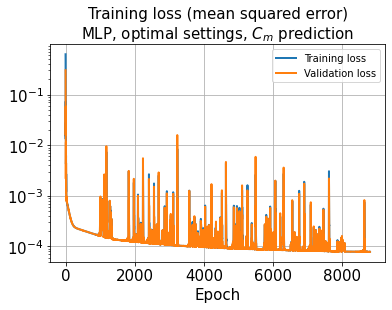

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

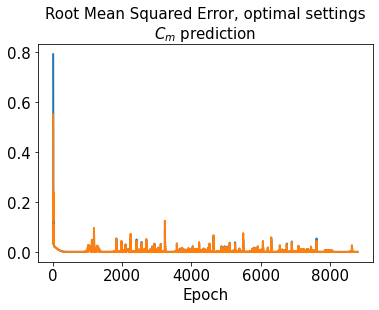

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

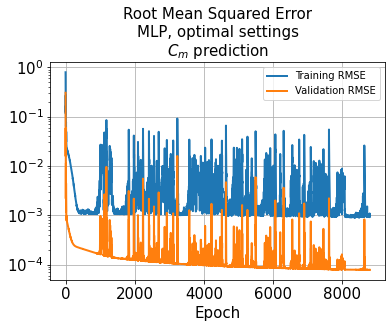

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 7.8663e-05 - rmse: 9.2677e-04


In [37]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 7.8673e-05 - rmse: 9.3224e-04


In [38]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 7.8552e-05 - rmse: 8.6453e-04


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [40]:
decoded_train_

array([[0.00144498],
       [0.00175285],
       [0.00120982],
       ...,
       [0.00145449],
       [0.00123918],
       [0.00133991]], dtype=float32)

In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [46]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [47]:
model_directory = "D:\\TrainedModels\\20221219"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221219Case1unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"unitsCmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [48]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [51]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = mape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.8228315442952482
584.6189144946065


In [52]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= mape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.8225024095355674
680.7024483271488


In [53]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= mape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.8512832043067814
499.0100964977159


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = mape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = mape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = mape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

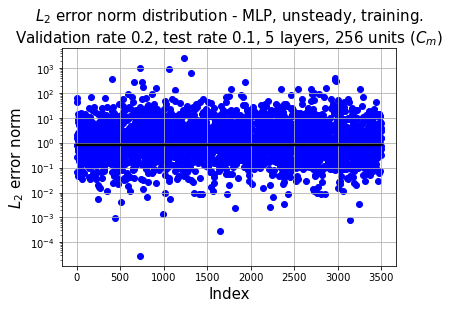

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

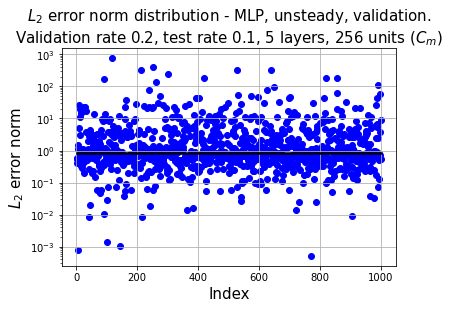

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

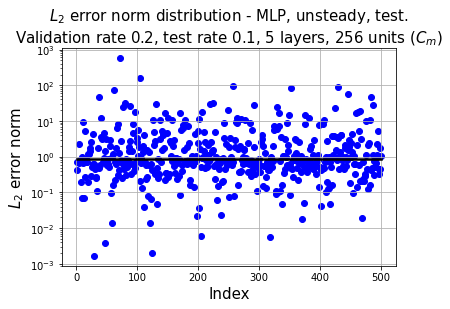

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [73]:
predicted = model.predict(x[5000:10000])

157/157 [==============================] - 0s 2ms/step


In [78]:
predicted.shape

(5000, 1)

In [74]:
np.max(x)

14.99899999999723

In [66]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [67]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [75]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], Cm, 'k-', label='Ground truth')
    plt.plot(t[:5000], cm, 'k--', label='Predicted value')
    plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, iTest, color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: nan


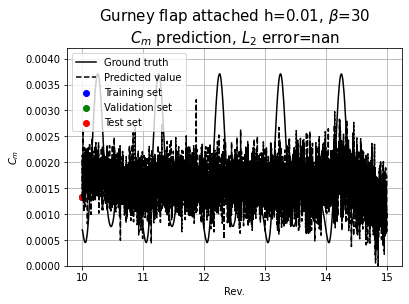

In [79]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(1, 2):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    #l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm = predictedValue #denormalize(predictedValue)
    Cm = y_corres #denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<t_len) & ((index_train>=0)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_train<t_len) & ((index_train>=0)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_train<t_len) & ((index_train>=0)))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<t_len) & ((index_train>=0)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_train<t_len) & ((index_train>=0)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_train<t_len) & ((index_train>=0)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest)

In [ ]:
y

In [ ]:
cm